In [1]:
import sys
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import glob 
import numpy as np
from astropy.time import Time
import splat
import wisps
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import statsmodels.nonparametric.kernel_density as kde
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


##  Finalizing observations table 

In [2]:
def kde_statsmodels_m(x, x_grid,**kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    model = kde.KDEMultivariate(x, bw='normal_reference',
                          var_type='c', **kwargs)
    return model.pdf(x_grid), model.cdf(x_grid)

In [3]:
from scipy import interpolate
def max_flux(mags, **kwargs):
    
    """
    Estimates limiting magnitude using stats model kde
    """
    try:
        #ignore nans and infinities or empty arrays
        #print (mags)
        if np.isnan(mags).all() or (mags==np.array([])):
            return (np.nan, np.nan)
        if len(mags)==1: return (np.nan, np.nan)
        mags=mags[~np.isnan(mags)]
        mags=mags[~np.isinf(mags)]

        #created grid (equally spaced numbers)
        xgrid=np.linspace(np.nanmin(mags), np.nanmax(mags), len(mags))

        #obtain Pdf
        pdf, cdf= kde_statsmodels_m(mags, xgrid)

        #plot
        if kwargs.get('plot', False):
            label=kwargs.get('label', '')
            plt.figure()
            plt.plot(xgrid, cdf)
            plt.hist(mags, normed=True, bins=20, cumulative=True)
            plt.xlabel(label)
            plt.savefig('/Users/caganze/research/wisps/figures/maghists/'+str(label)+'.pdf')
        #max flux is where 90.0% of the flux is measured

        f= interpolate.interp1d( cdf, xgrid)
        maxid, minid=(np.nanmax(cdf), 0.1)
        if minid >0.1: minid = np.nanmin(cdf)+0.05
        print (f(maxid))
        print (f(minid))
        print ('mag range', np.nanmin(xgrid), np.nanmax(xgrid))
        print ('cdf range', np.nanmin(cdf), np.nanmax(cdf))
        magmax, magmin=(f(maxid), f(minid))
        print (magmax.round(), magmin.round())
        return magmax.round(), magmin.round()
    except: return np.nan, np.nan

In [4]:
def create_pointing(grism_id):
    pointing=None
    if grism_id.startswith('Par'): return 'wisps-'+grism_id.split('Par')[-1].split('_')[0]
    else: return grism_id.split('-G141')[0]

In [5]:
#add a pointing column to the table
data_with_cut=wisps.COMBINED_PHOTO_SPECTRO_DATA
data_with_cut['pointing']=data_with_cut.grism_id.apply(create_pointing)

In [6]:
data_with_cut.columns

Index(['grism_id', 'Spts', 'Chis', 'cdf_snr', 'CH_4/H-Cont', 'CH_4/H_2O-1',
       'CH_4/H_2O-2', 'CH_4/J-Cont', 'H-cont/H_2O-1', 'H-cont/H_2O-2',
       'H-cont/J-Cont', 'H_2O-1/J-Cont', 'H_2O-2/H_2O-1', 'H_2O-2/J-Cont',
       'F110', 'F140', 'F160', 'RA', 'DEC', 'survey', 'phot_flag', 'pointing'],
      dtype='object')

In [7]:
limit_f140mags_per_field=[]
limit_f160mags_per_field=[]
limit_f110mags_per_field=[]

In [8]:
field_names=[]

aegis-01
29.48041810829097
21.02769149412129
mag range 15.383544925780491 29.48041810829097
cdf range 0.0022919597196515464 0.997072245986682
29.0 21.0
25.93028581381016
20.924338569677158
mag range 15.269116002975814 25.93028581381016
cdf range 0.0021859774609962208 0.9297024819583969
26.0 21.0
aegis-02
27.137784898787263
20.97949238710438
mag range 15.4789921133189 27.137784898787263
cdf range 0.0028248589373630604 0.9931270732853406
27.0 21.0
26.51454740485764
20.81273454690721
mag range 15.520070945718329 26.51454740485764
cdf range 0.0027624316260964534 0.9774305653312203
27.0 21.0
aegis-03
29.74801168628986
20.615314796039907
mag range 16.119796041594952 29.74801168628986
cdf range 0.005852742263103245 0.9970587070863467
30.0 21.0
26.118977445234737
20.503690721648084
mag range 16.100098551290667 26.118977445234737
cdf range 0.005797033889782736 0.9396462787588198
26.0 21.0
aegis-04
25.878588942865115
20.555326108000827
mag range 18.184224010003426 25.878588942865115
cdf range 0.

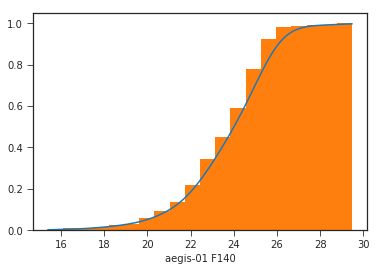

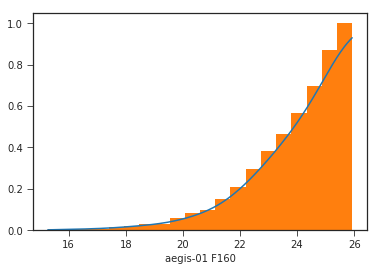

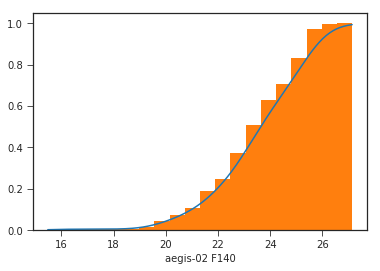

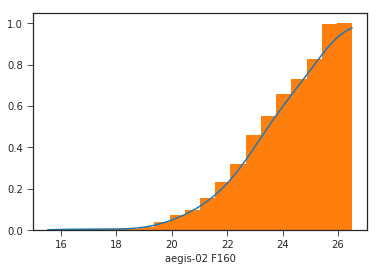

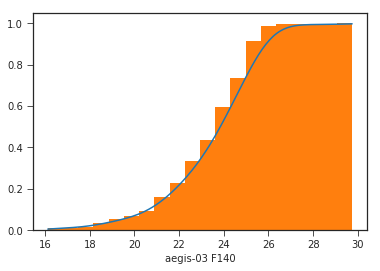

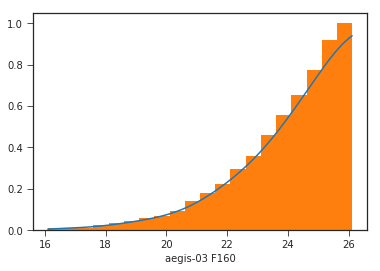

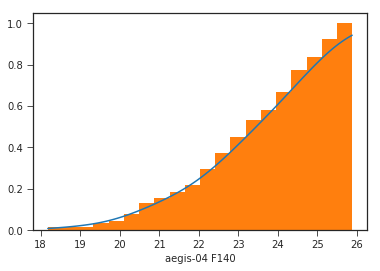

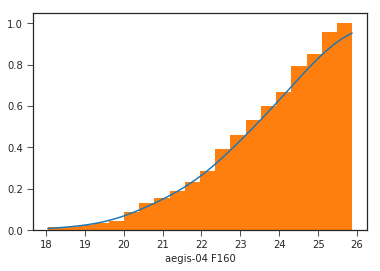

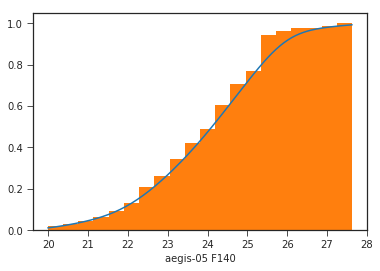

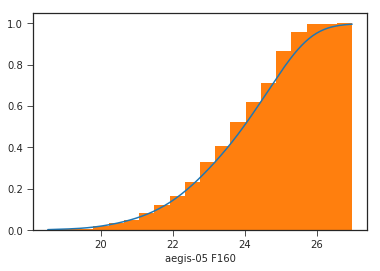

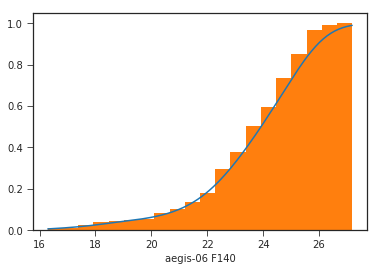

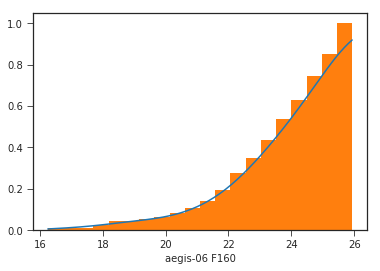

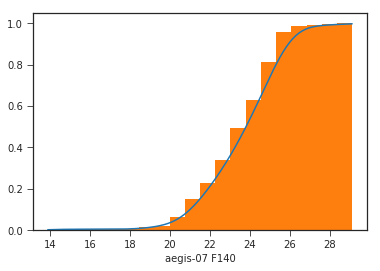

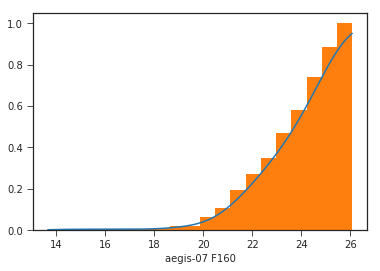

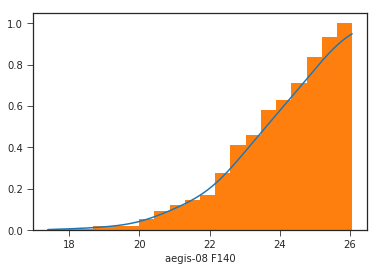

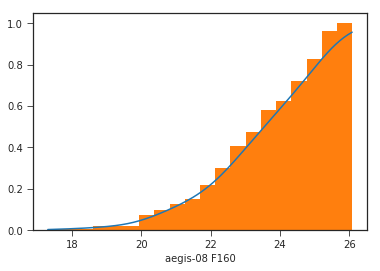

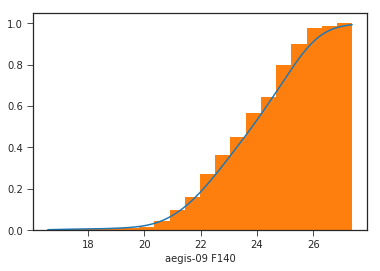

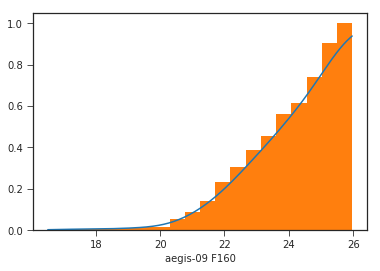

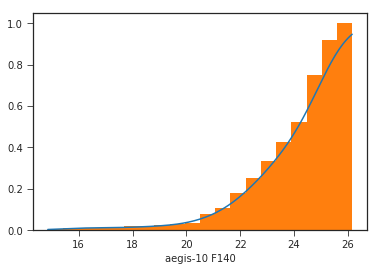

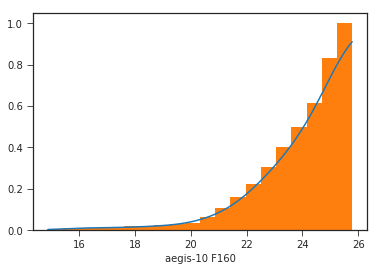

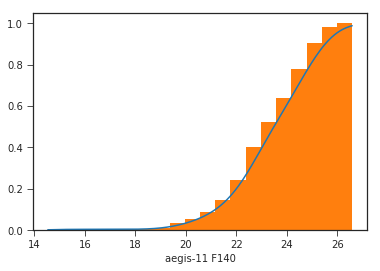

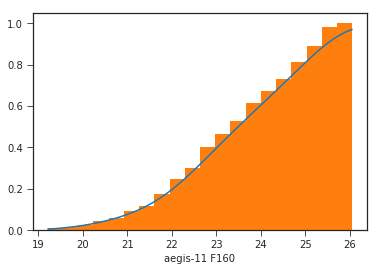

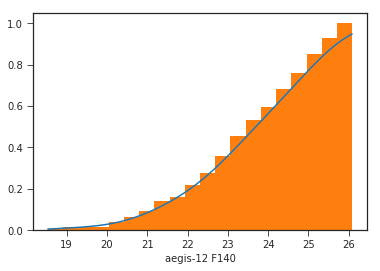

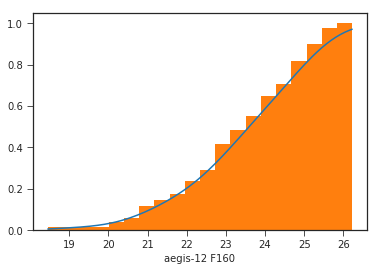

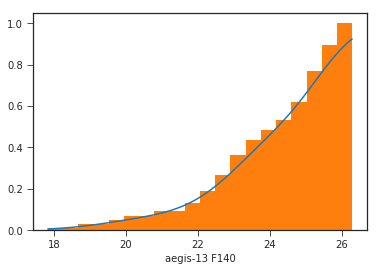

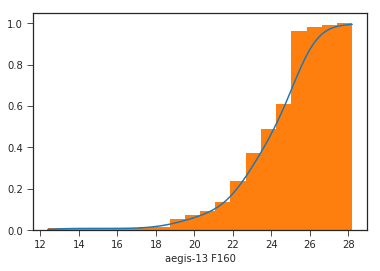

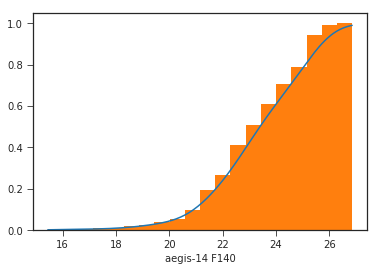

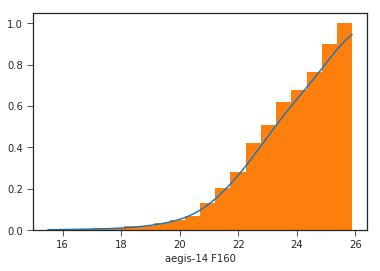

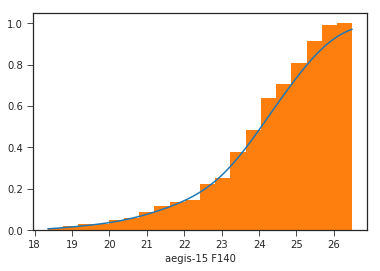

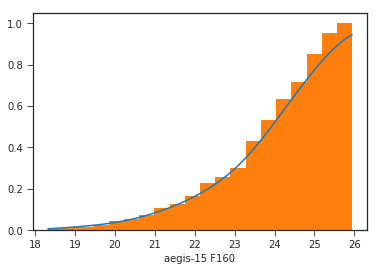

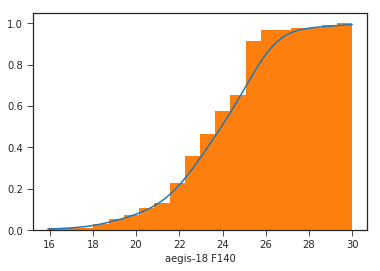

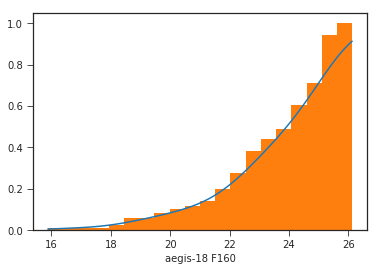

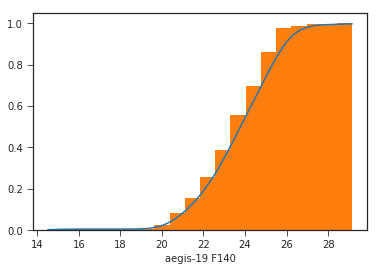

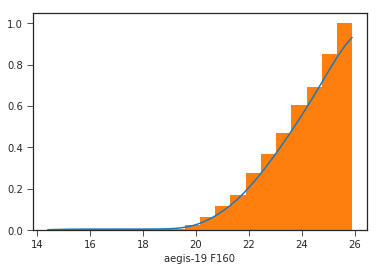

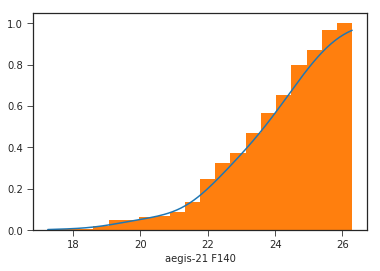

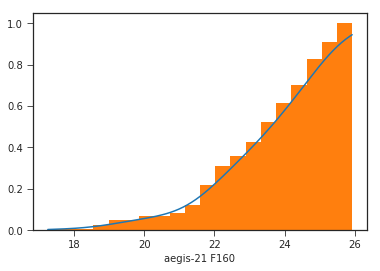

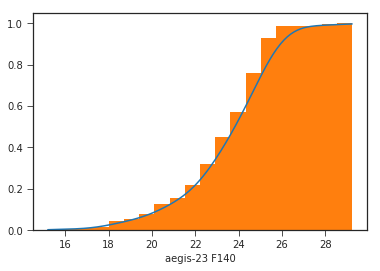

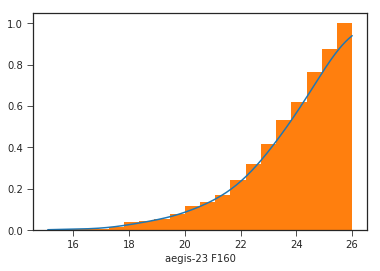

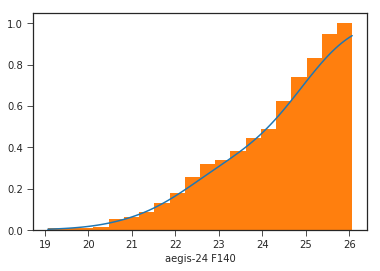

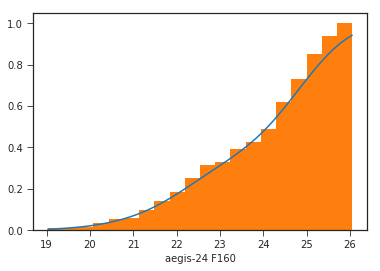

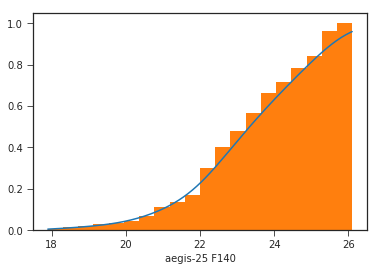

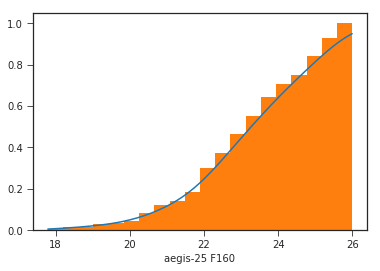

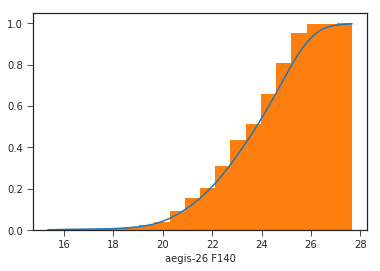

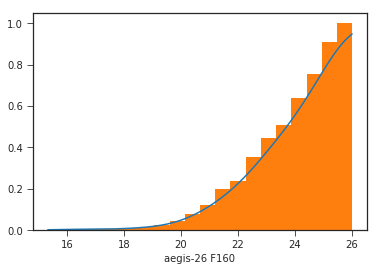

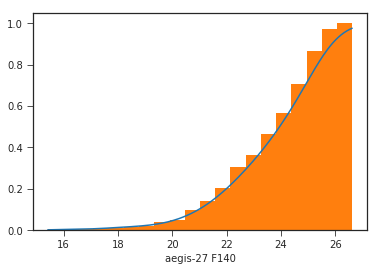

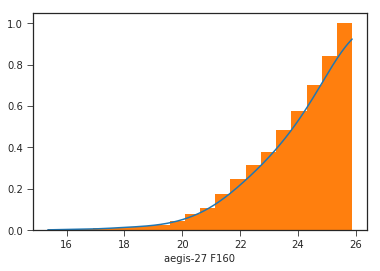

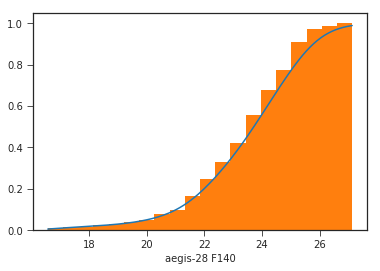

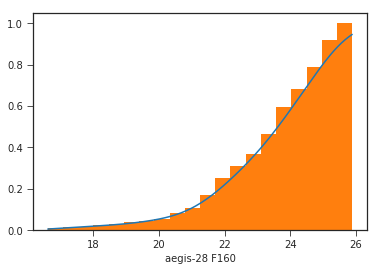

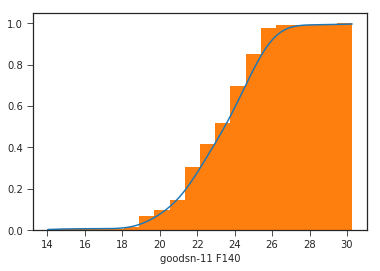

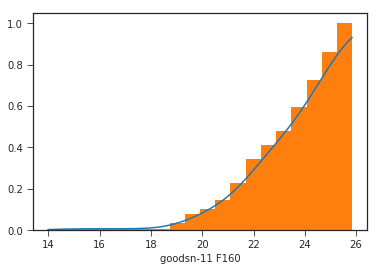

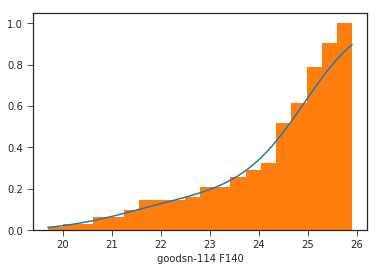

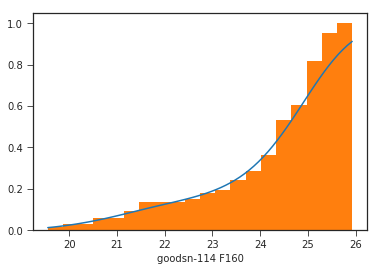

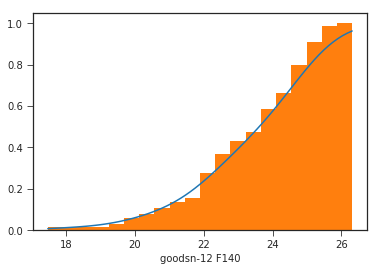

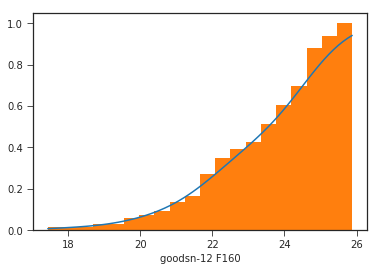

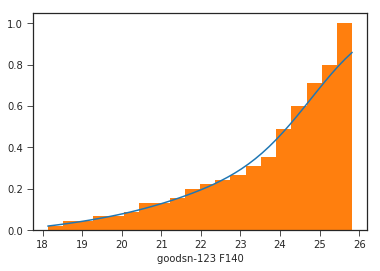

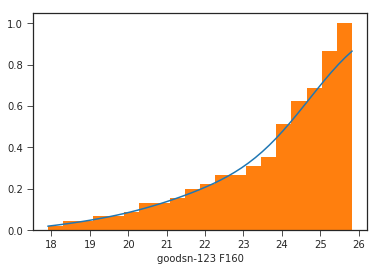

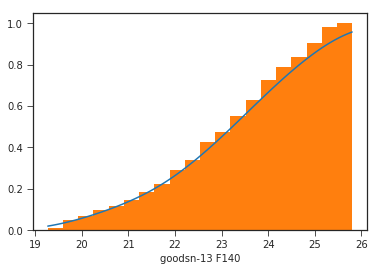

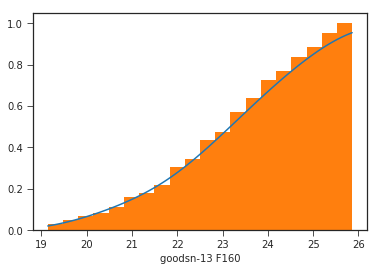

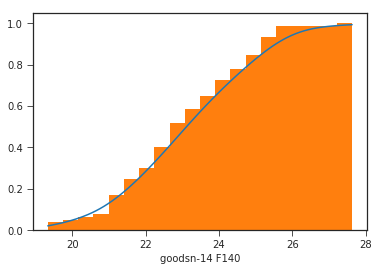

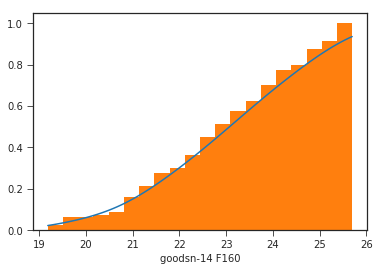

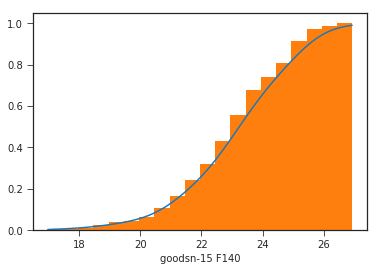

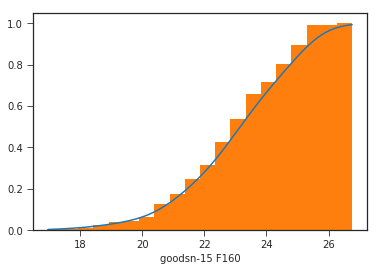

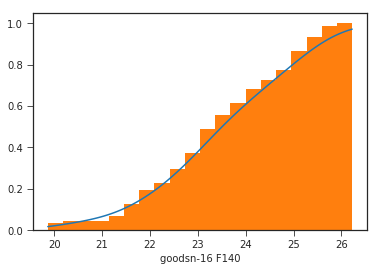

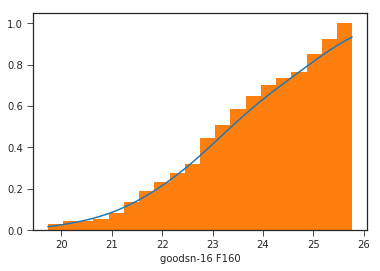

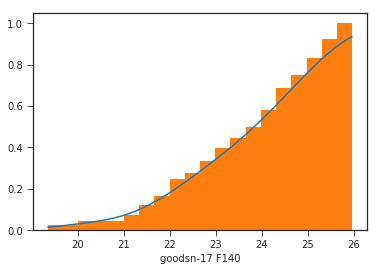

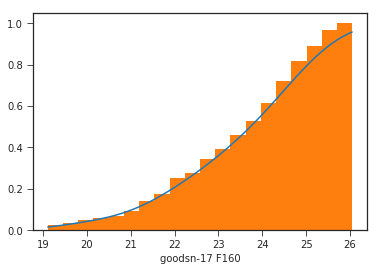

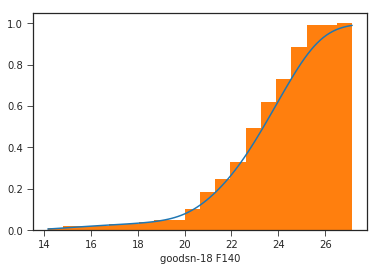

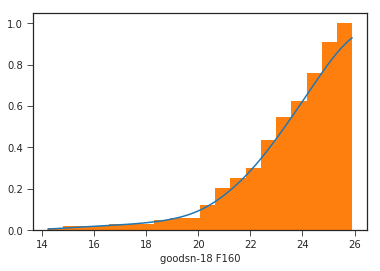

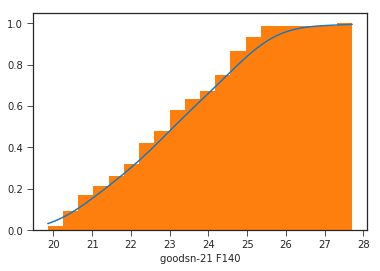

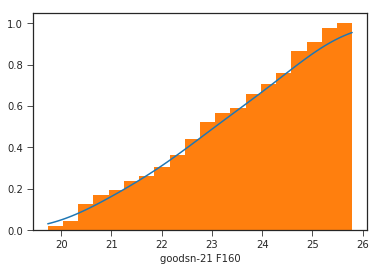

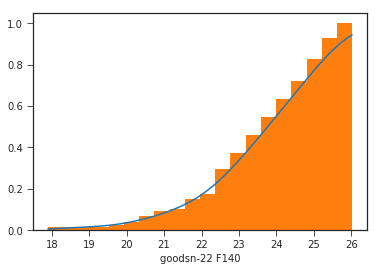

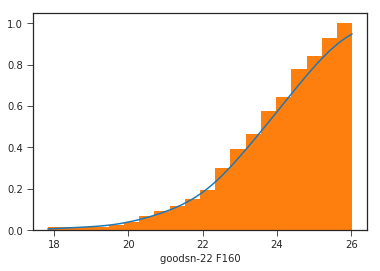

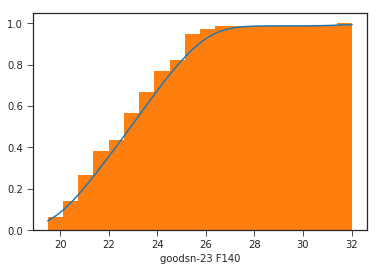

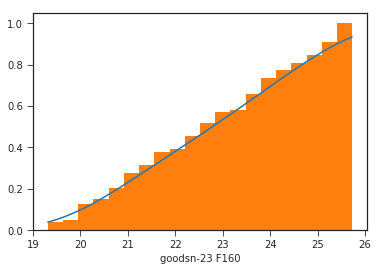

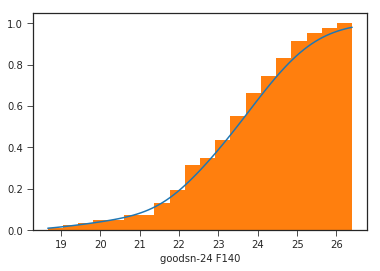

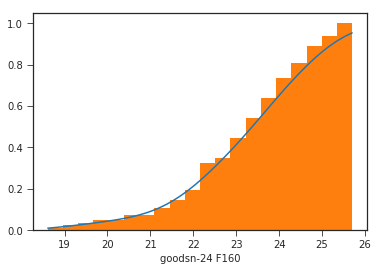

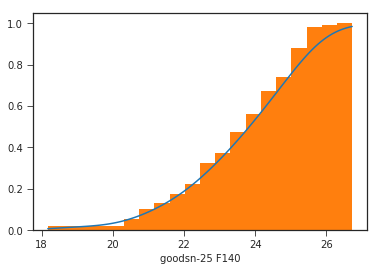

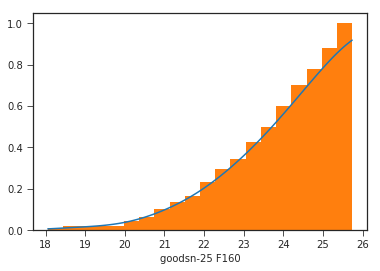

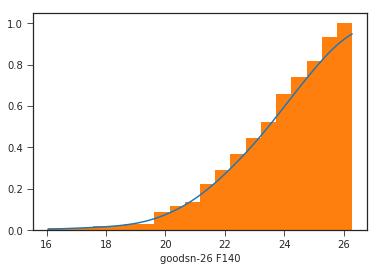

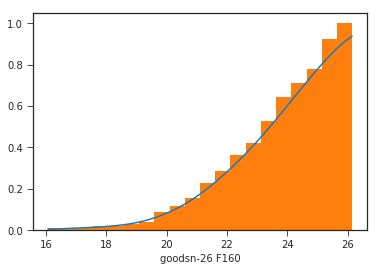

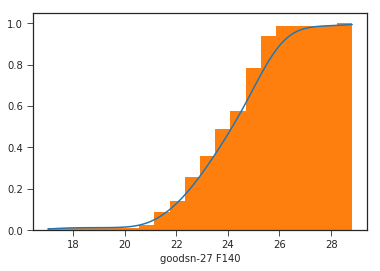

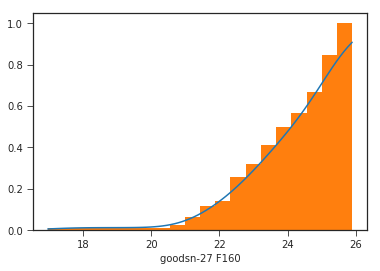

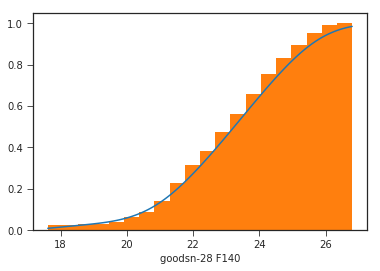

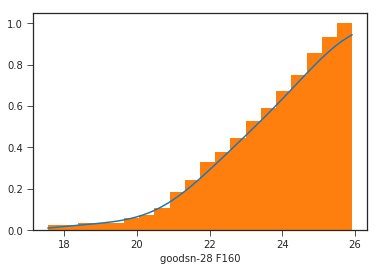

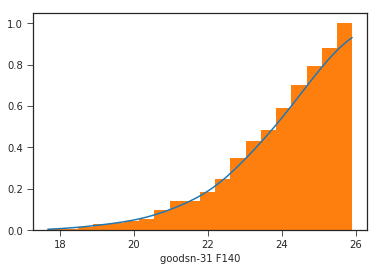

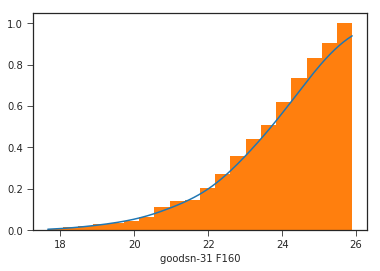

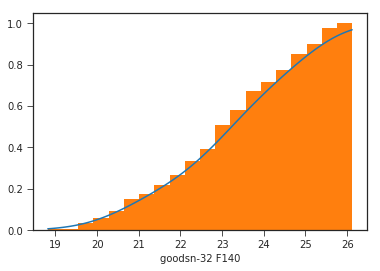

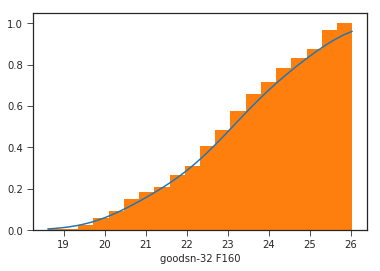

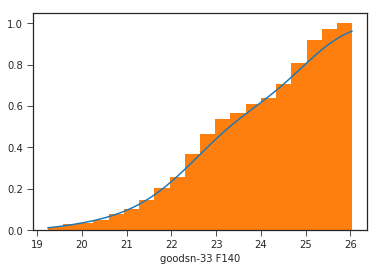

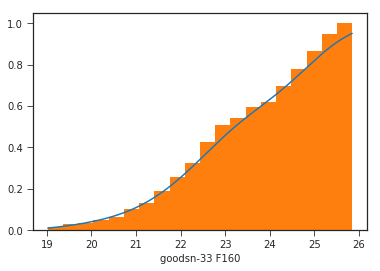

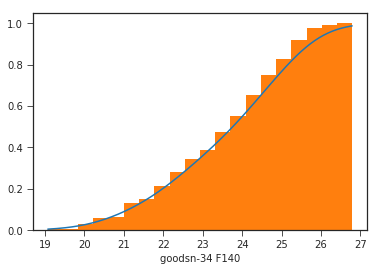

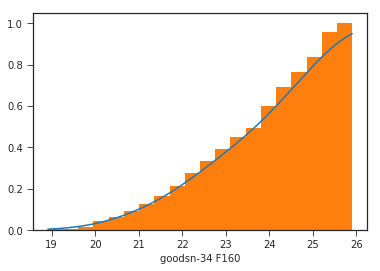

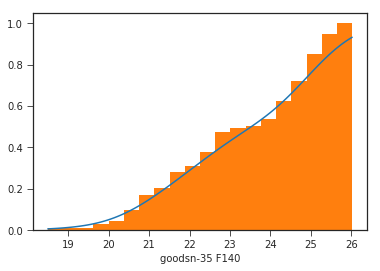

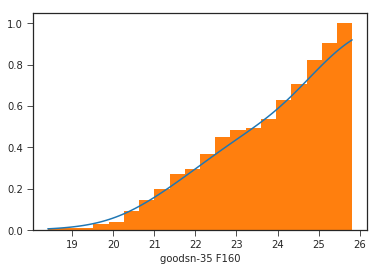

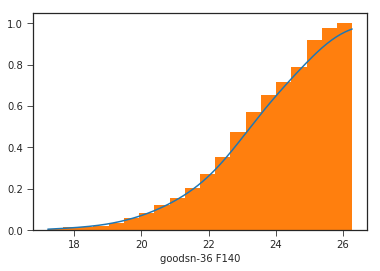

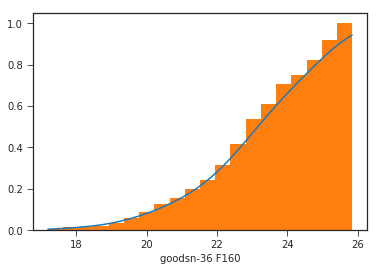

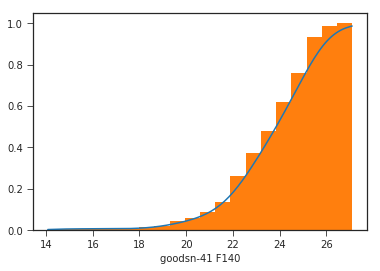

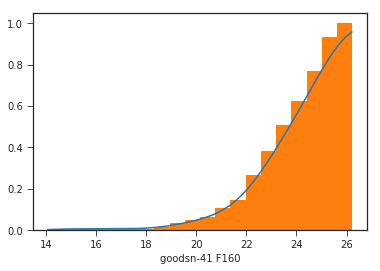

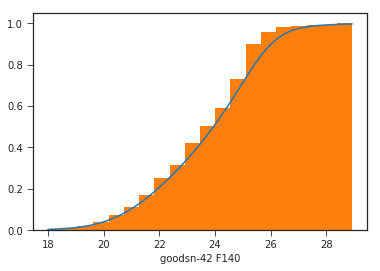

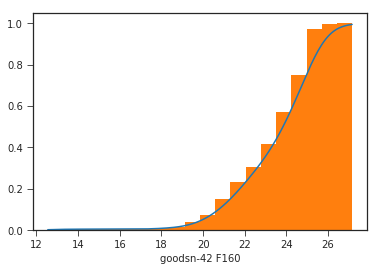

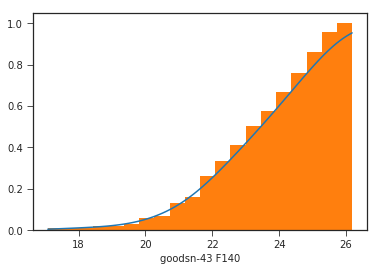

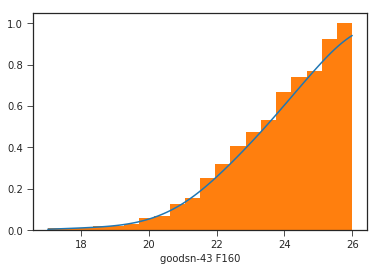

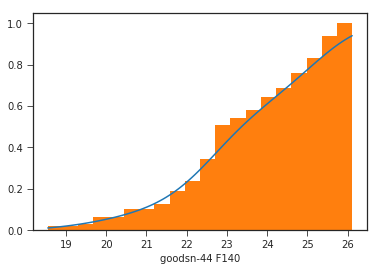

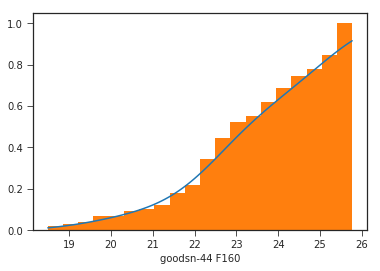

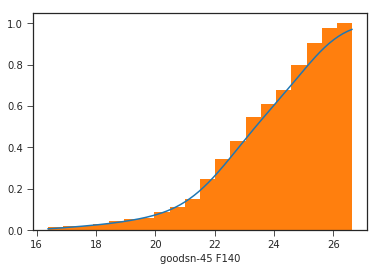

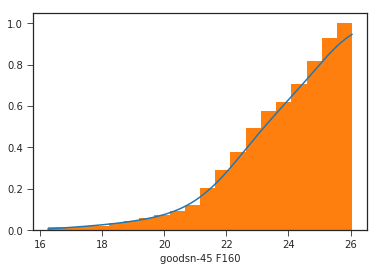

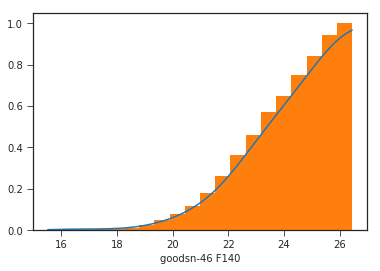

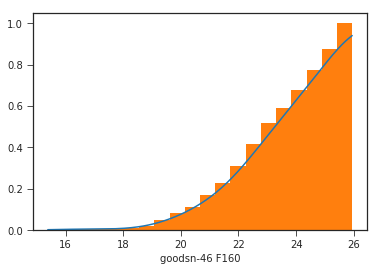

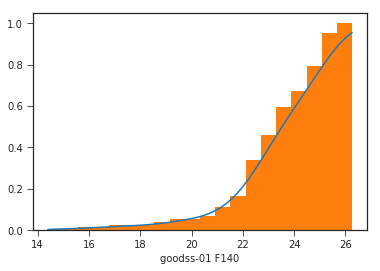

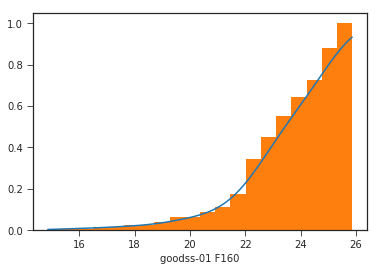

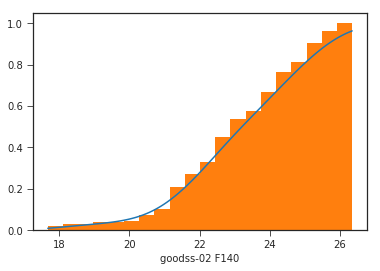

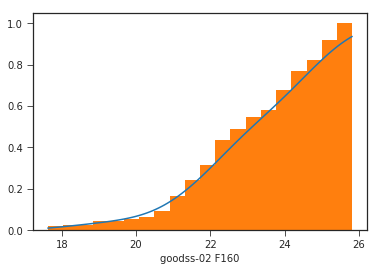

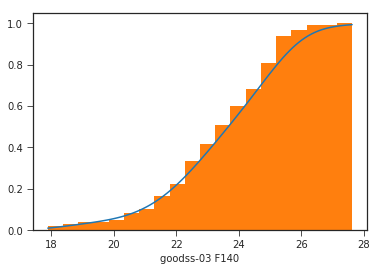

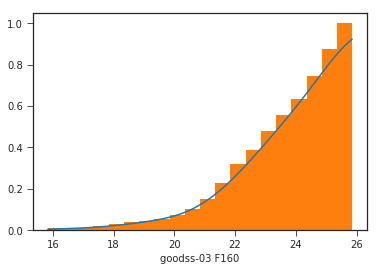

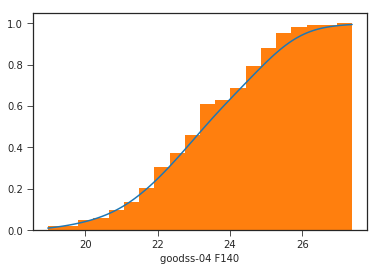

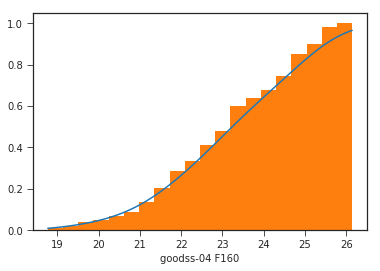

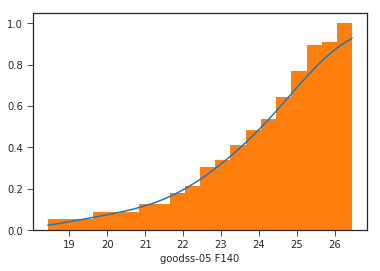

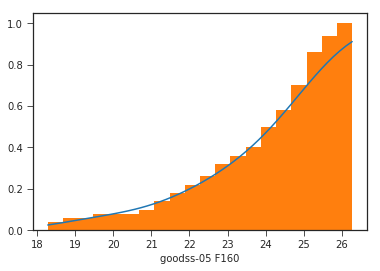

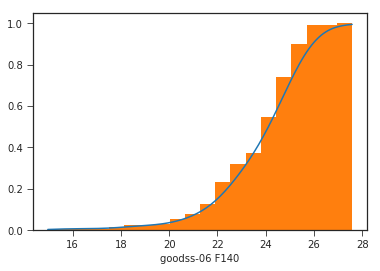

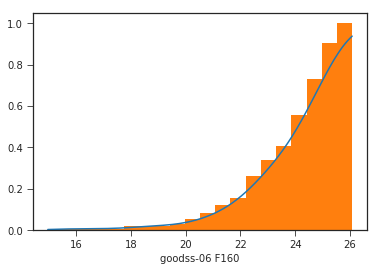

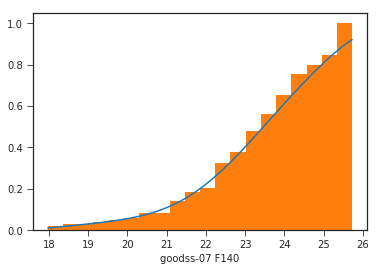

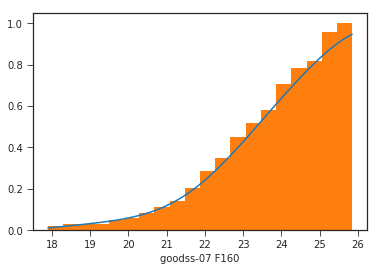

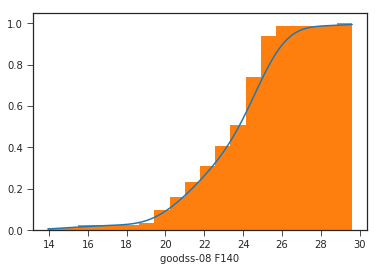

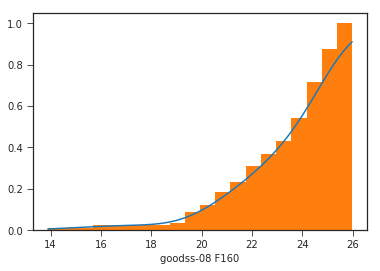

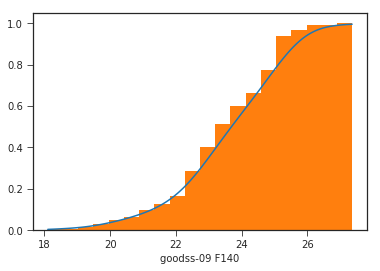

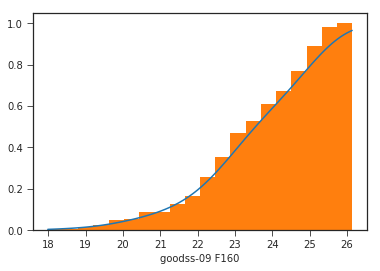

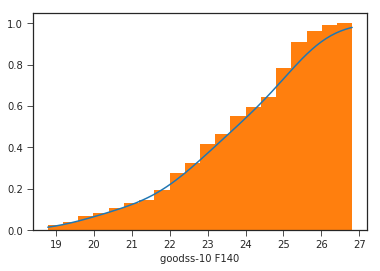

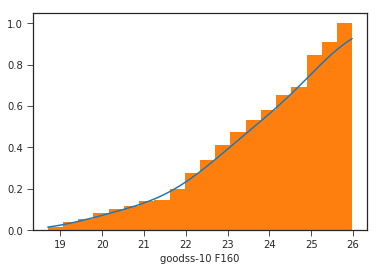

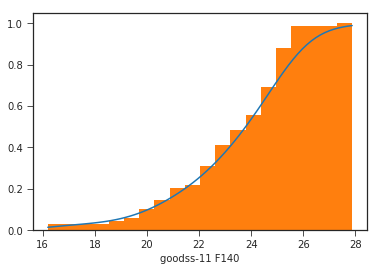

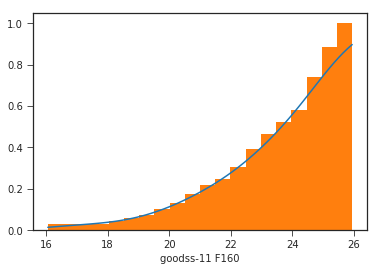

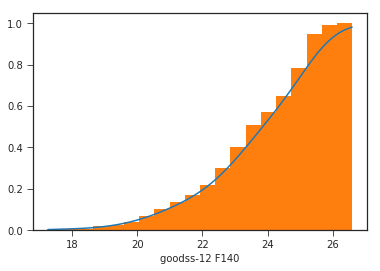

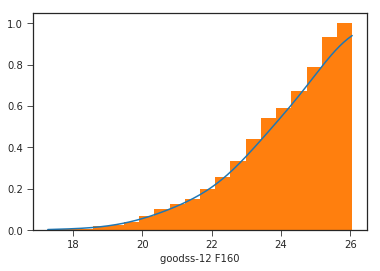

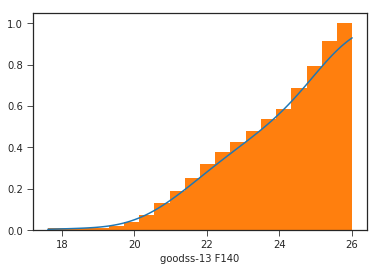

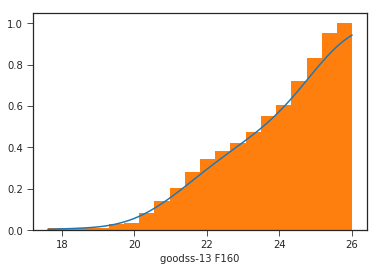

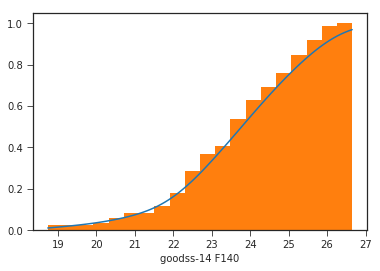

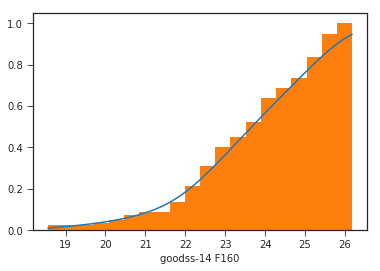

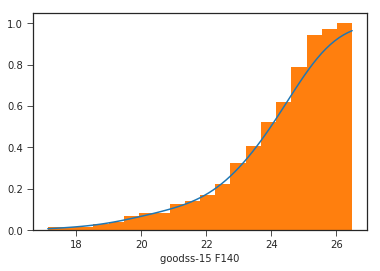

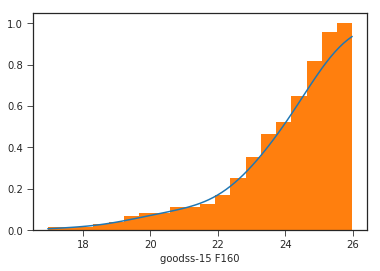

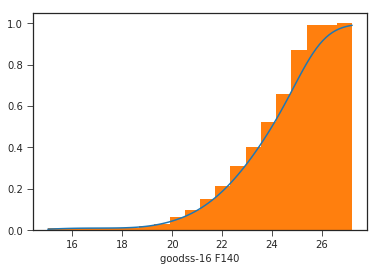

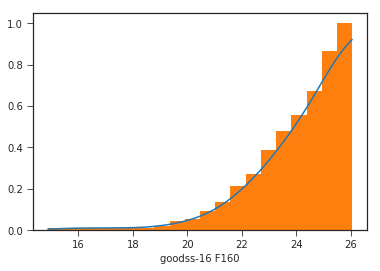

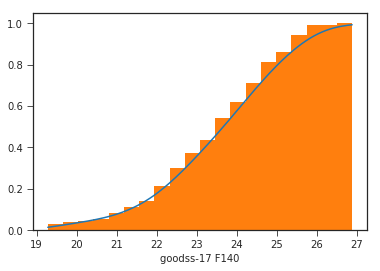

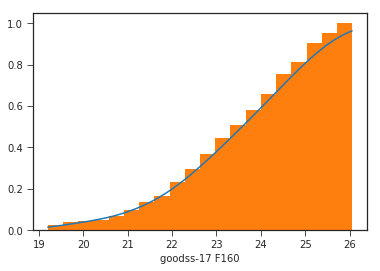

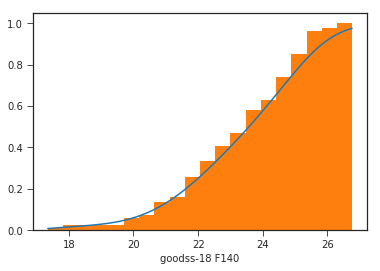

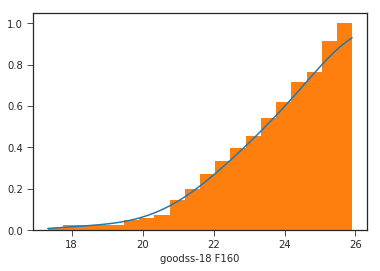

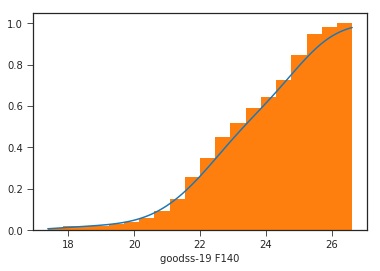

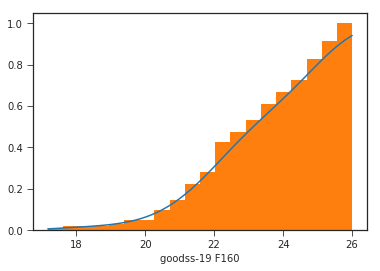

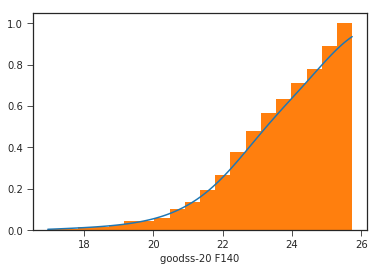

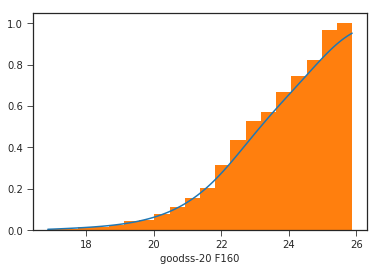

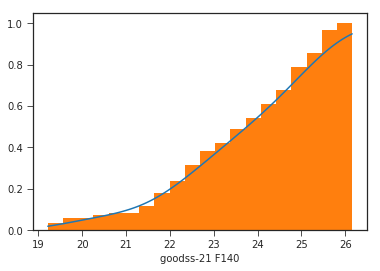

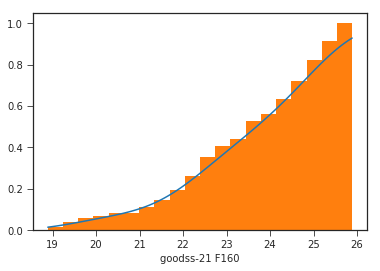

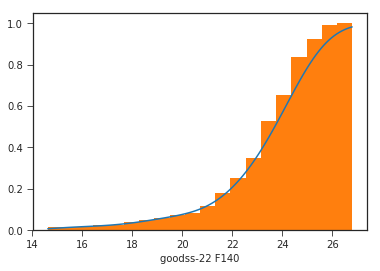

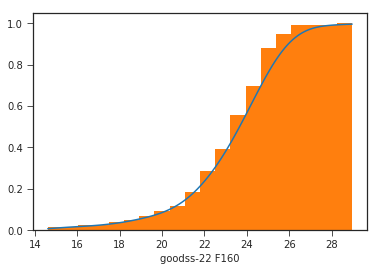

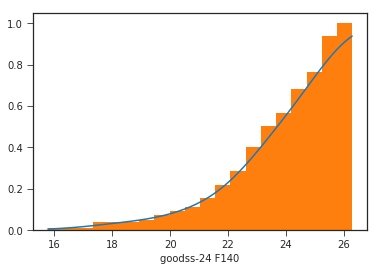

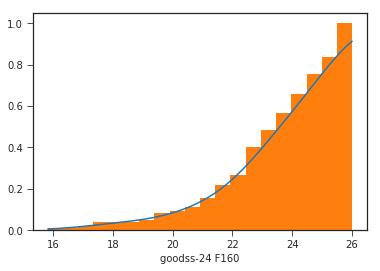

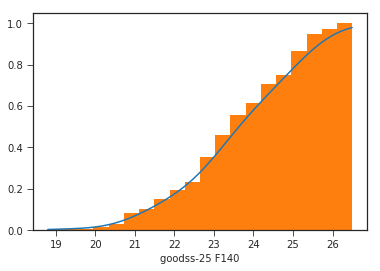

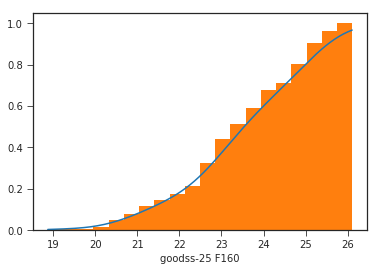

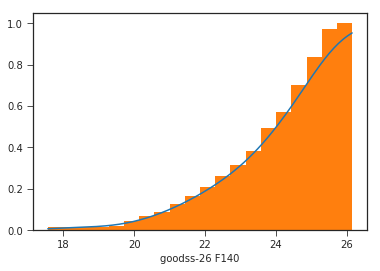

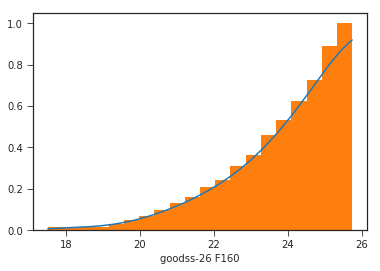

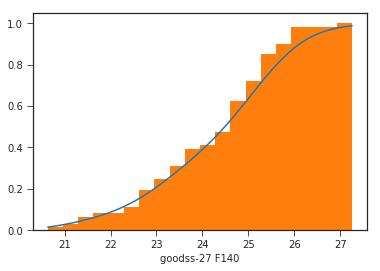

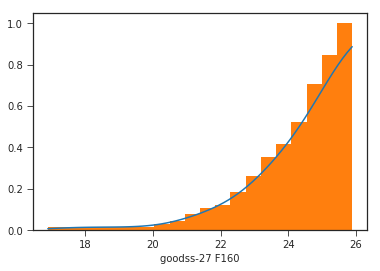

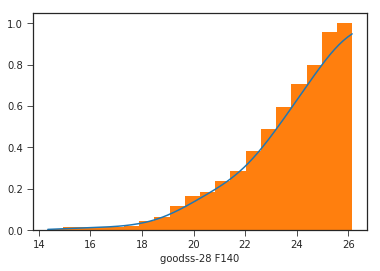

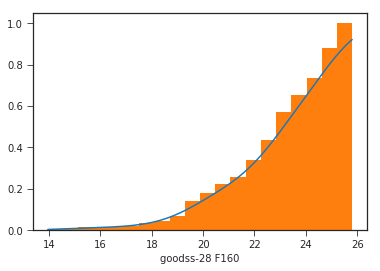

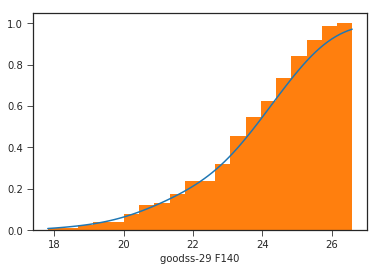

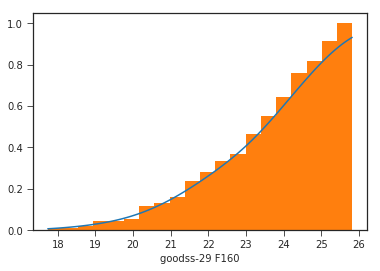

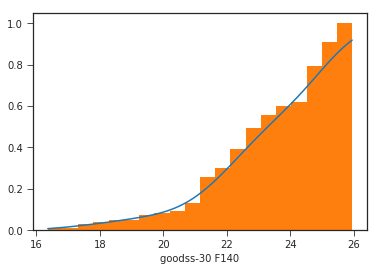

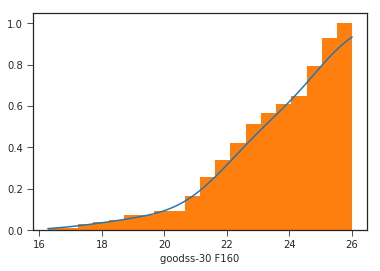

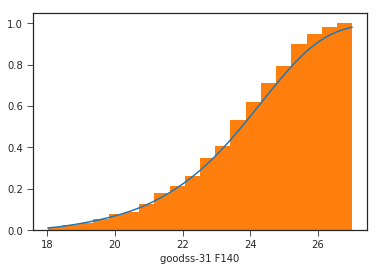

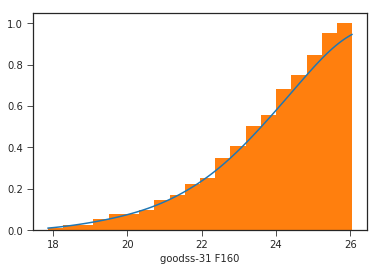

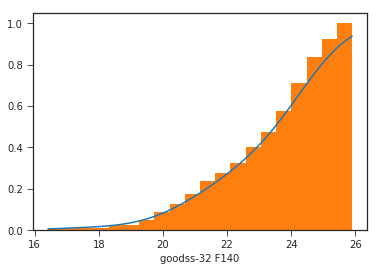

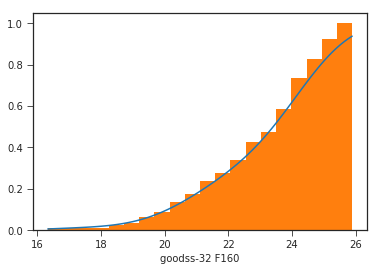

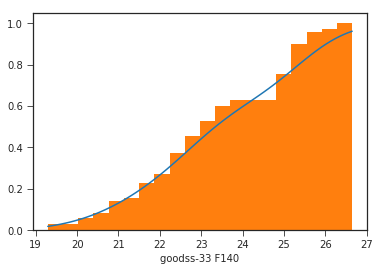

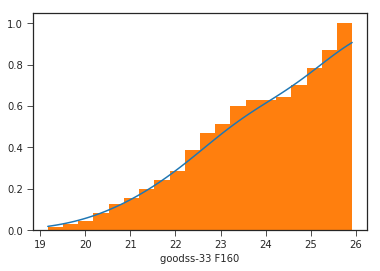

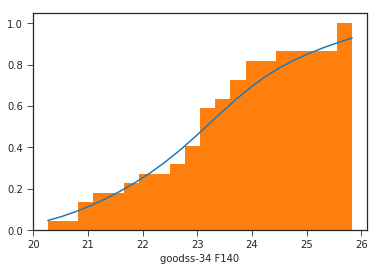

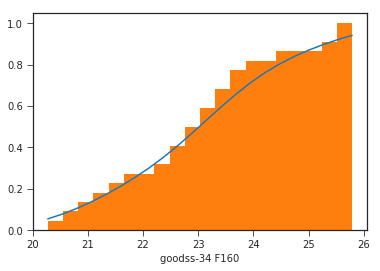

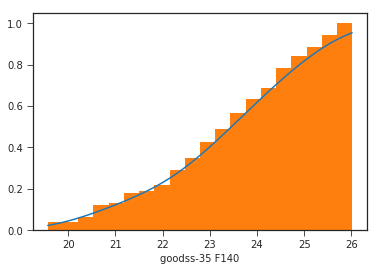

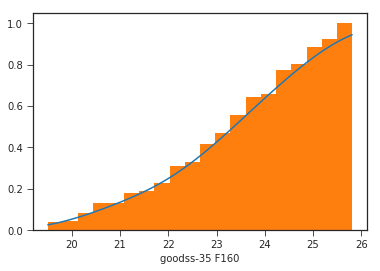

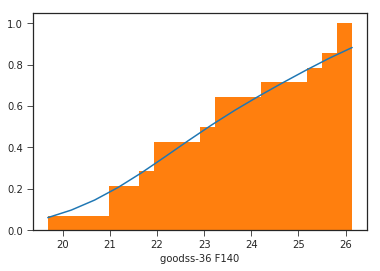

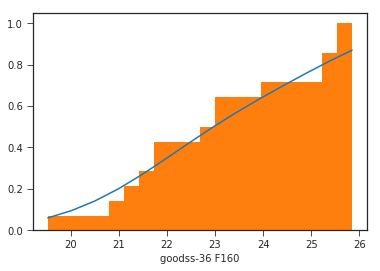

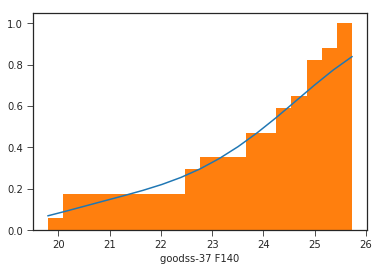

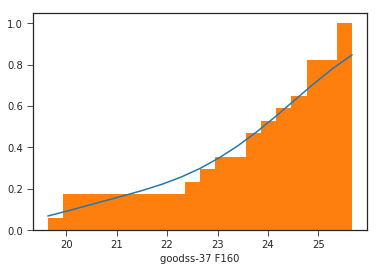

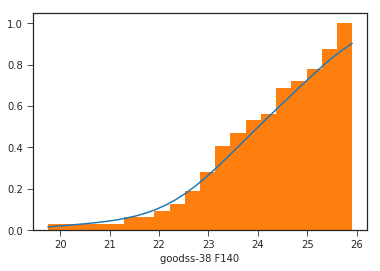

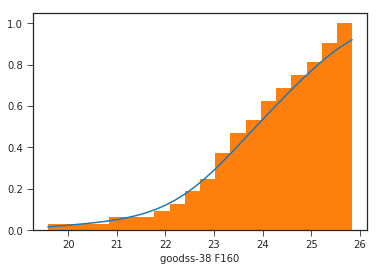

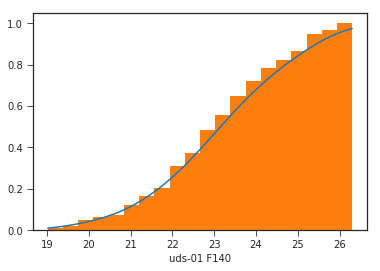

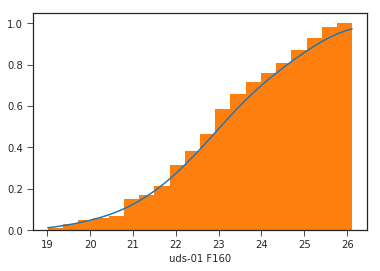

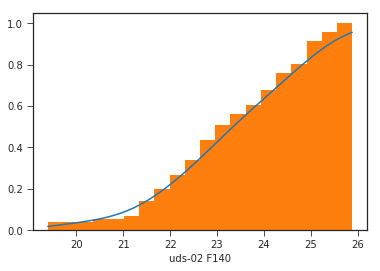

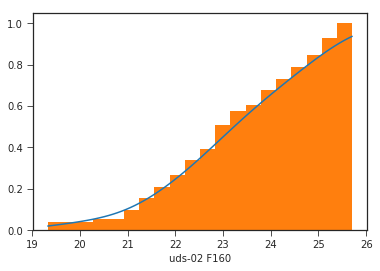

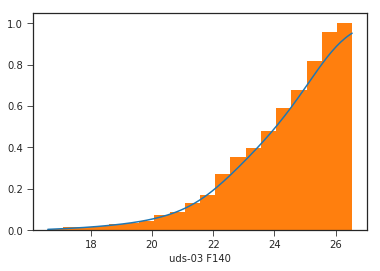

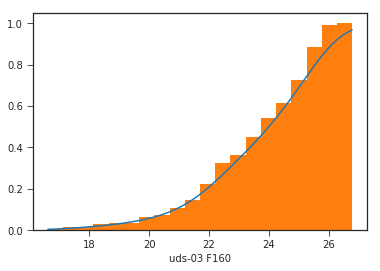

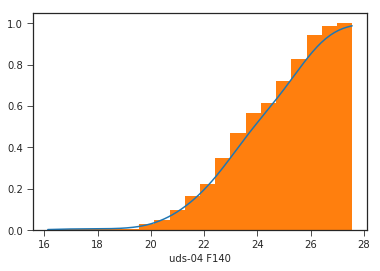

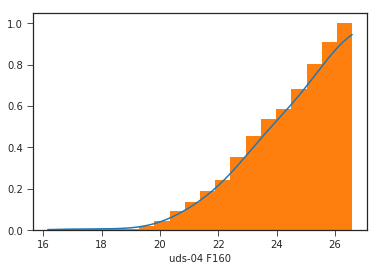

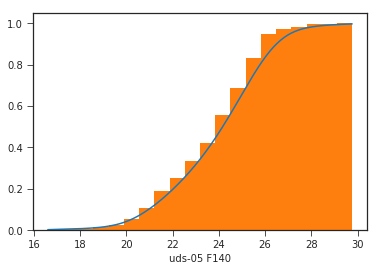

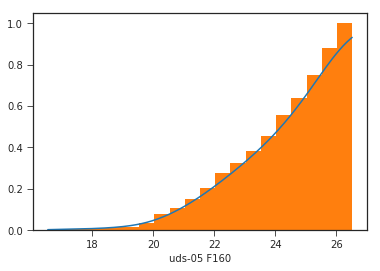

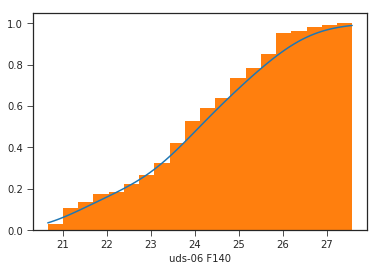

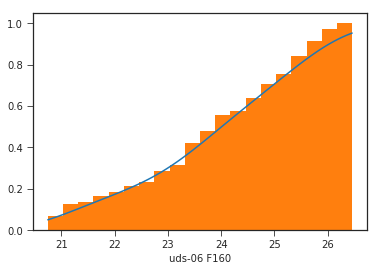

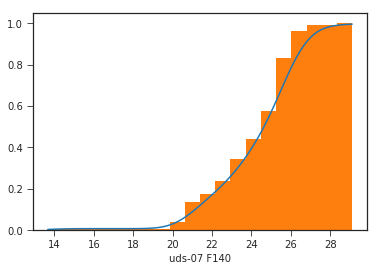

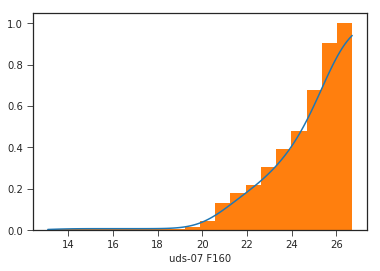

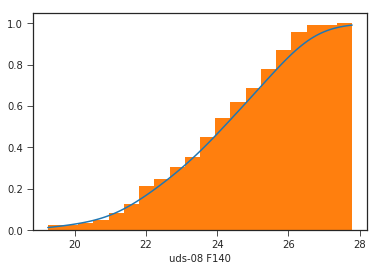

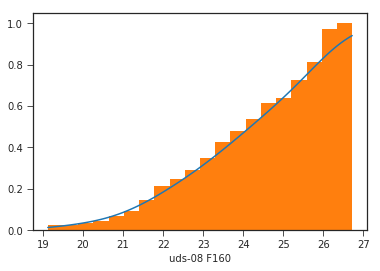

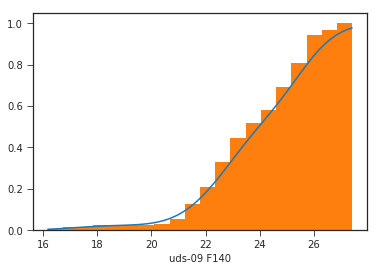

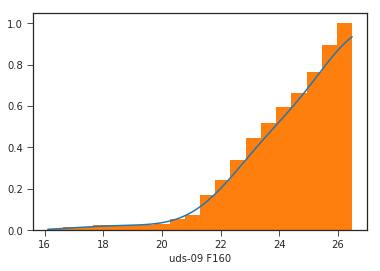

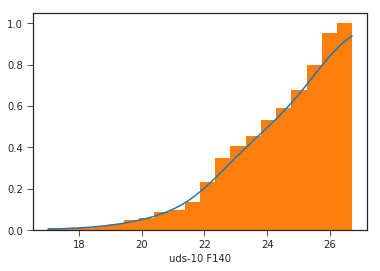

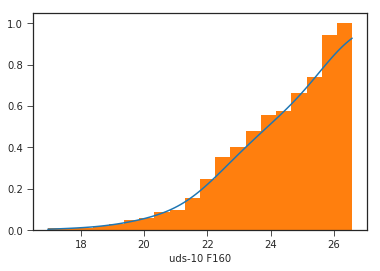

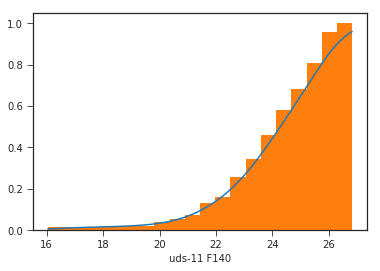

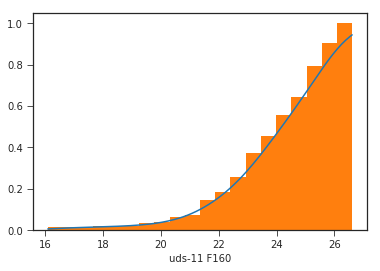

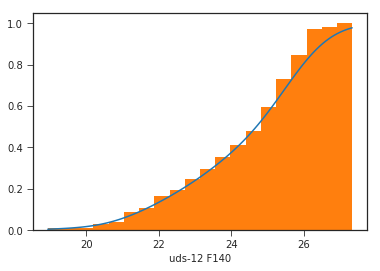

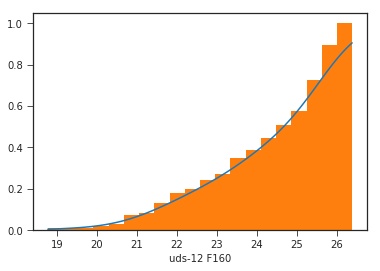

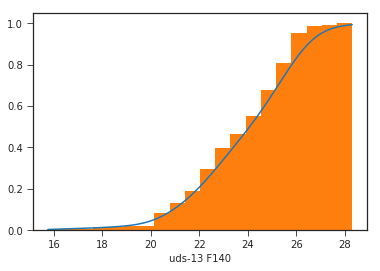

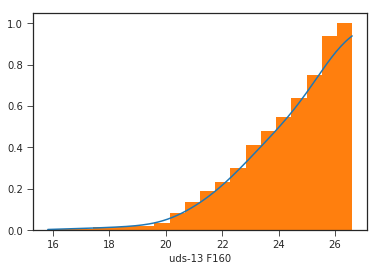

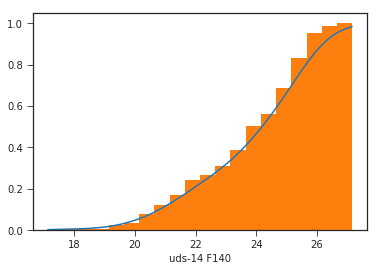

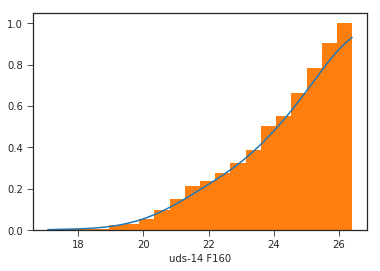

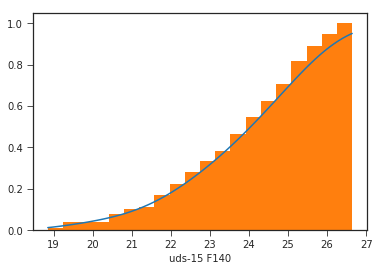

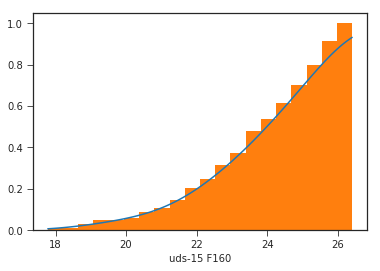

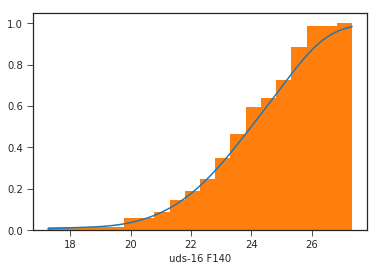

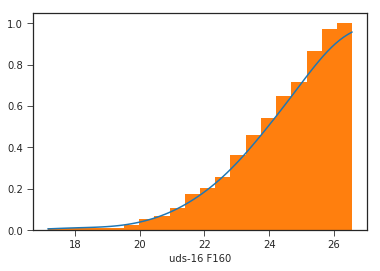

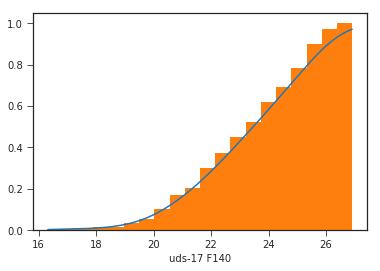

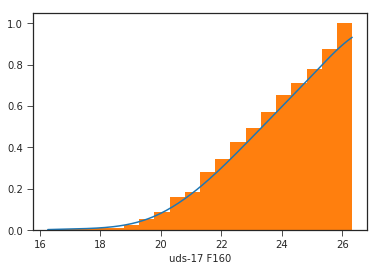

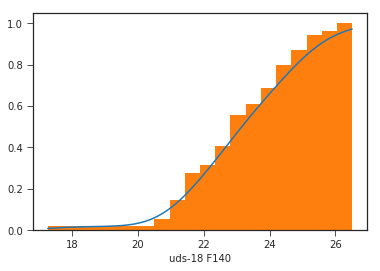

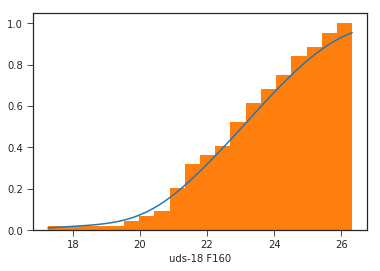

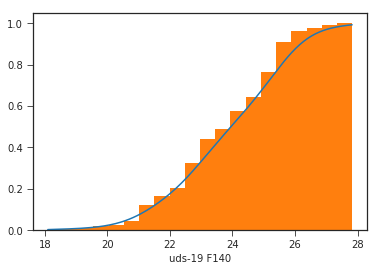

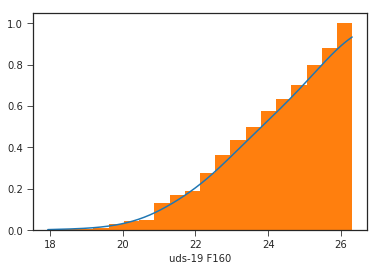

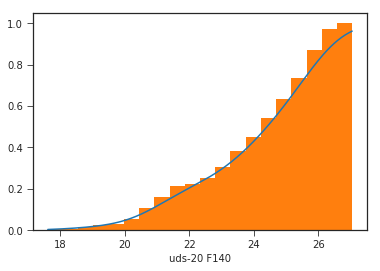

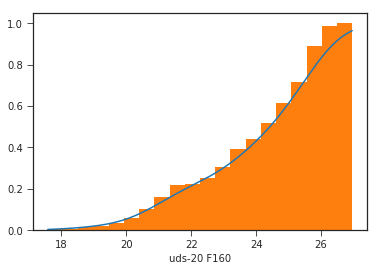

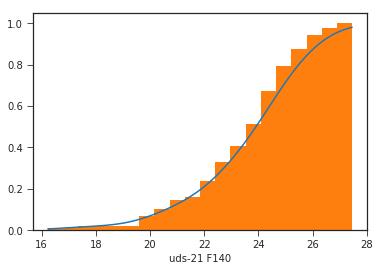

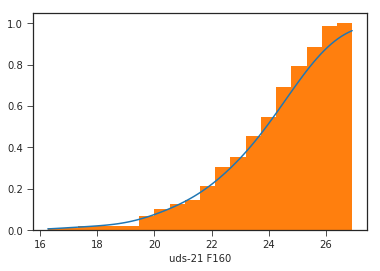

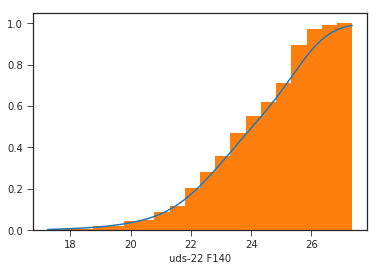

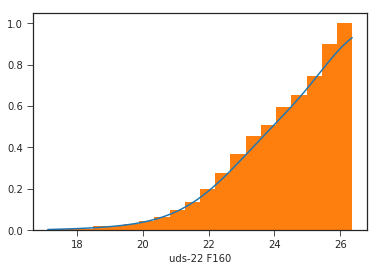

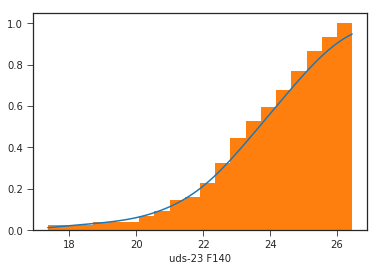

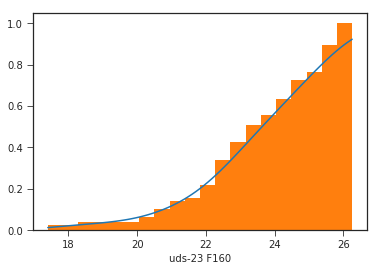

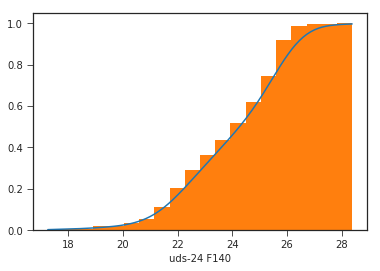

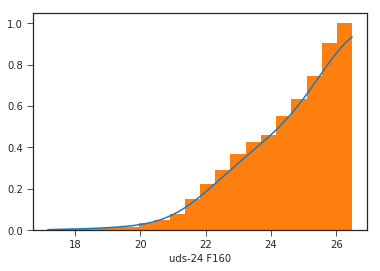

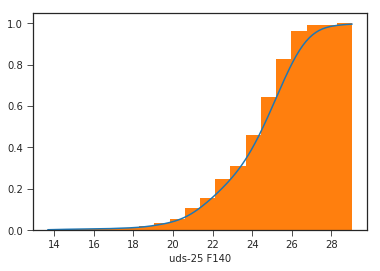

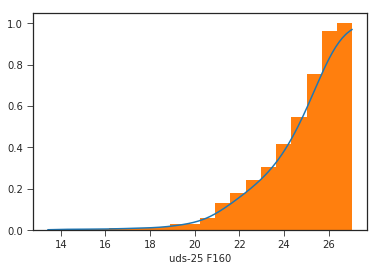

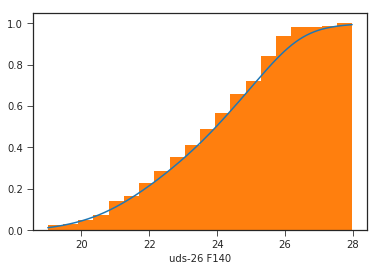

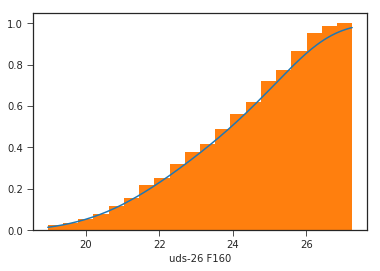

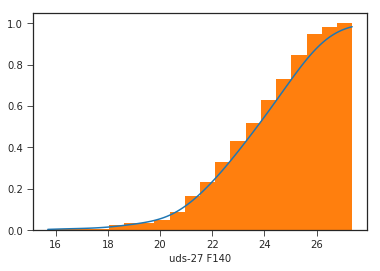

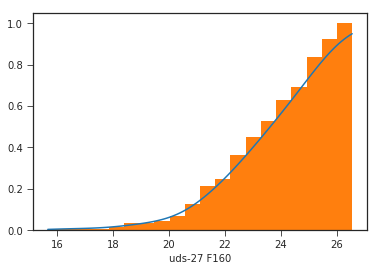

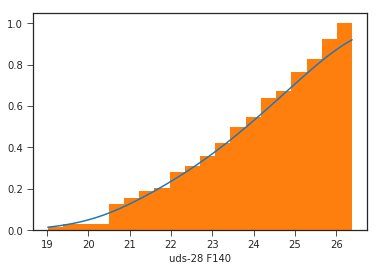

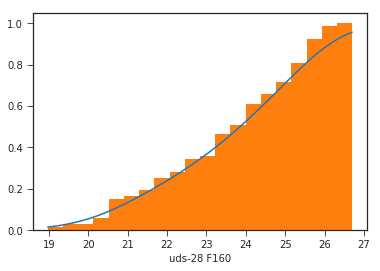

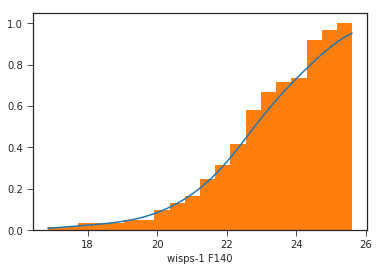

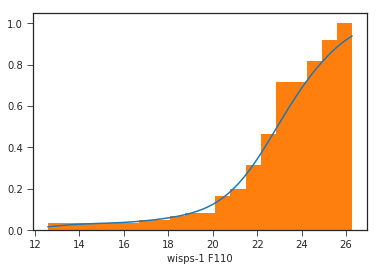

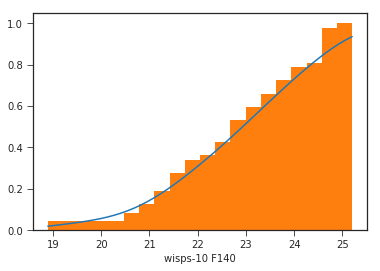

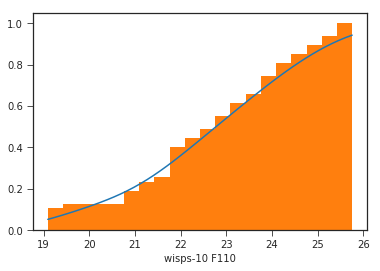

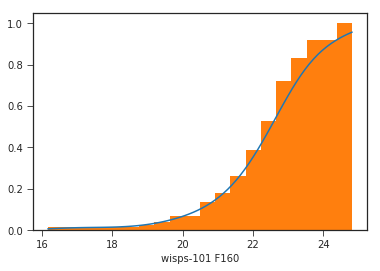

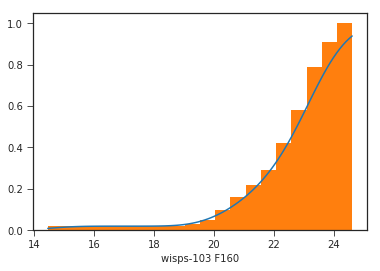

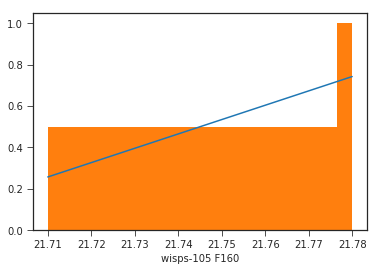

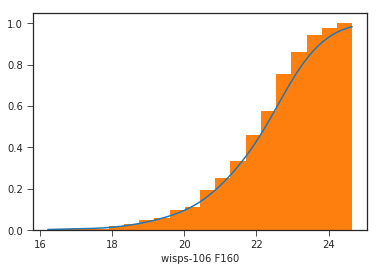

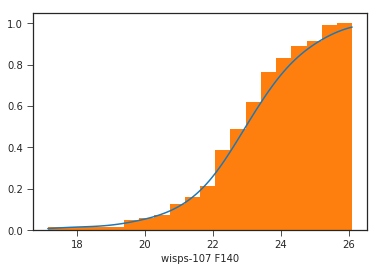

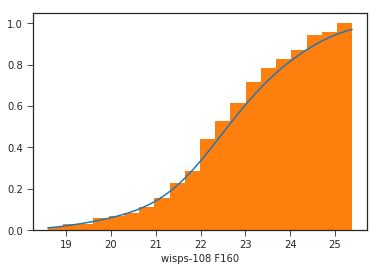

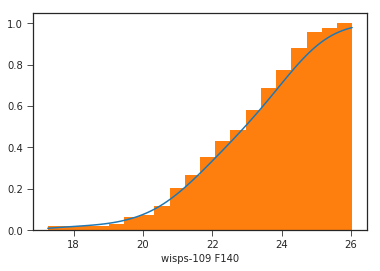

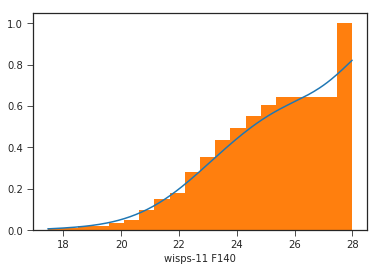

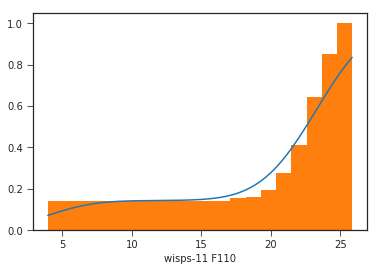

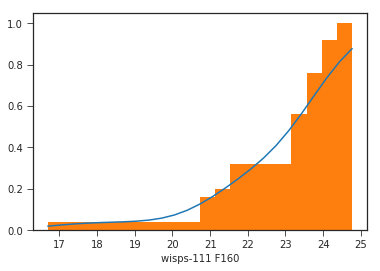

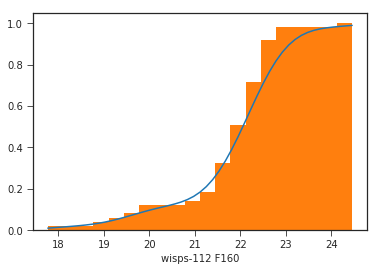

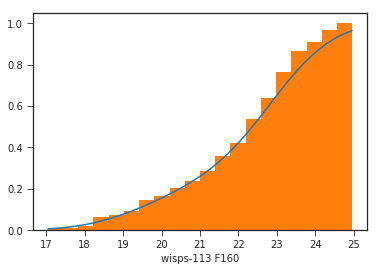

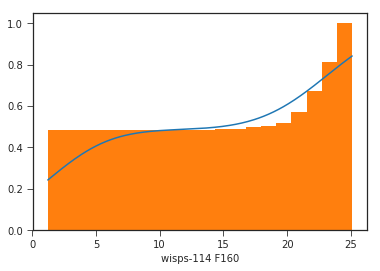

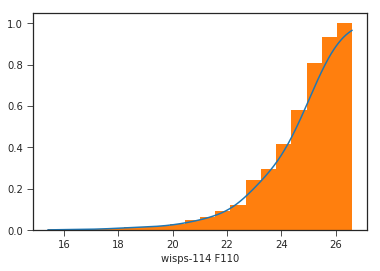

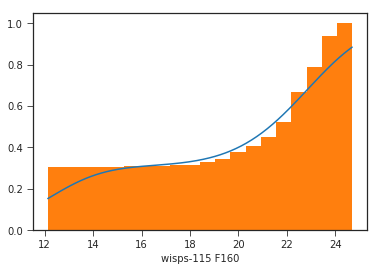

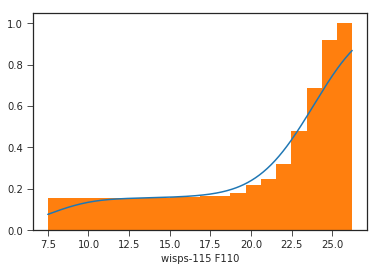

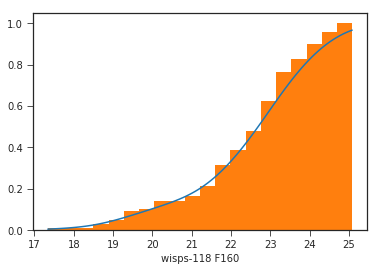

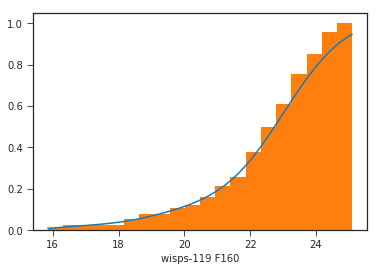

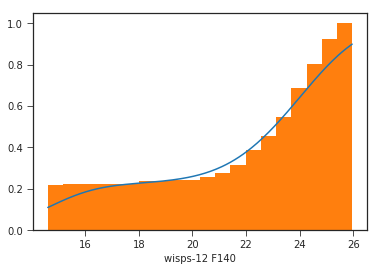

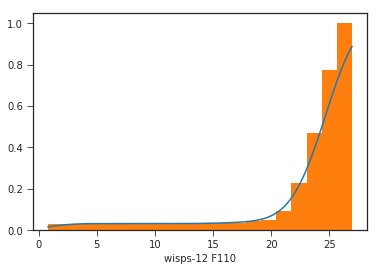

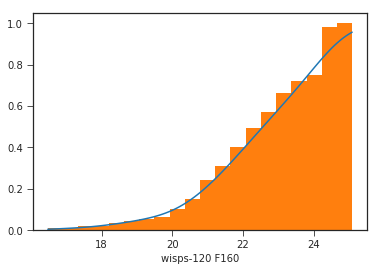

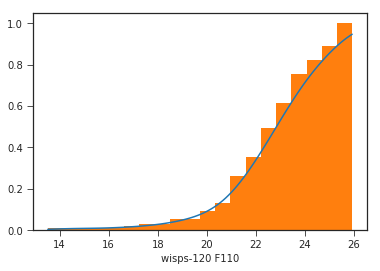

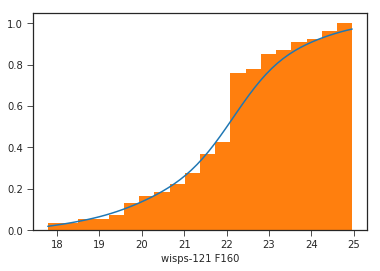

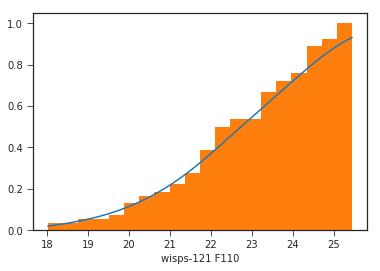

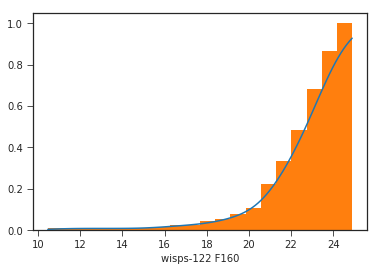

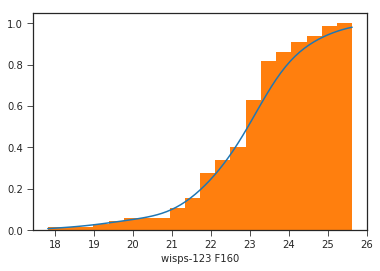

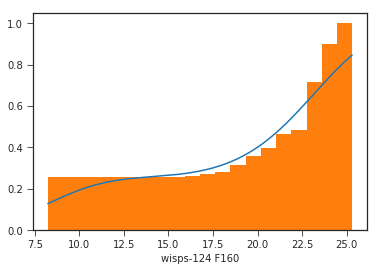

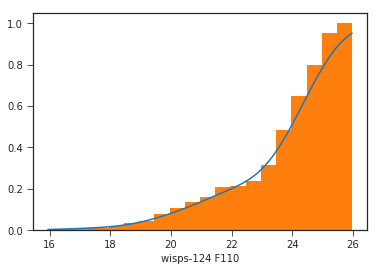

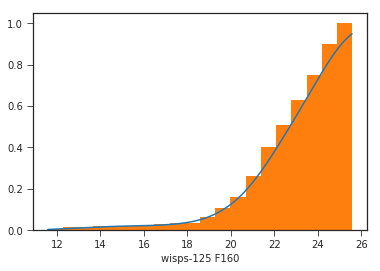

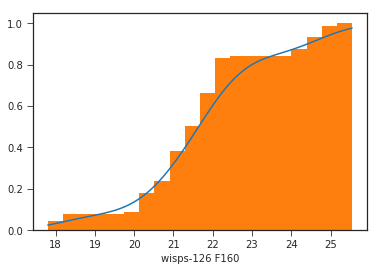

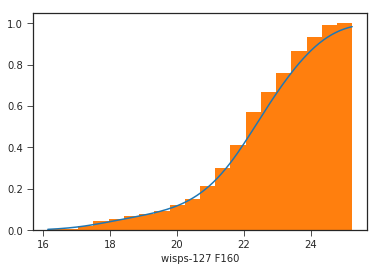

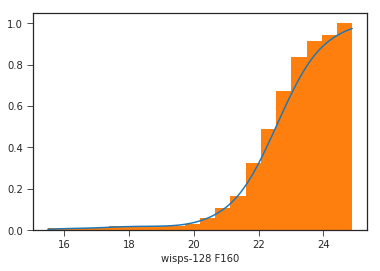

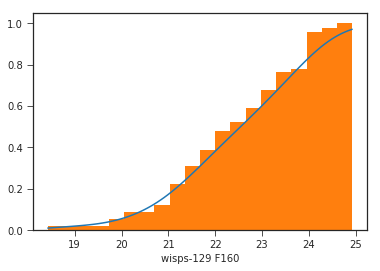

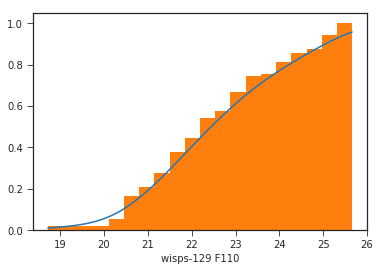

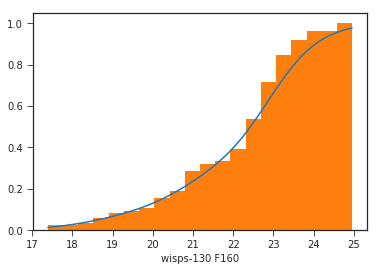

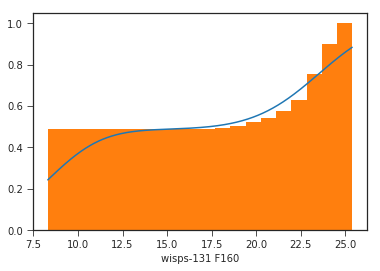

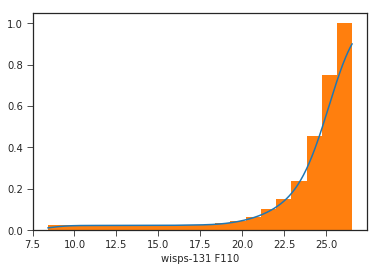

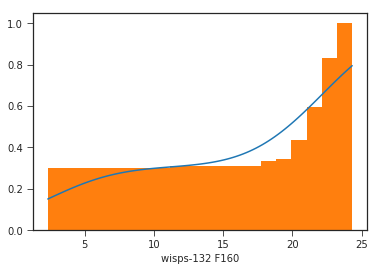

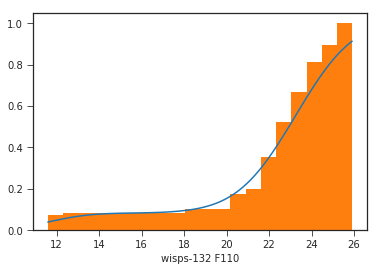

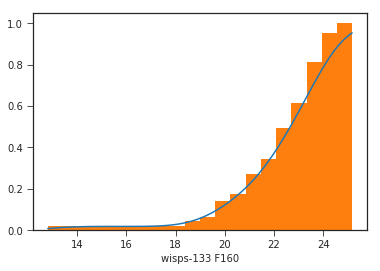

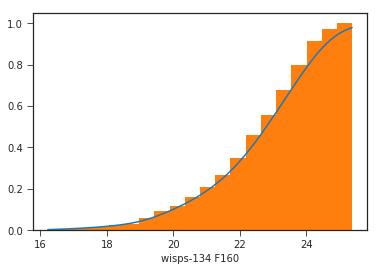

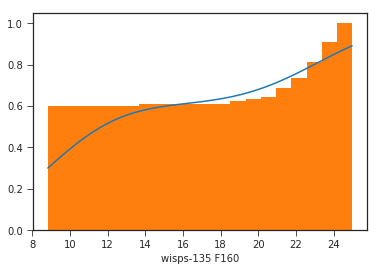

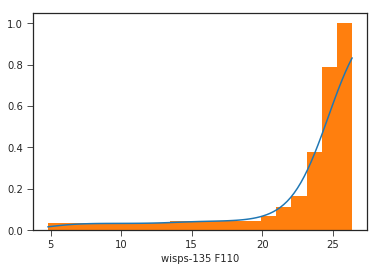

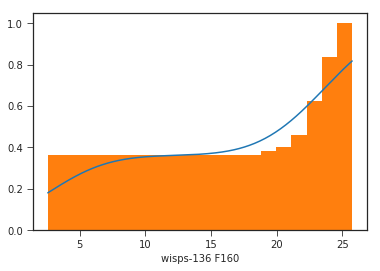

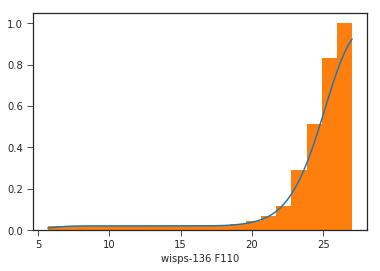

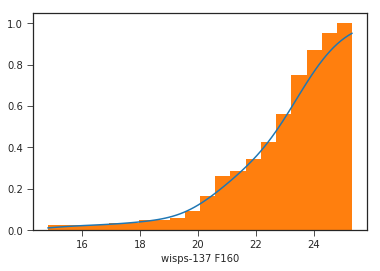

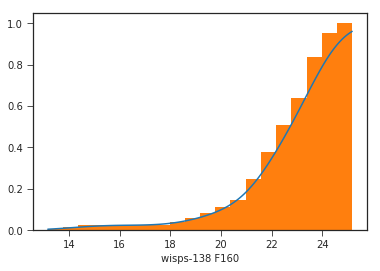

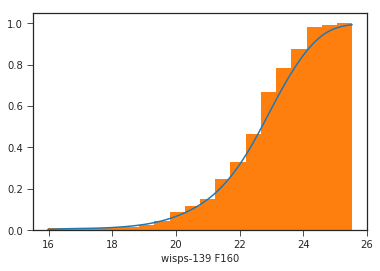

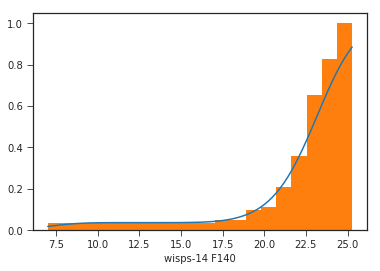

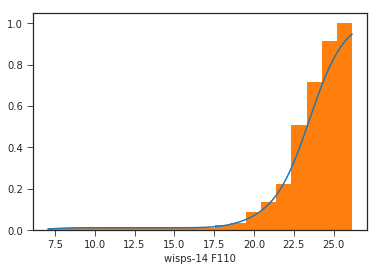

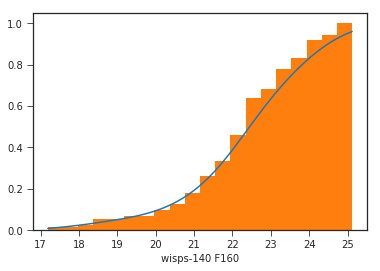

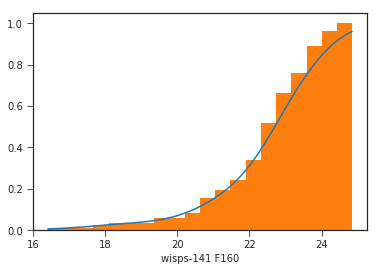

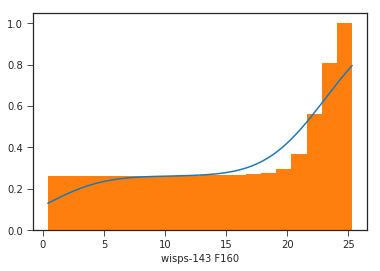

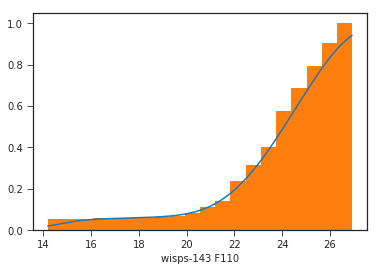

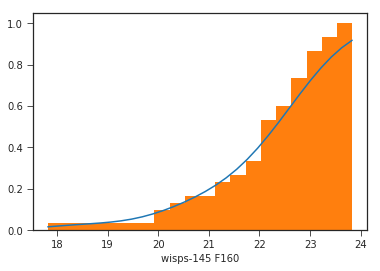

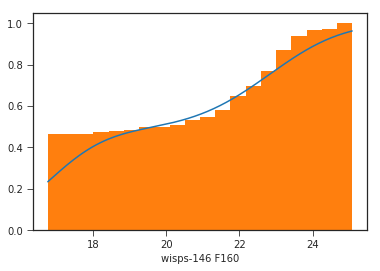

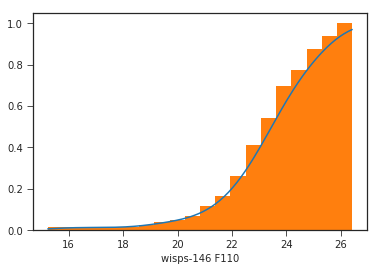

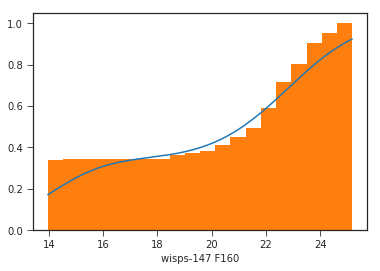

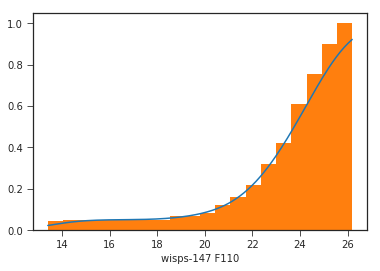

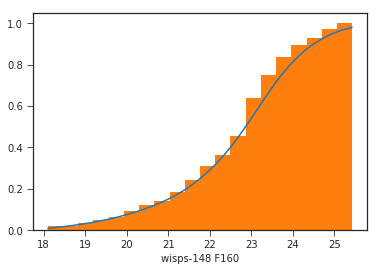

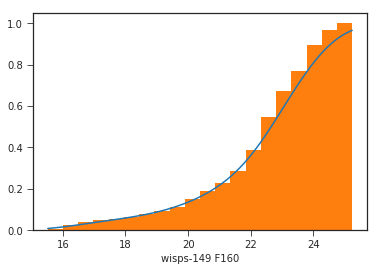

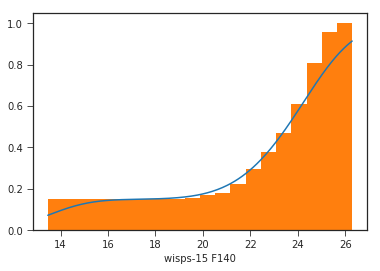

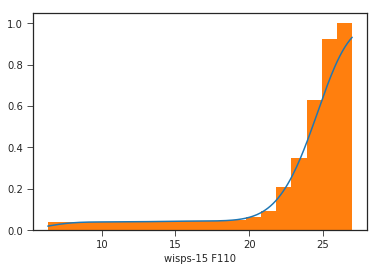

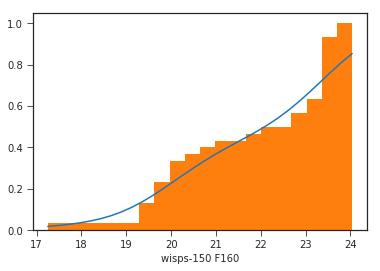

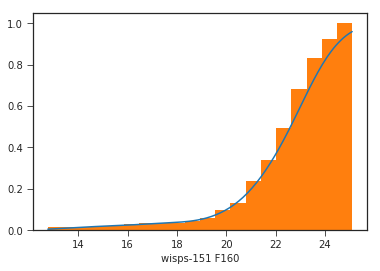

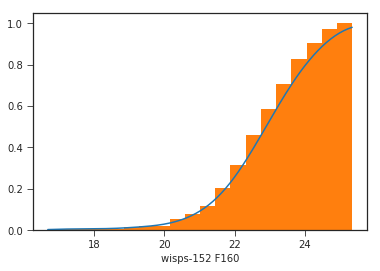

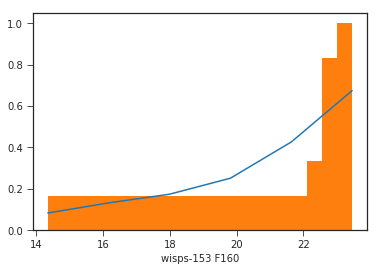

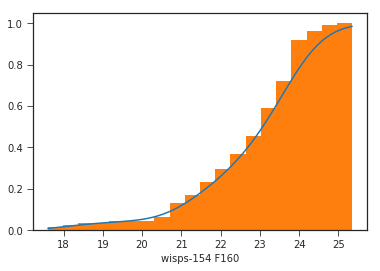

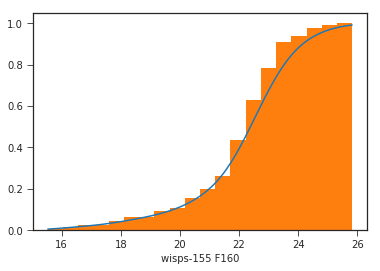

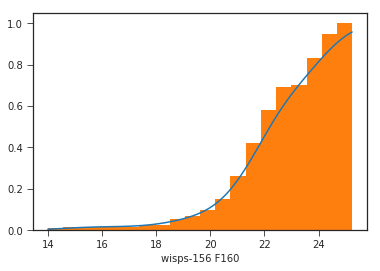

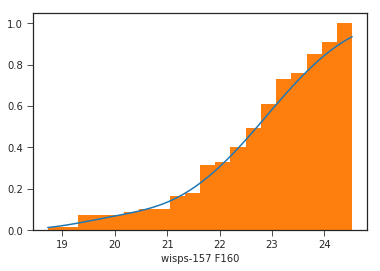

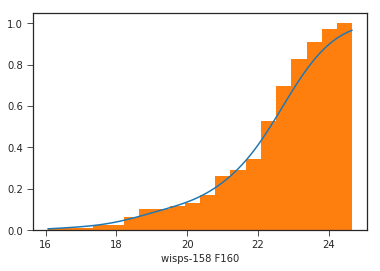

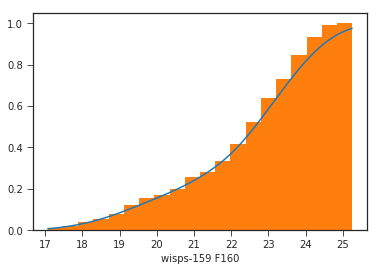

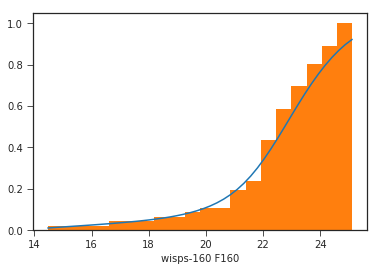

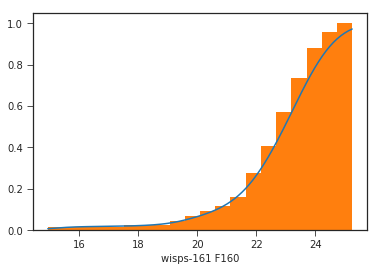

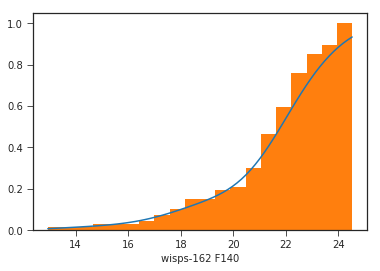

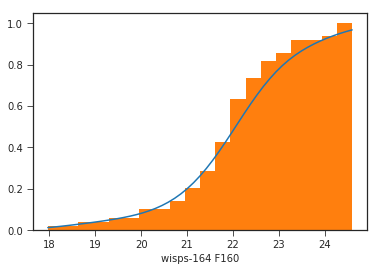

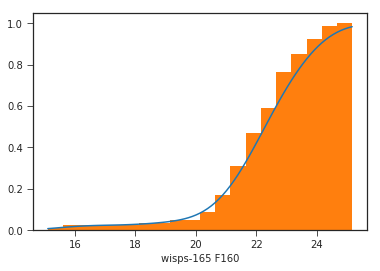

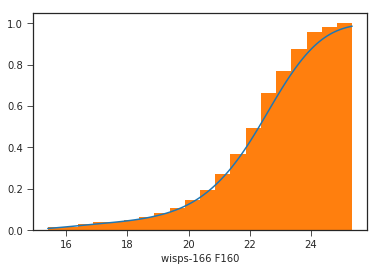

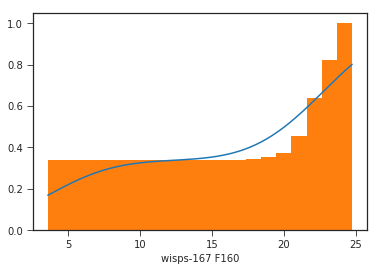

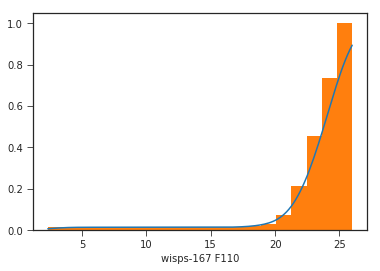

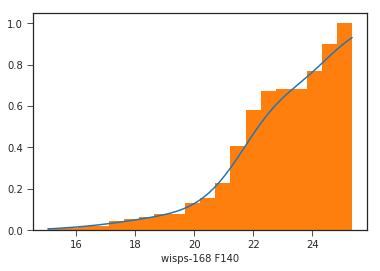

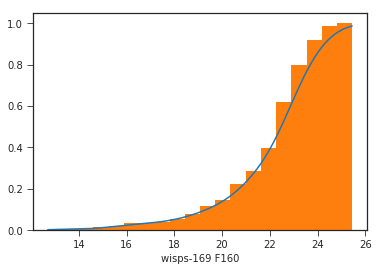

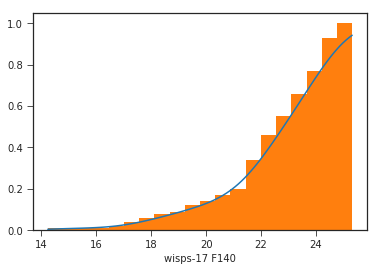

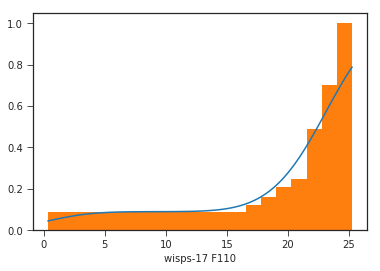

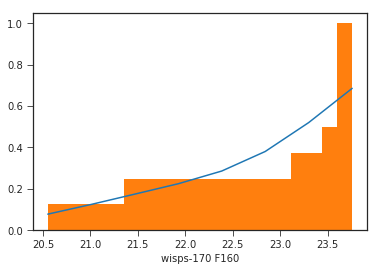

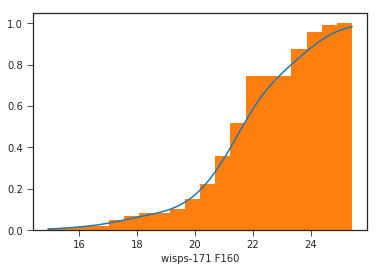

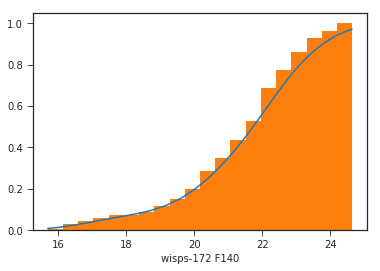

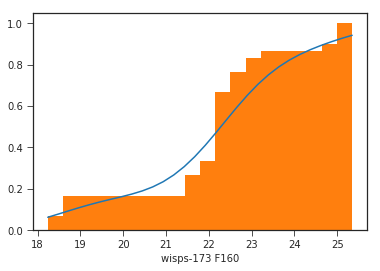

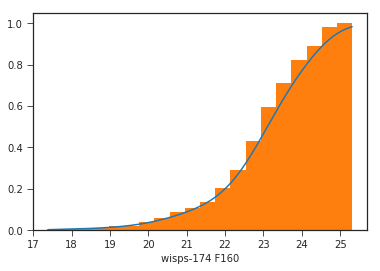

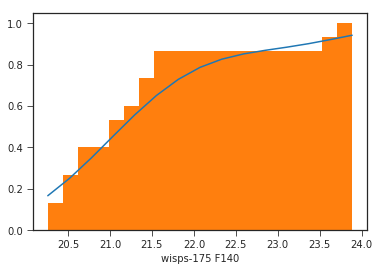

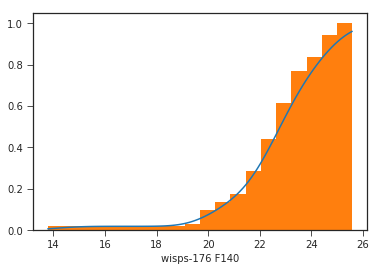

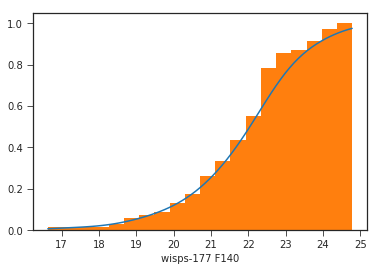

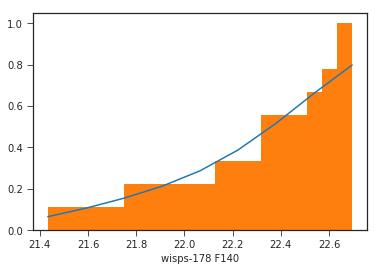

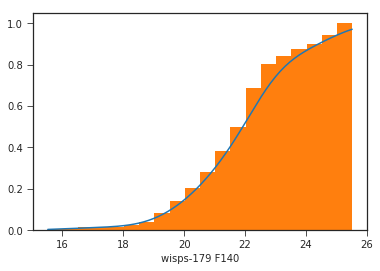

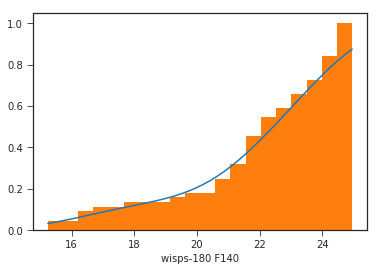

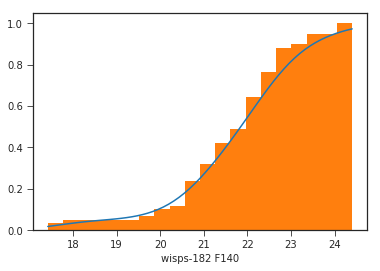

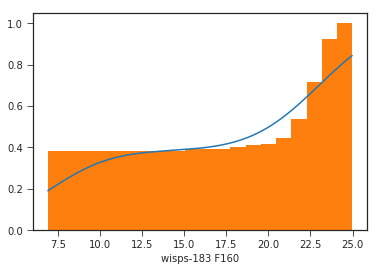

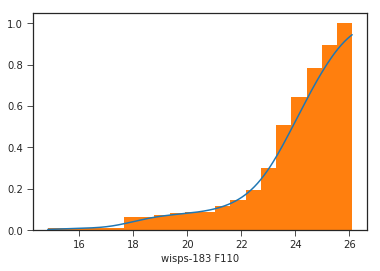

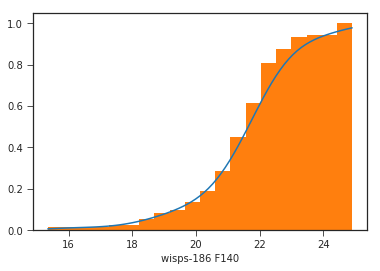

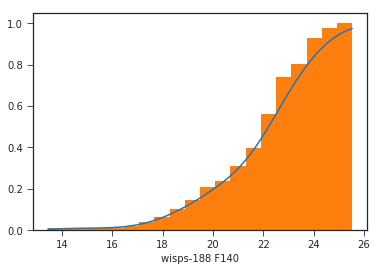

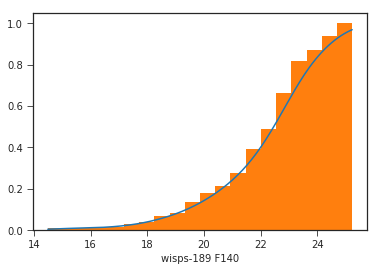

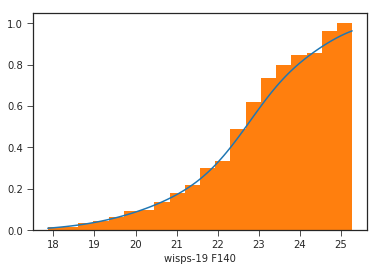

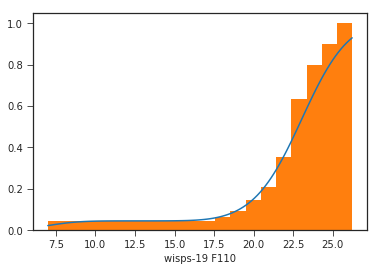

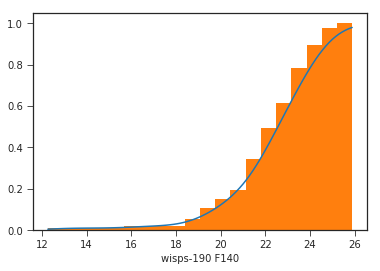

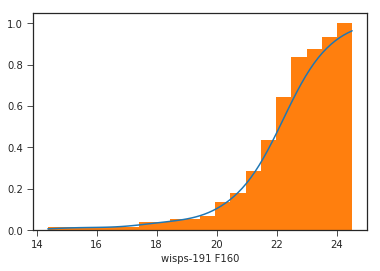

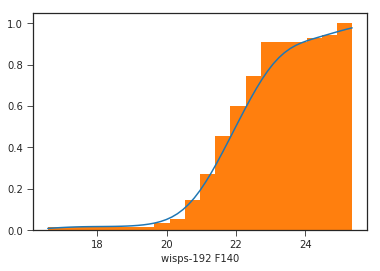

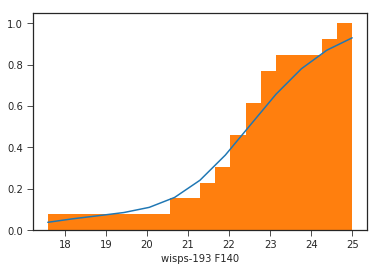

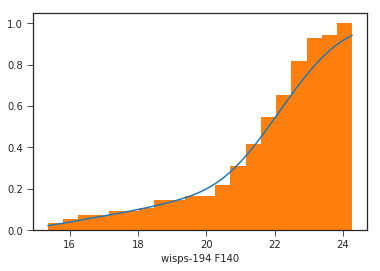

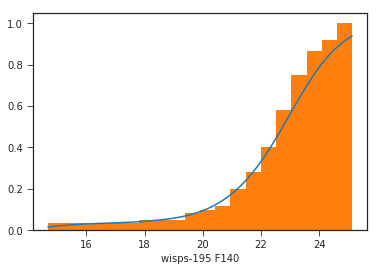

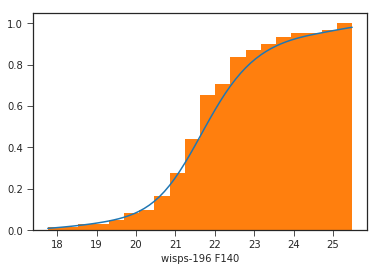

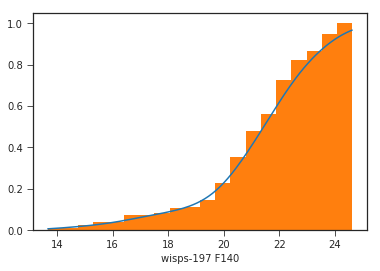

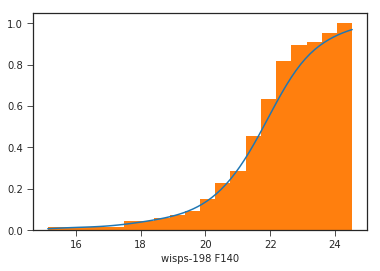

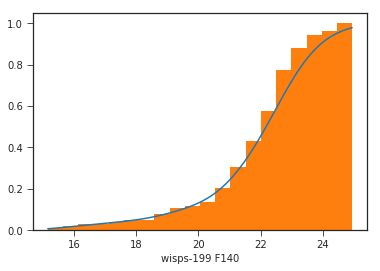

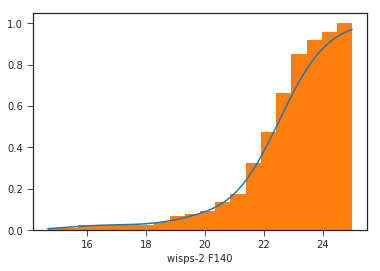

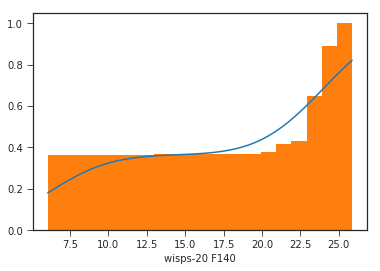

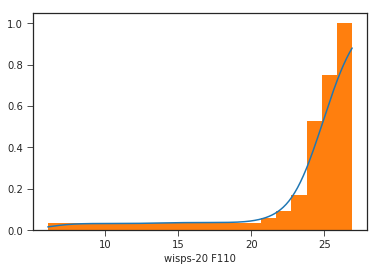

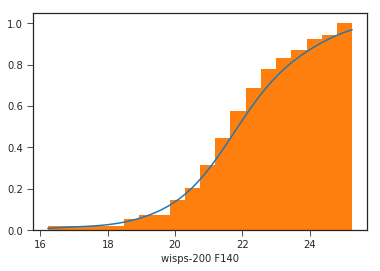

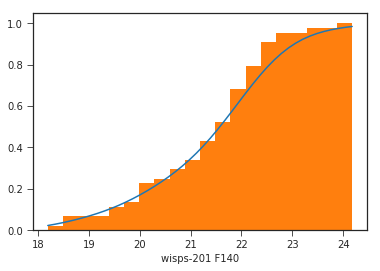

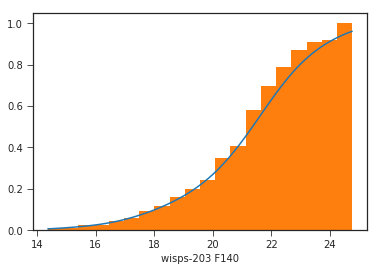

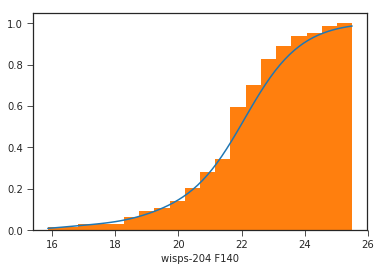

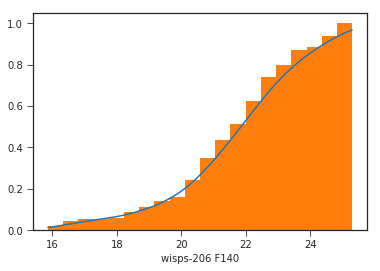

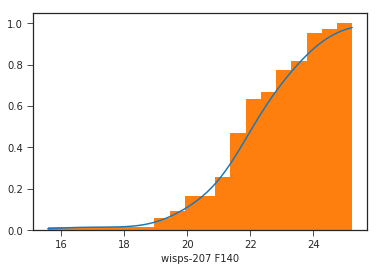

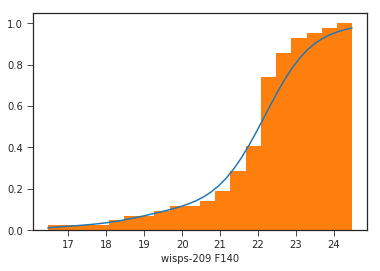

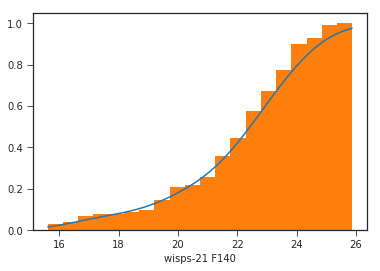

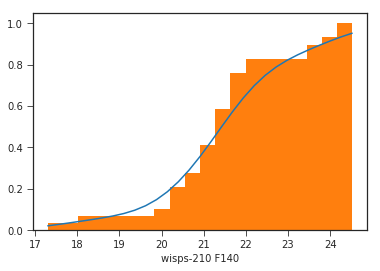

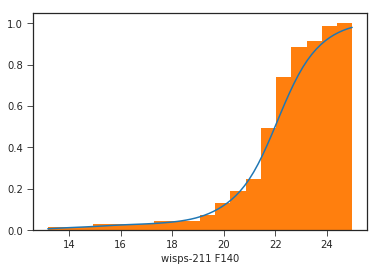

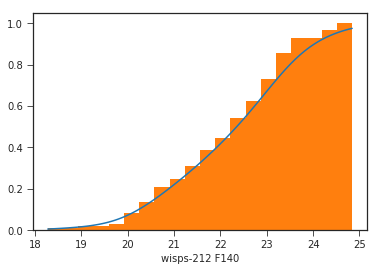

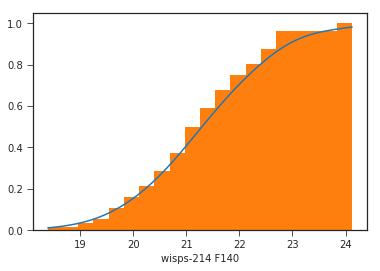

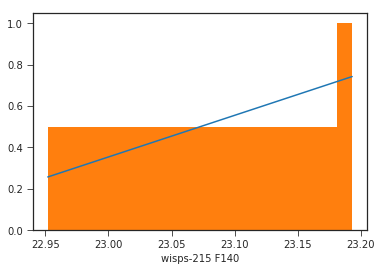

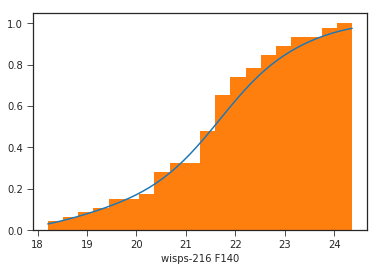

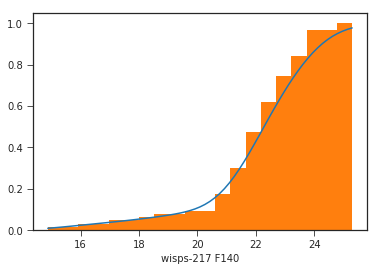

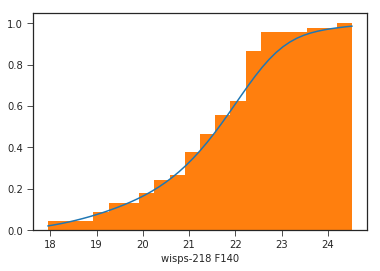

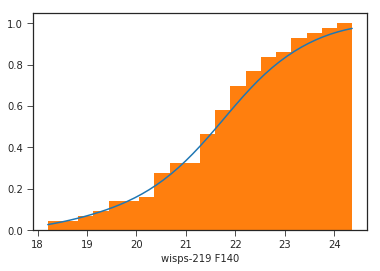

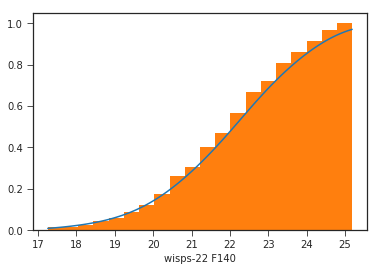

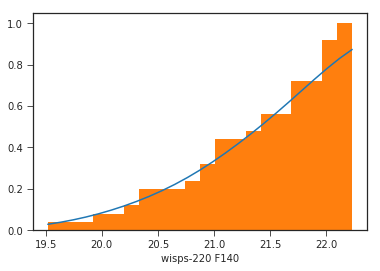

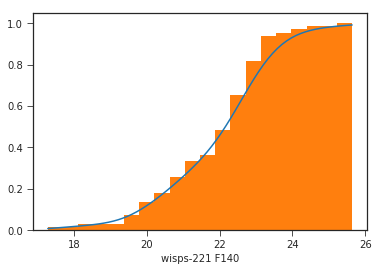

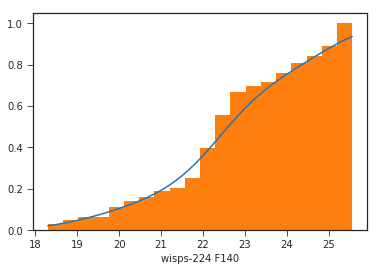

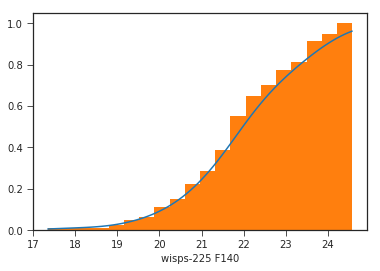

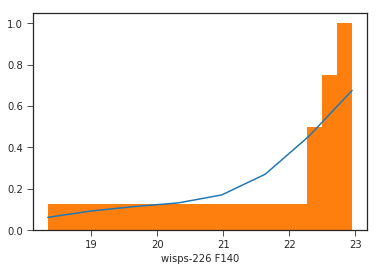

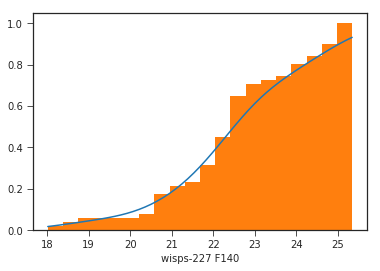

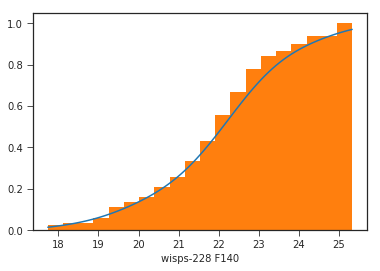

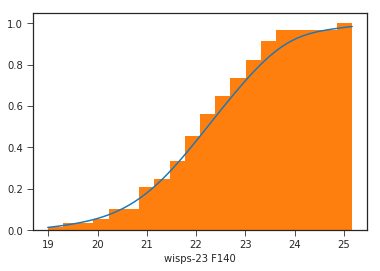

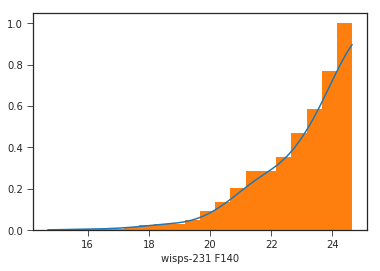

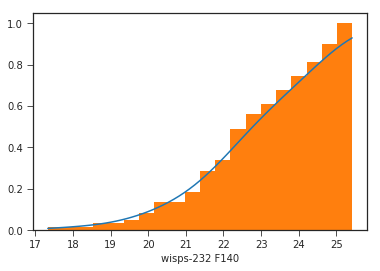

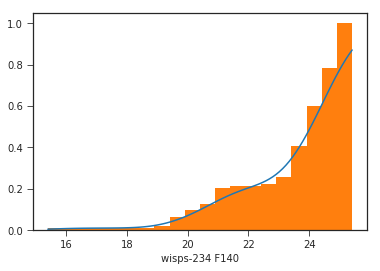

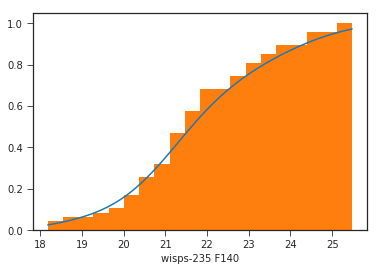

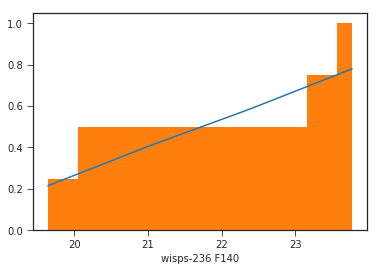

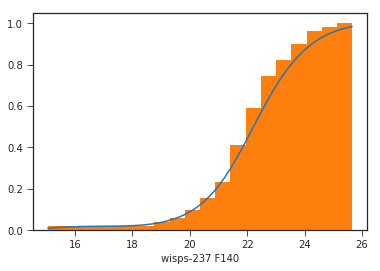

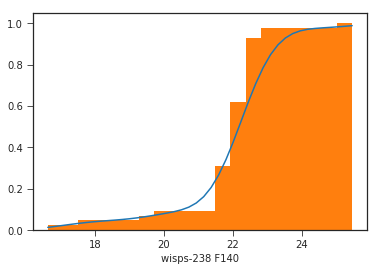

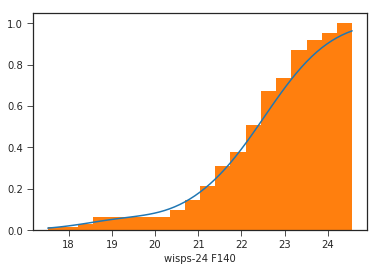

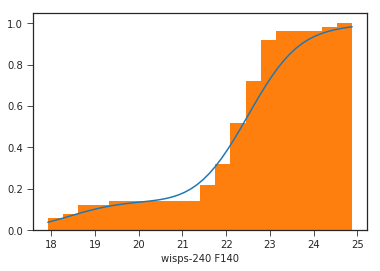

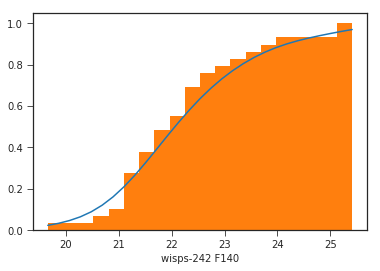

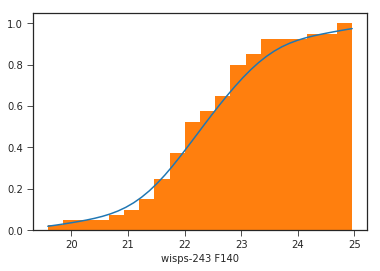

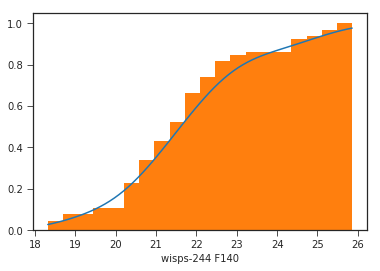

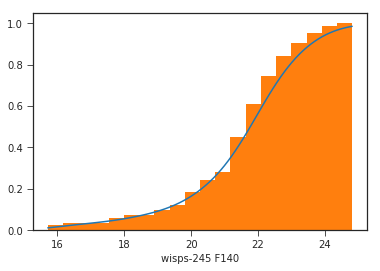

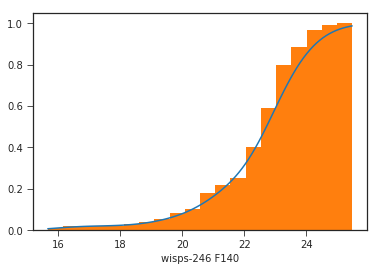

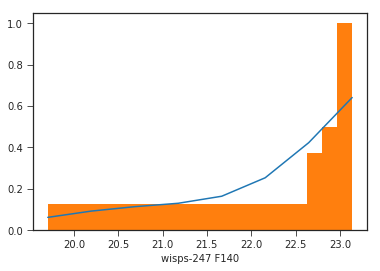

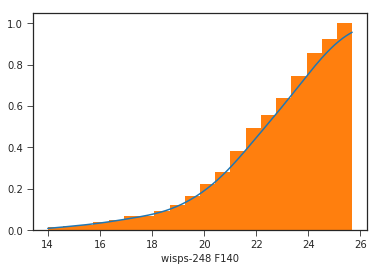

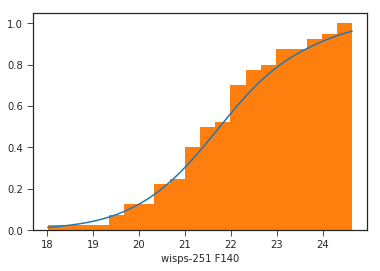

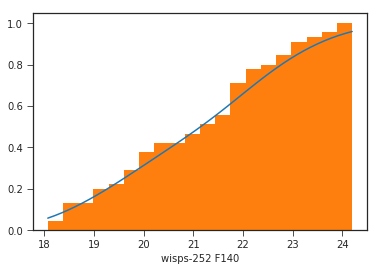

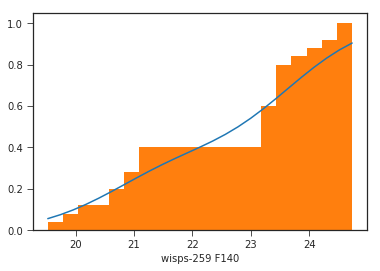

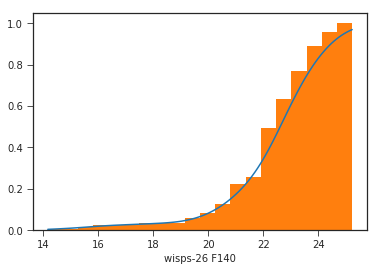

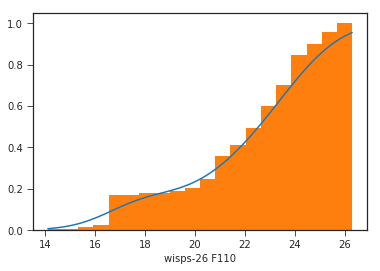

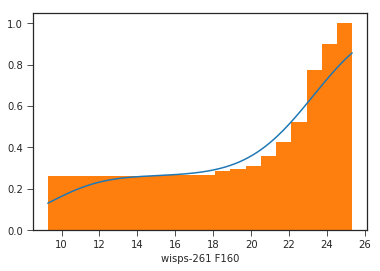

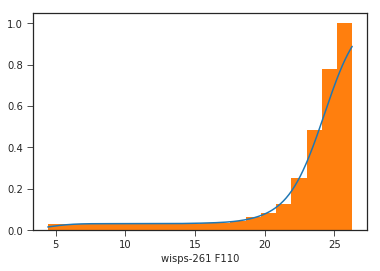

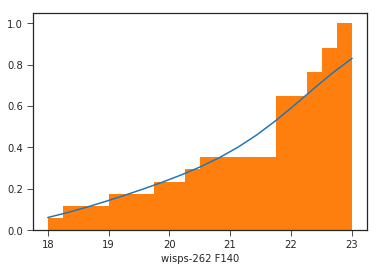

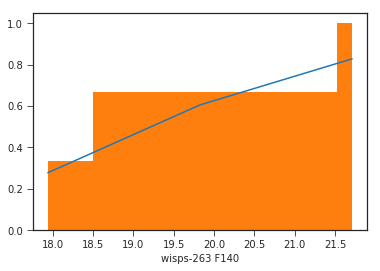

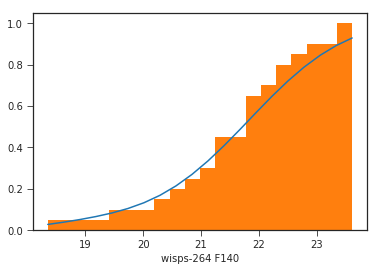

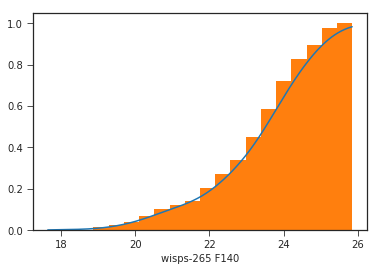

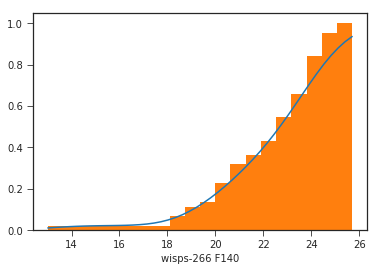

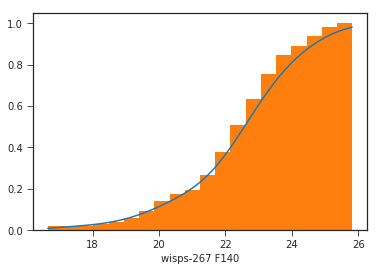

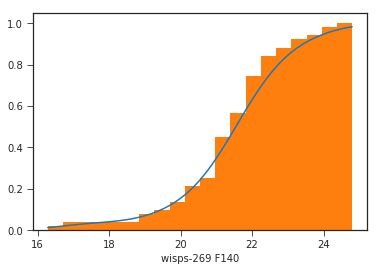

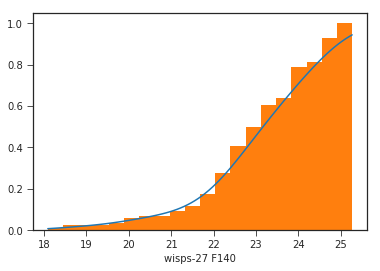

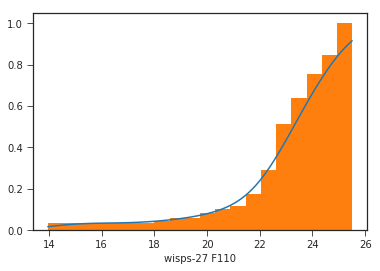

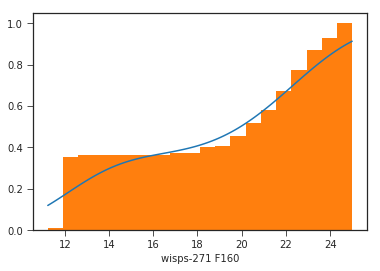

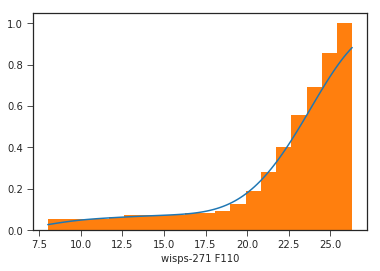

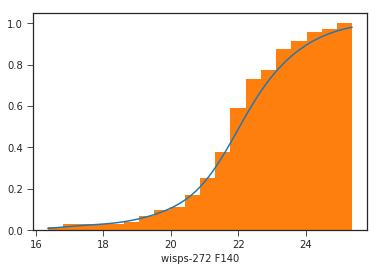

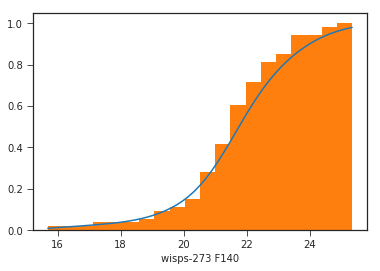

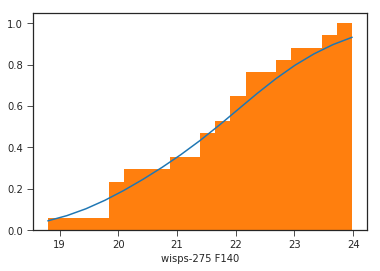

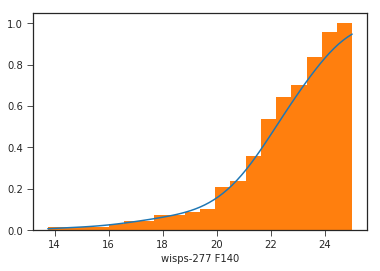

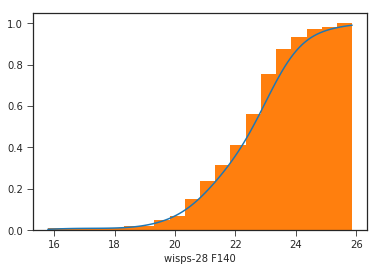

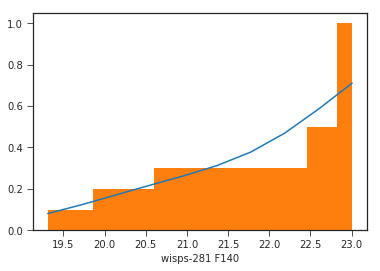

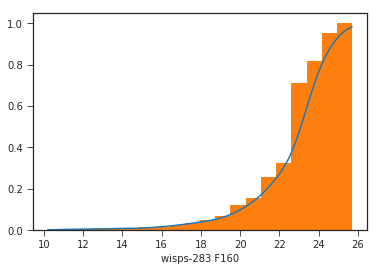

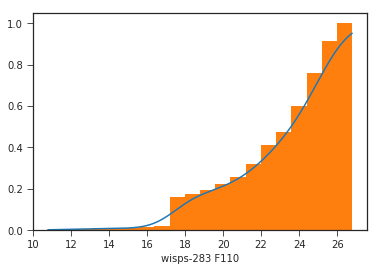

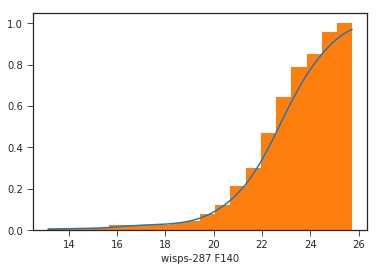

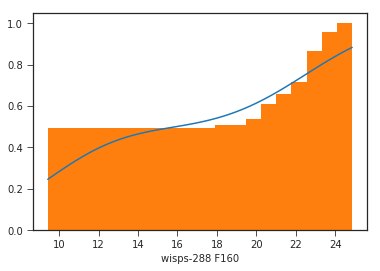

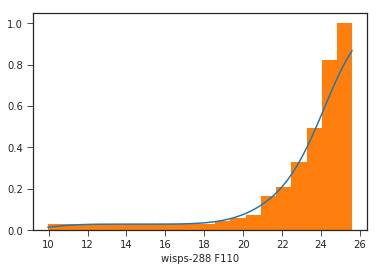

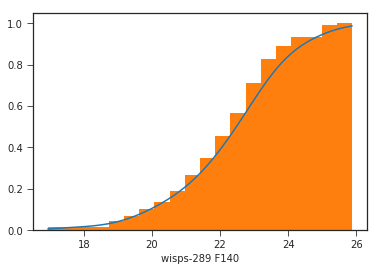

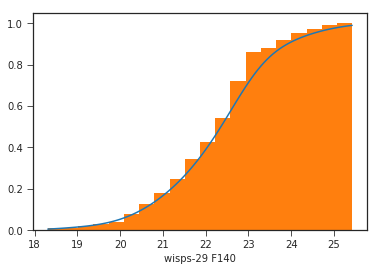

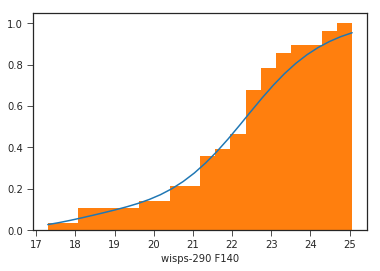

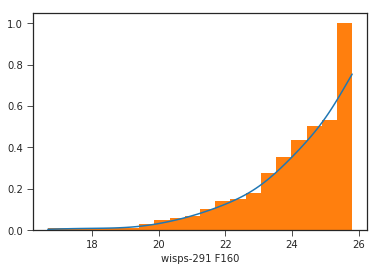

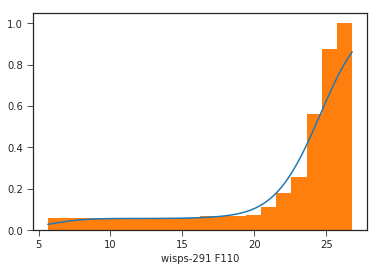

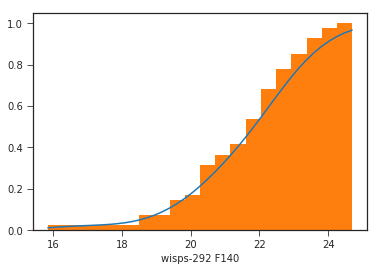

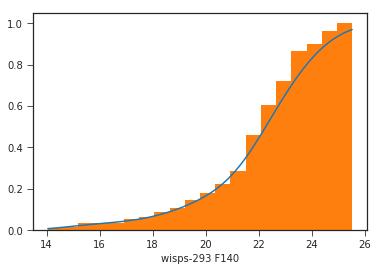

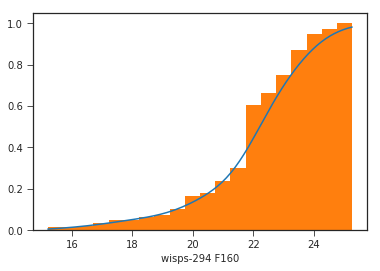

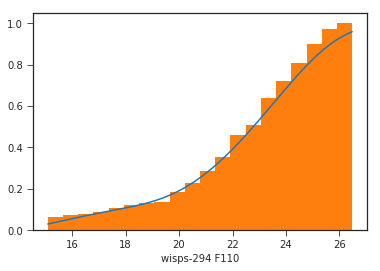

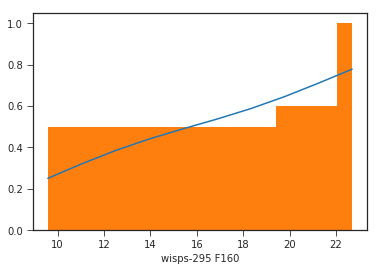

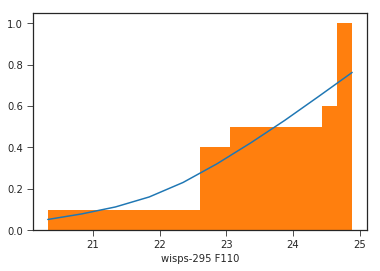

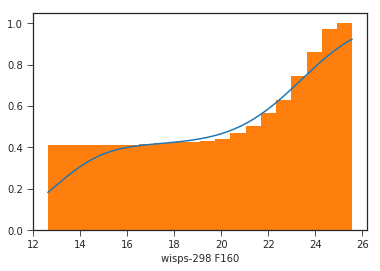

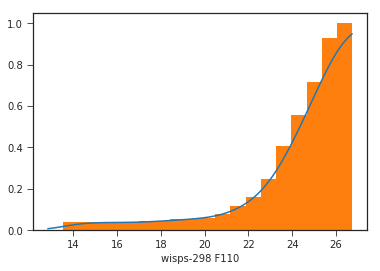

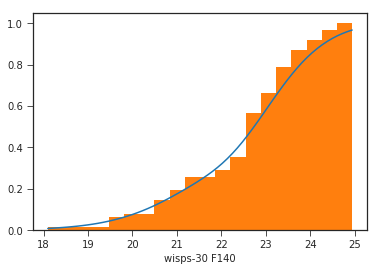

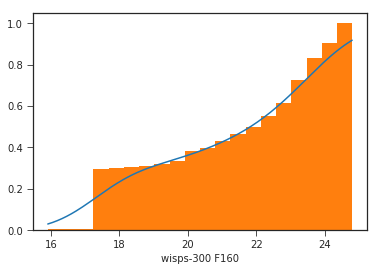

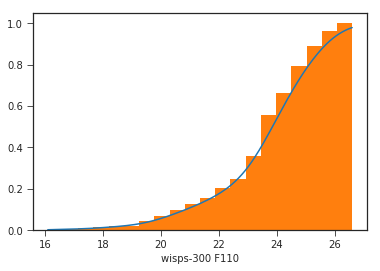

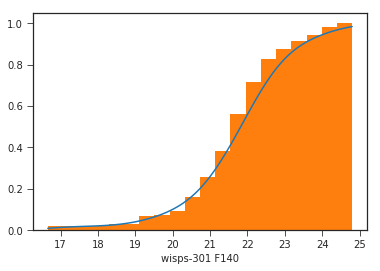

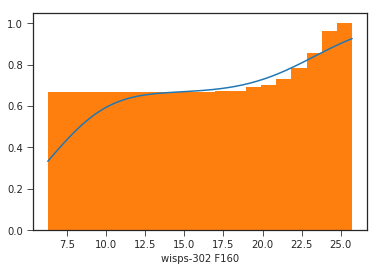

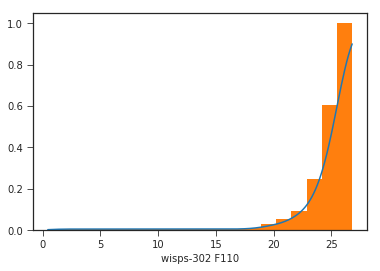

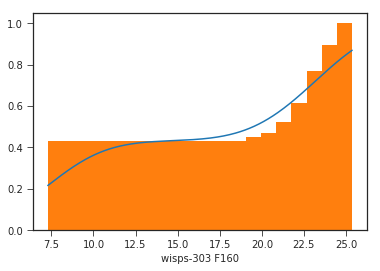

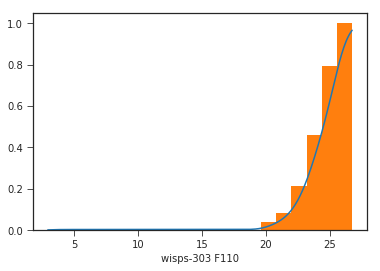

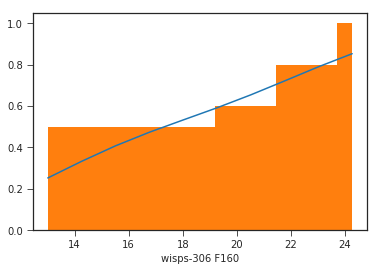

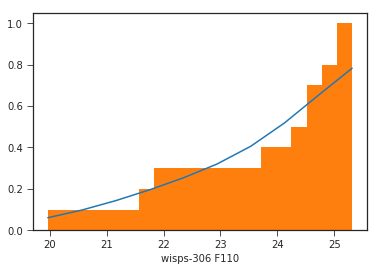

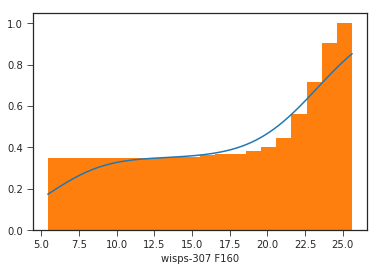

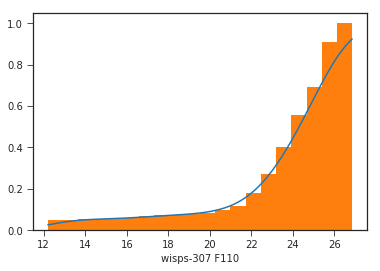

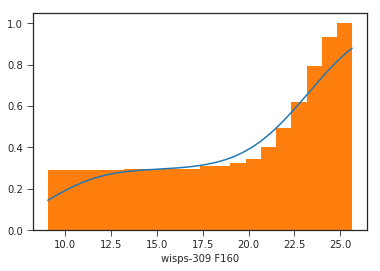

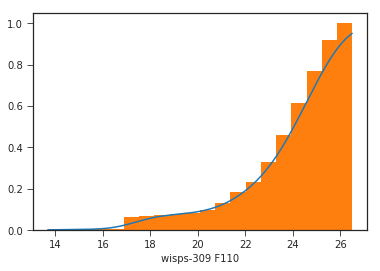

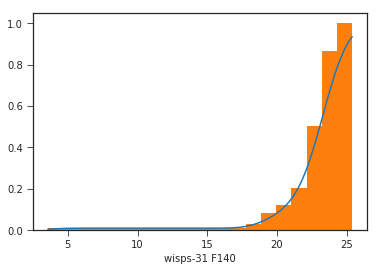

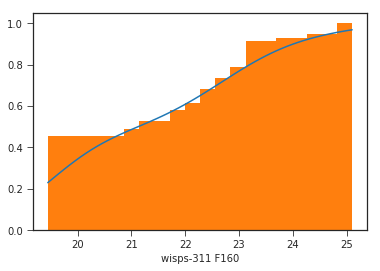

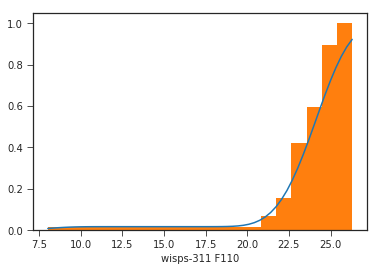

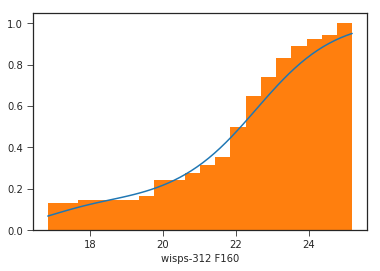

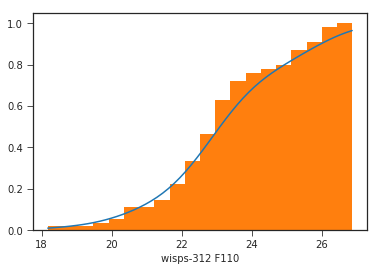

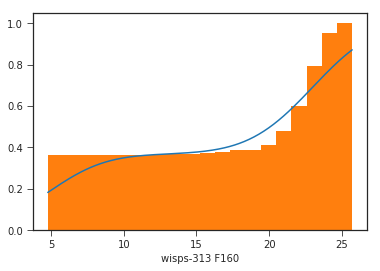

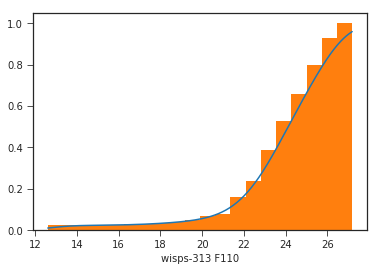

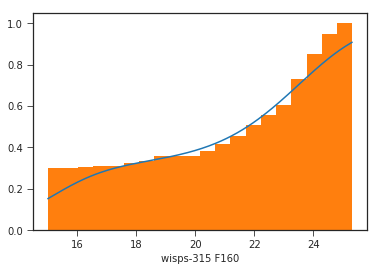

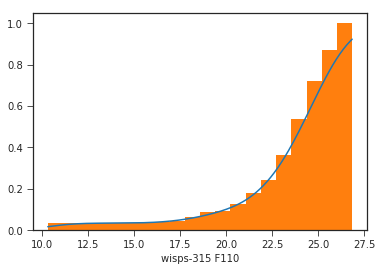

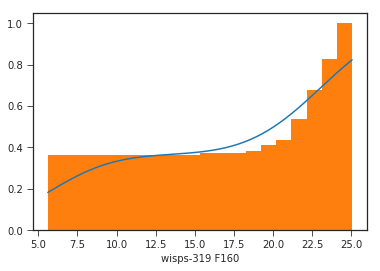

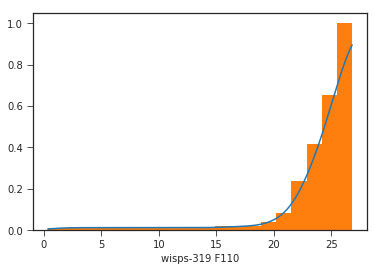

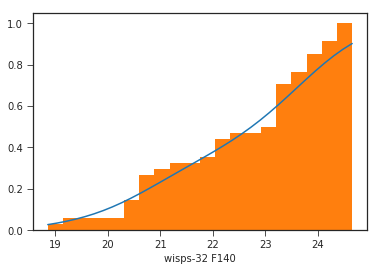

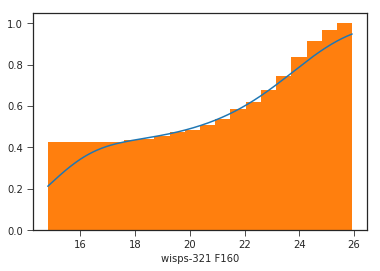

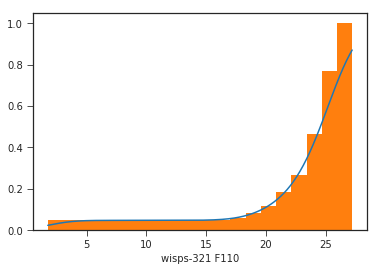

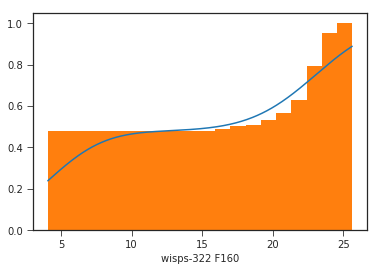

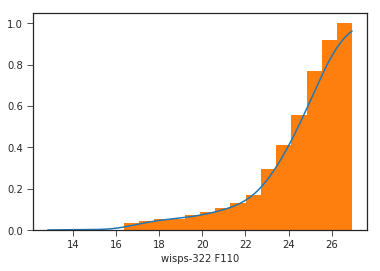

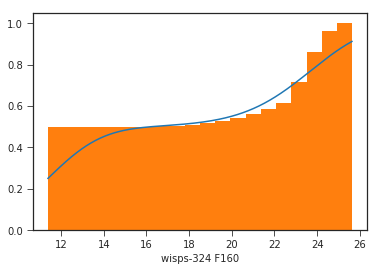

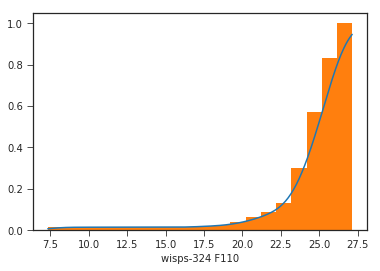

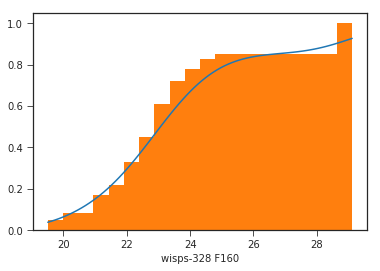

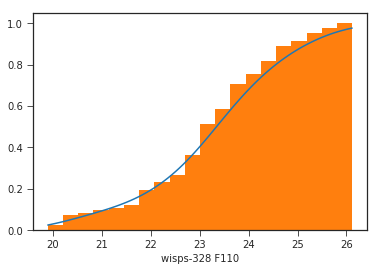

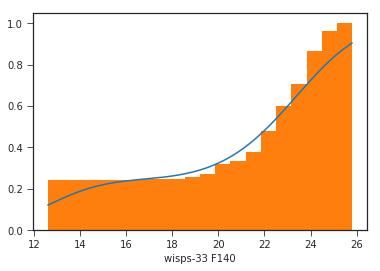

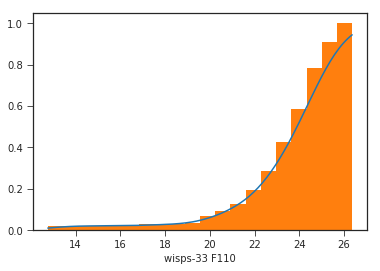

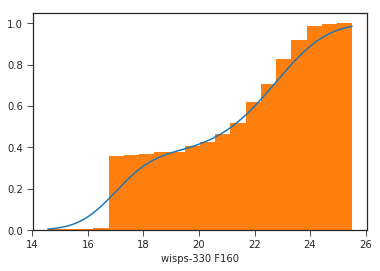

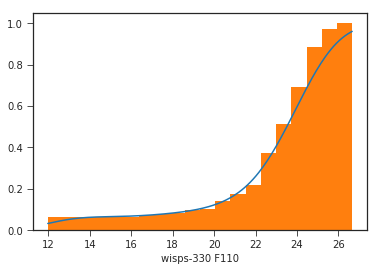

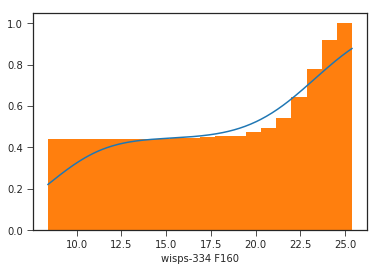

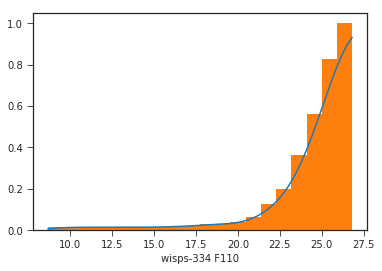

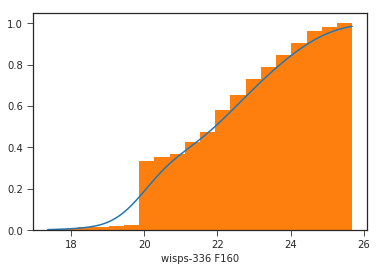

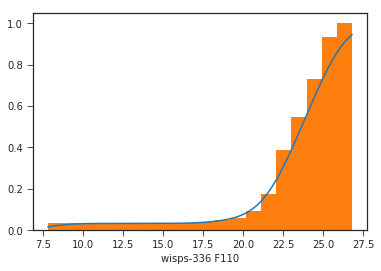

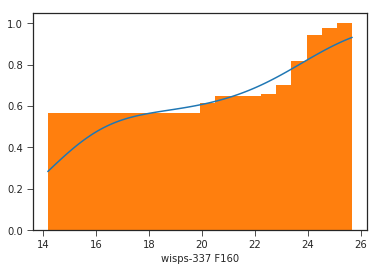

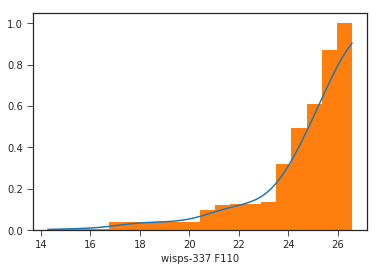

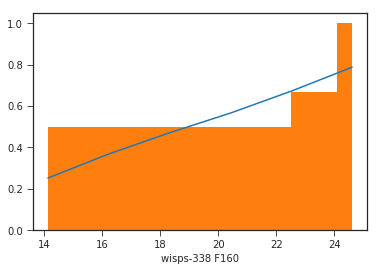

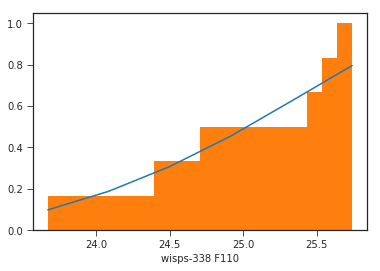

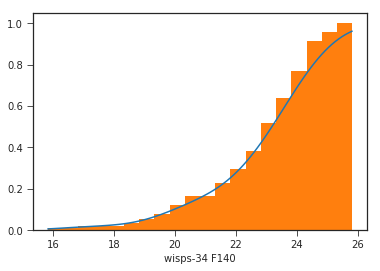

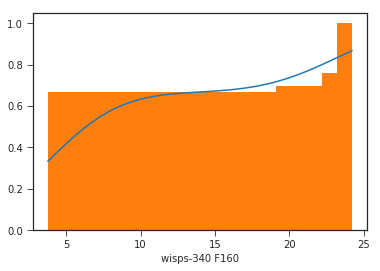

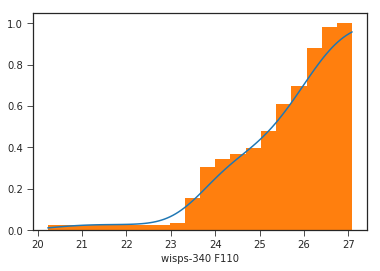

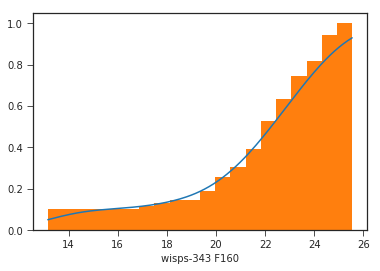

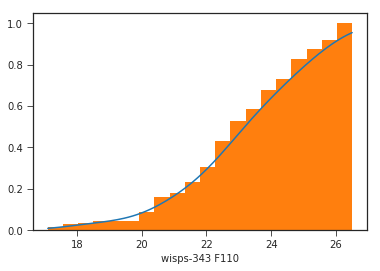

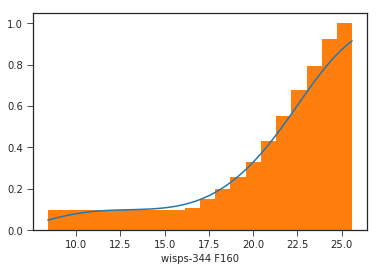

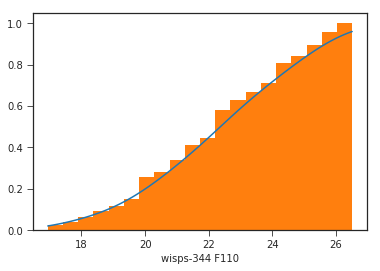

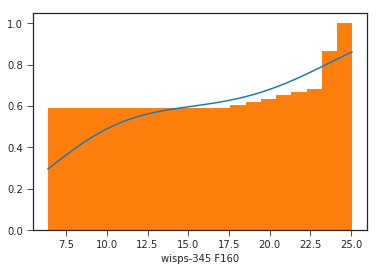

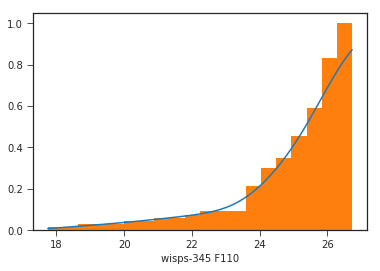

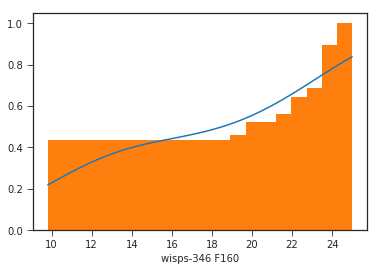

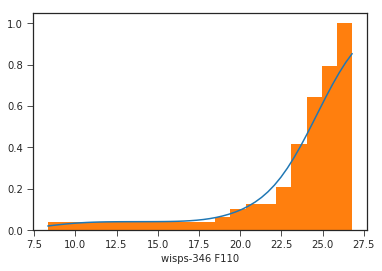

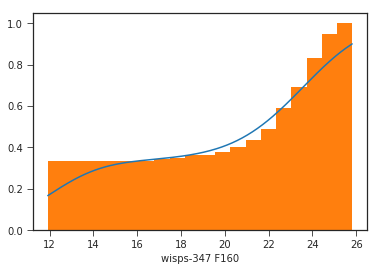

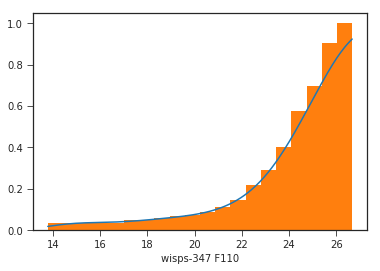

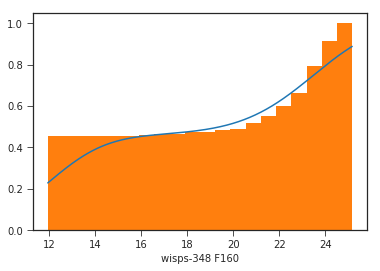

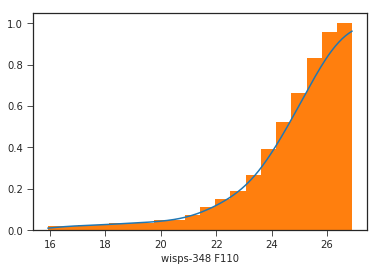

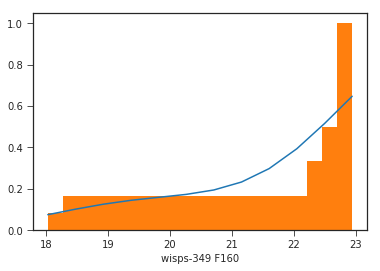

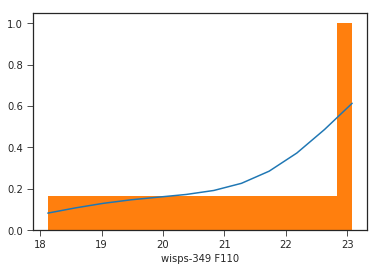

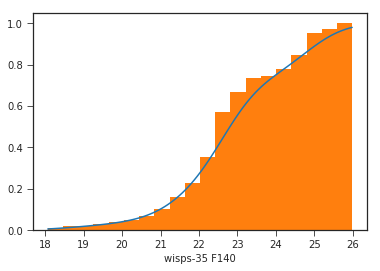

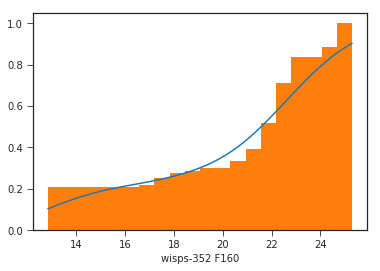

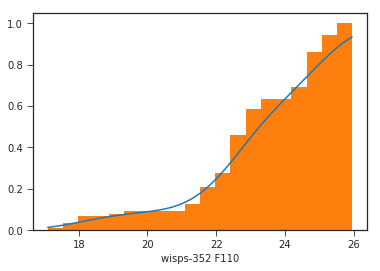

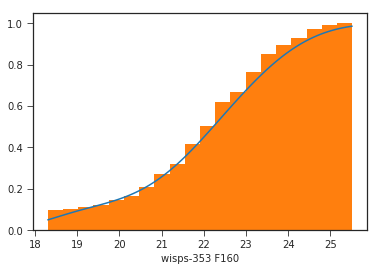

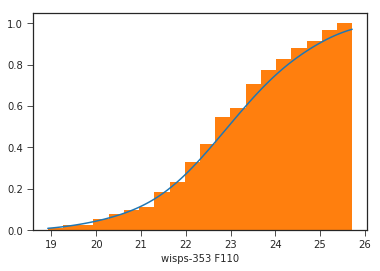

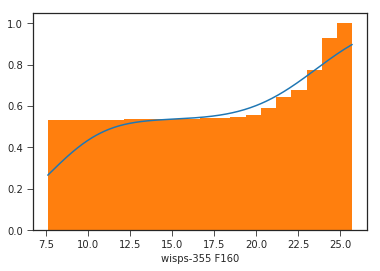

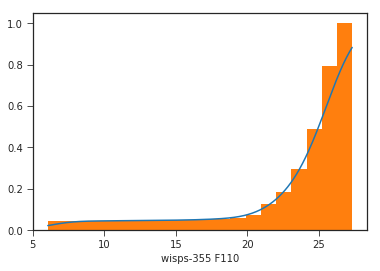

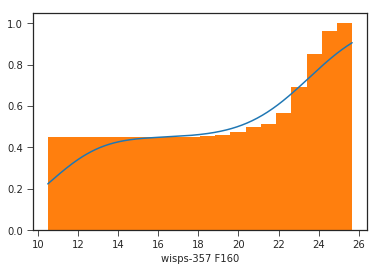

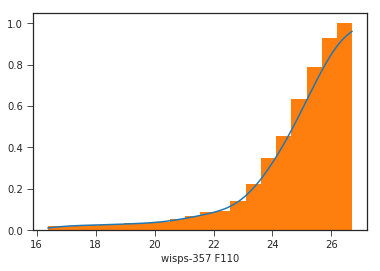

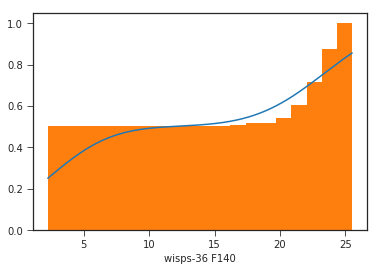

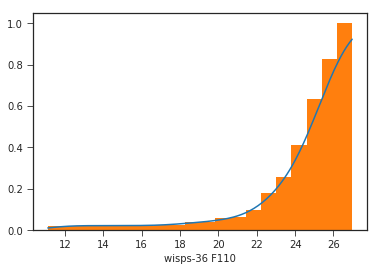

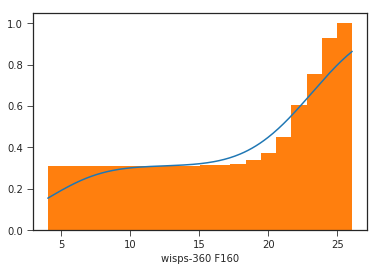

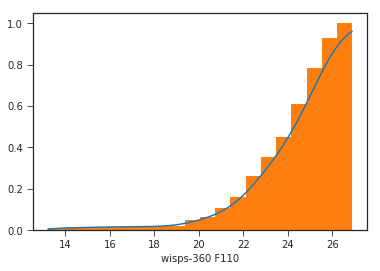

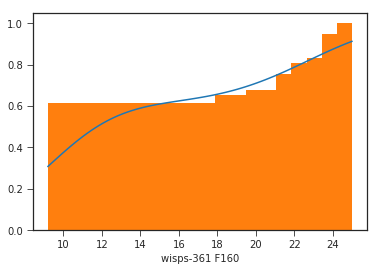

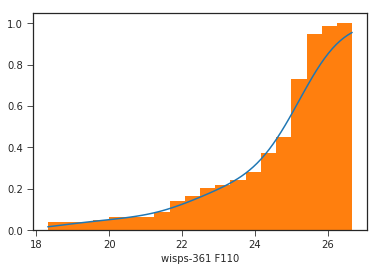

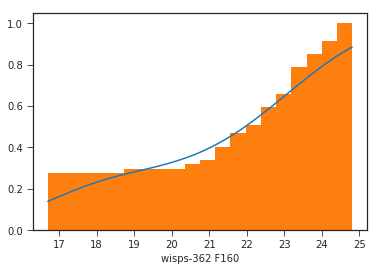

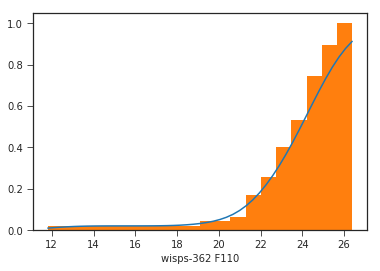

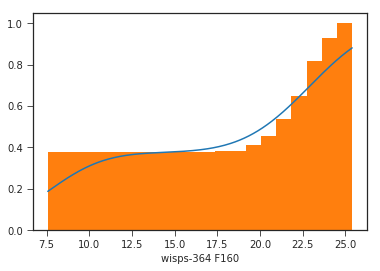

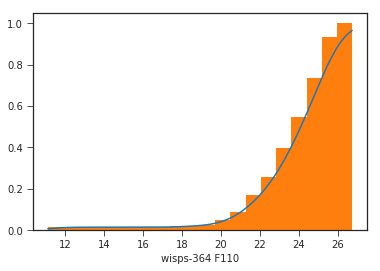

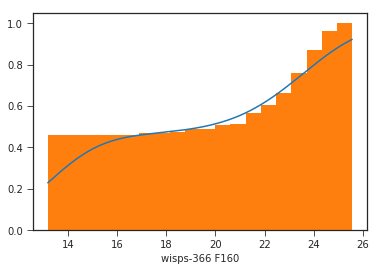

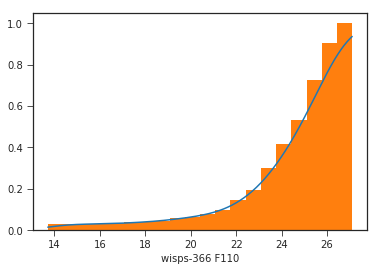

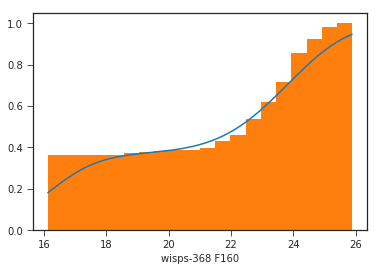

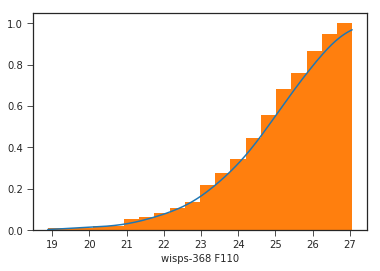

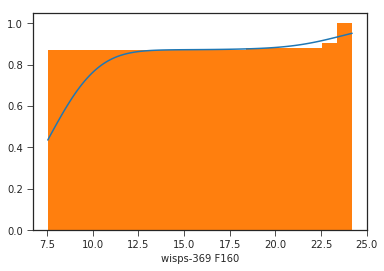

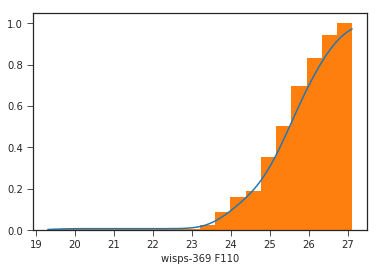

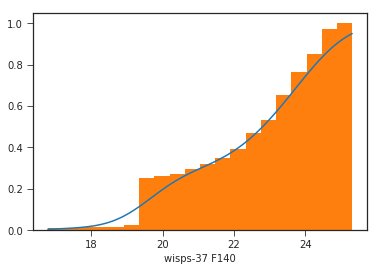

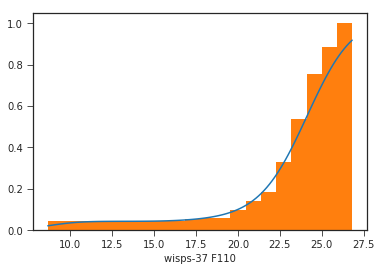

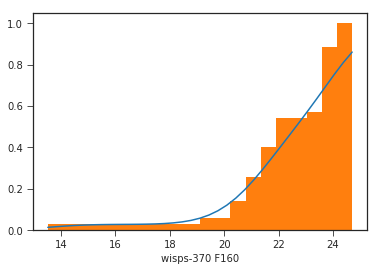

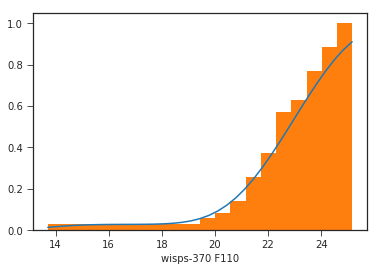

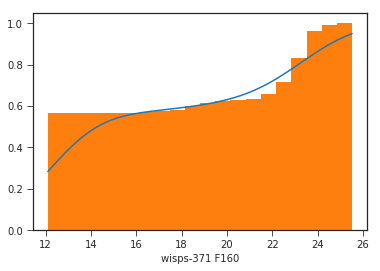

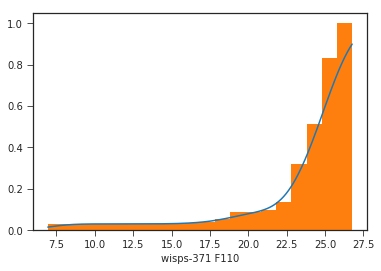

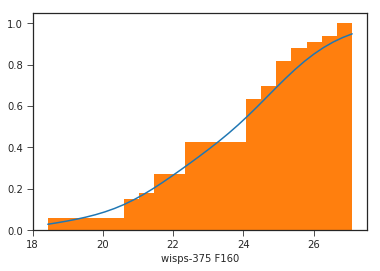

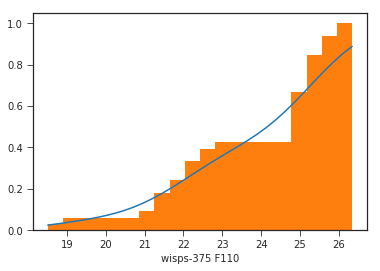

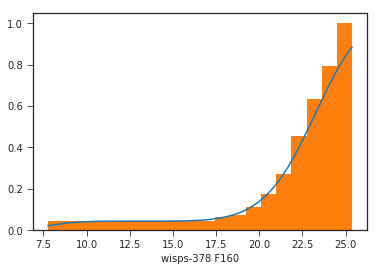

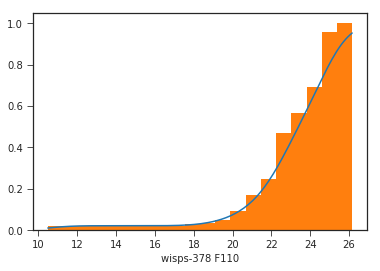

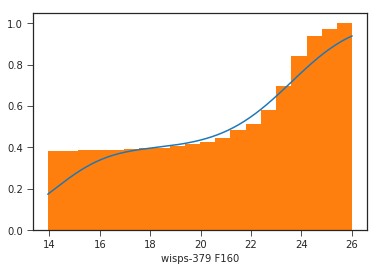

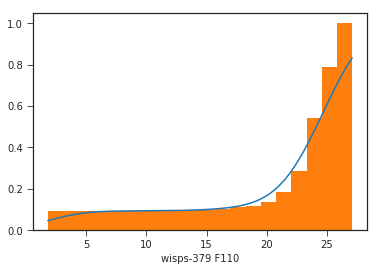

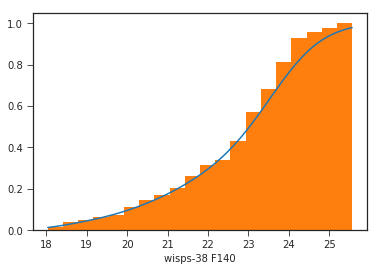

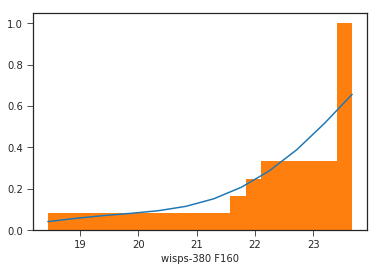

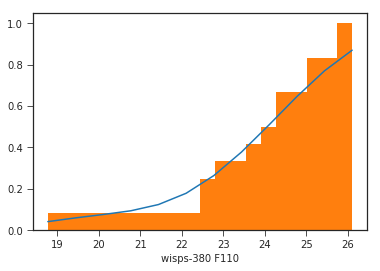

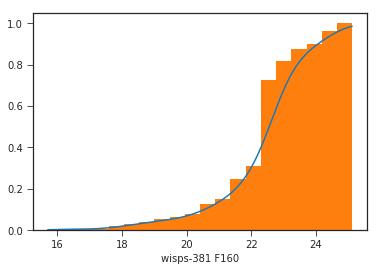

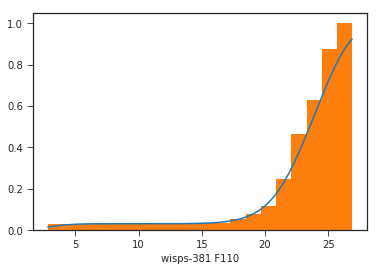

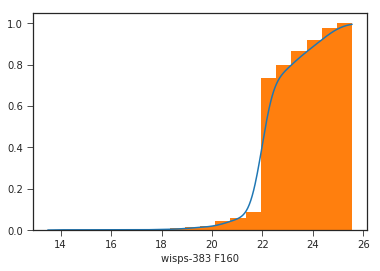

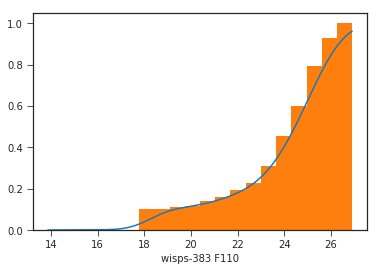

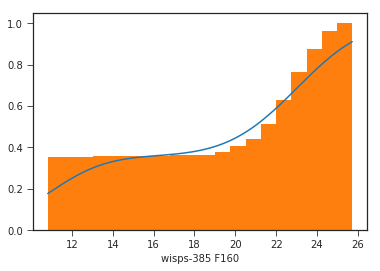

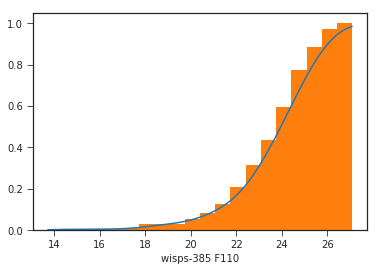

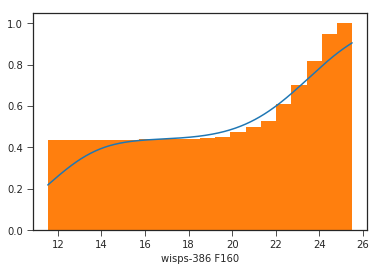

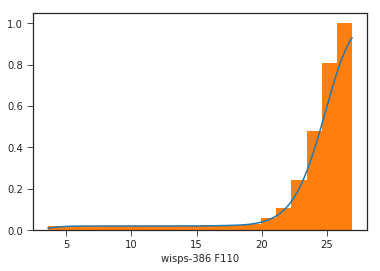

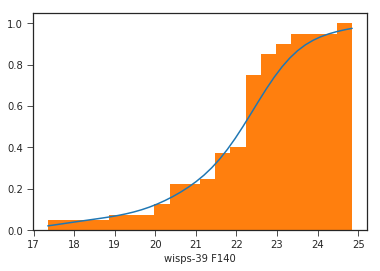

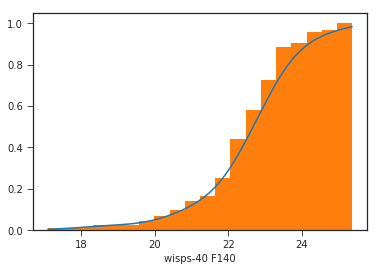

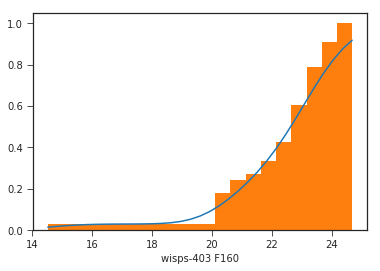

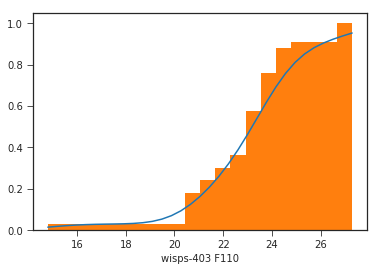

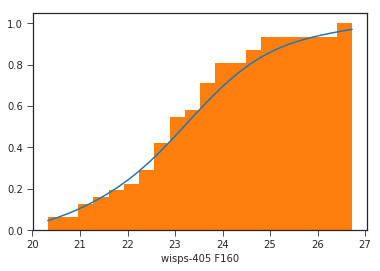

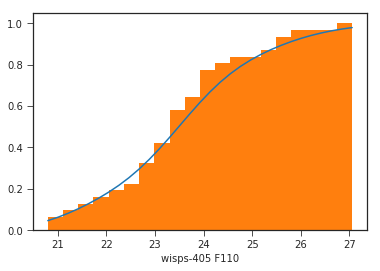

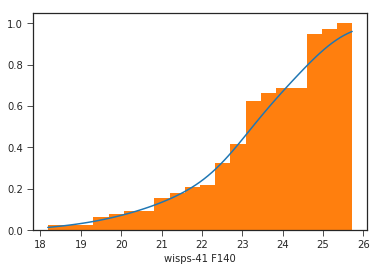

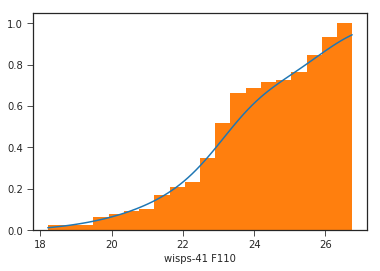

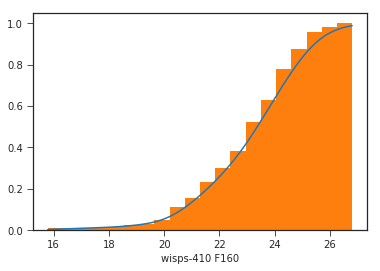

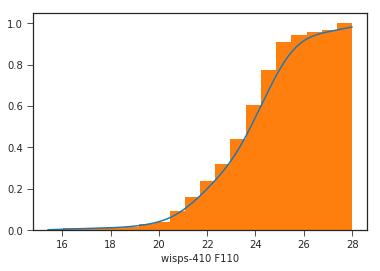

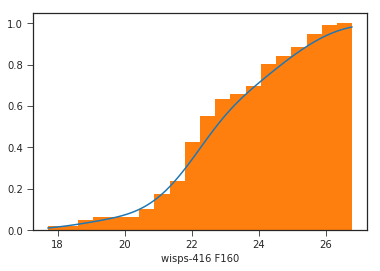

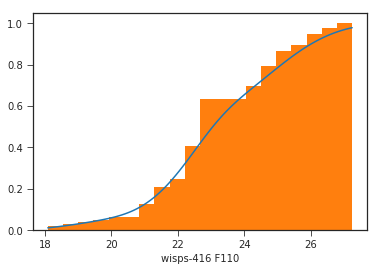

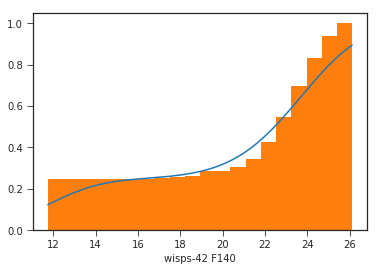

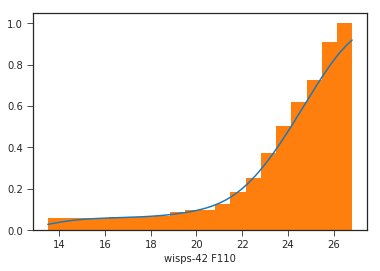

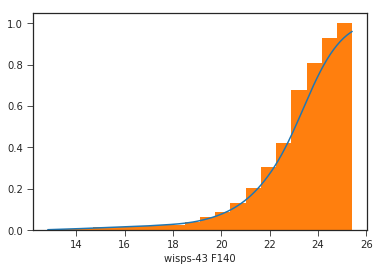

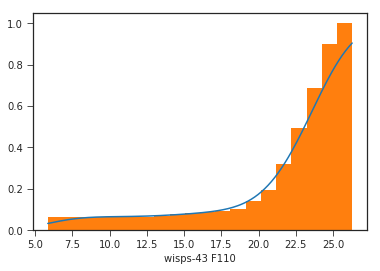

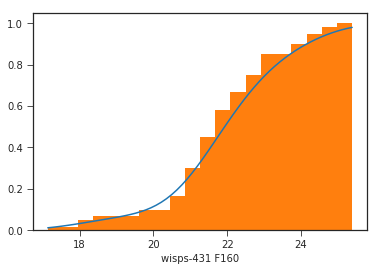

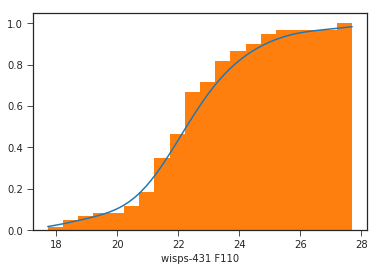

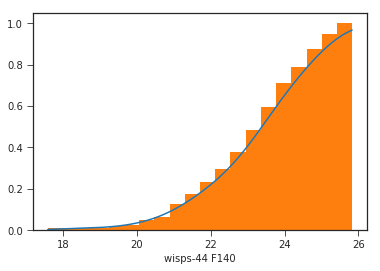

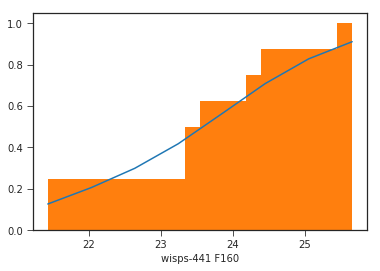

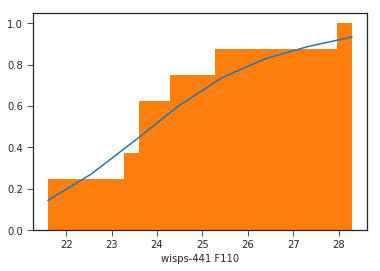

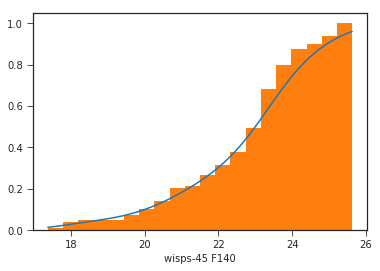

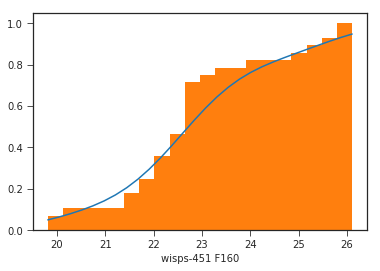

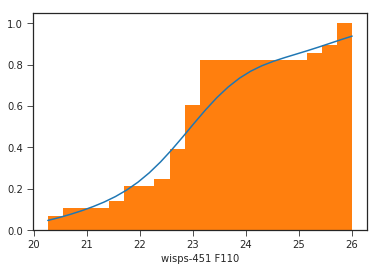

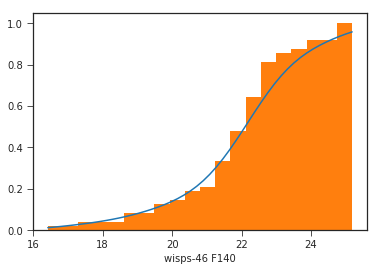

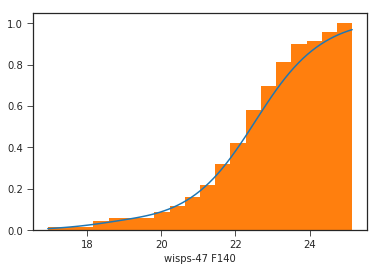

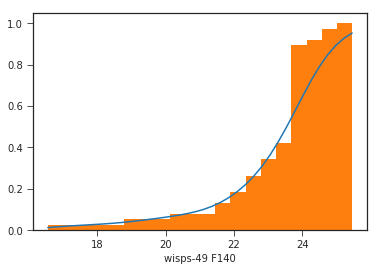

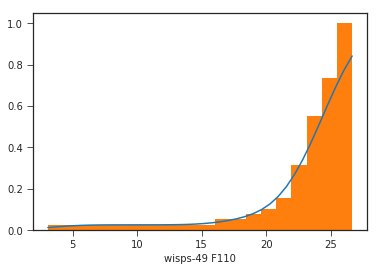

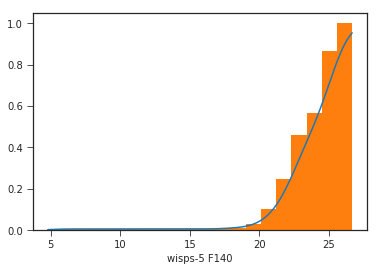

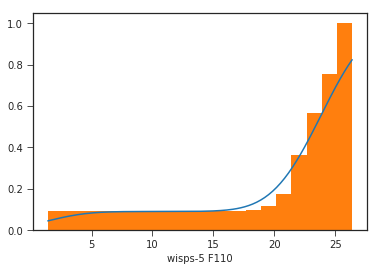

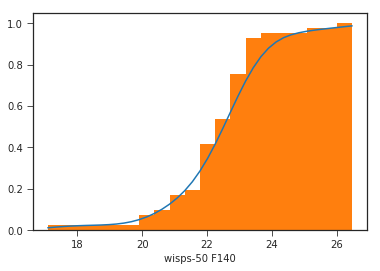

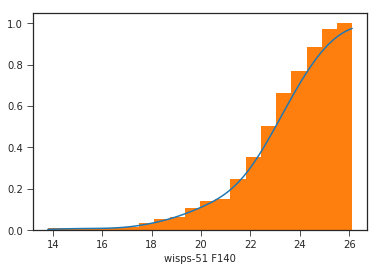

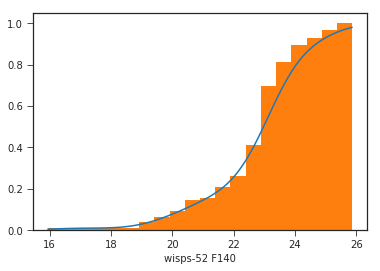

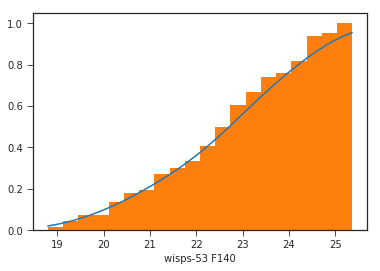

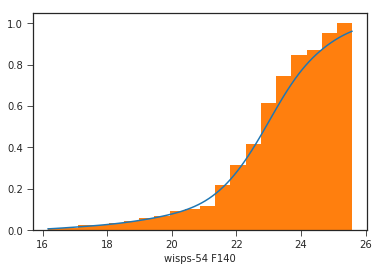

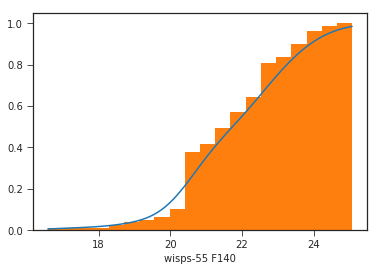

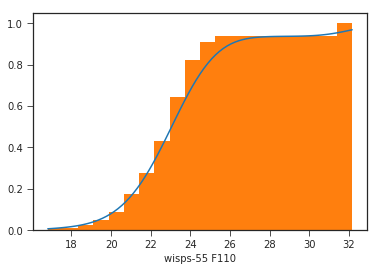

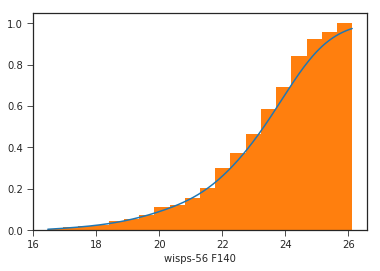

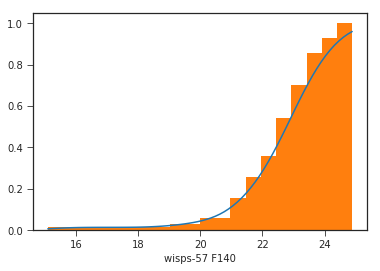

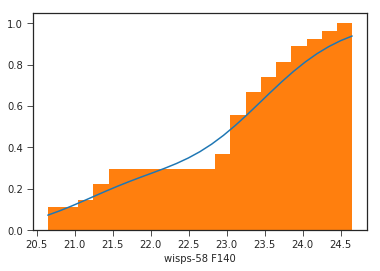

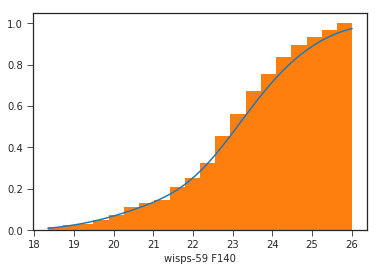

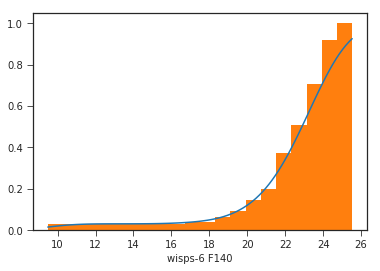

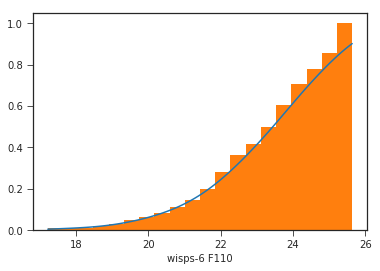

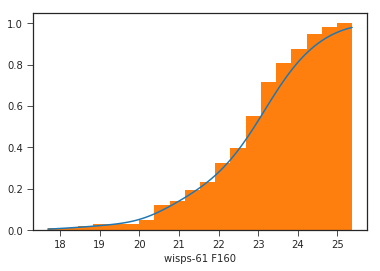

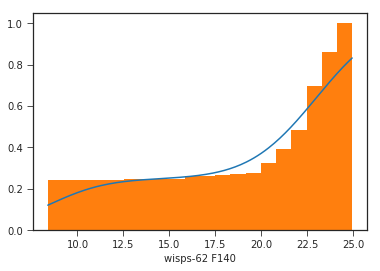

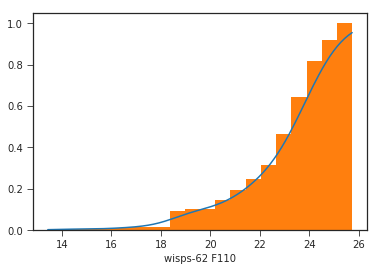

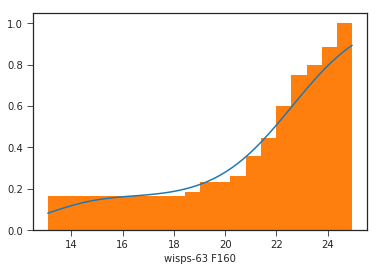

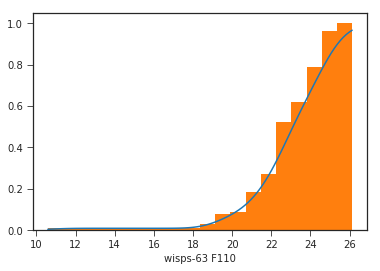

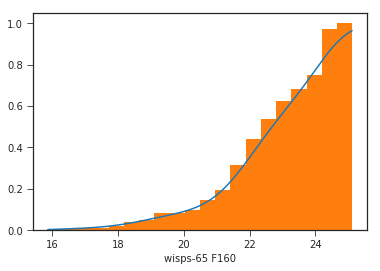

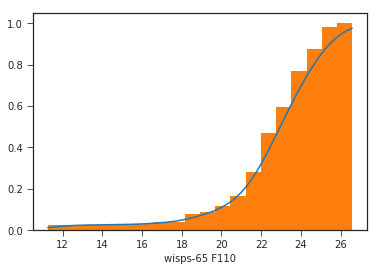

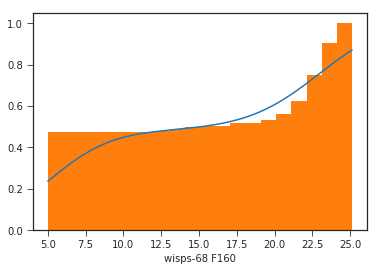

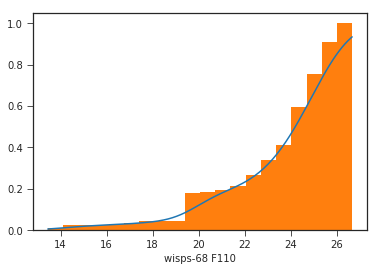

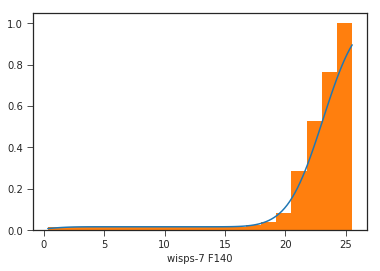

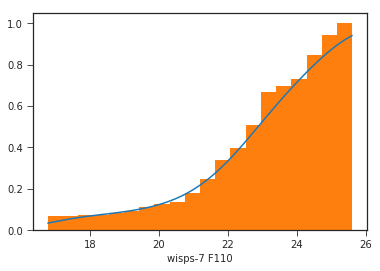

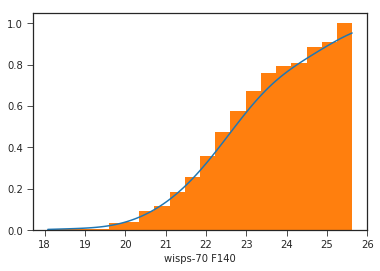

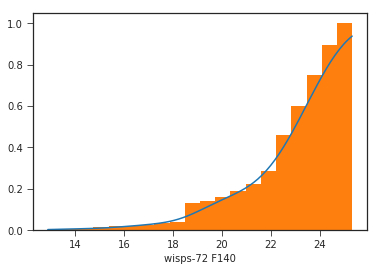

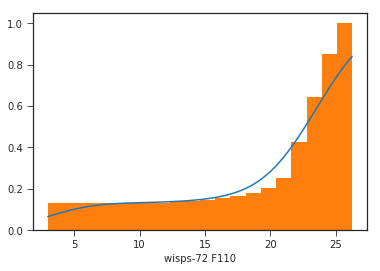

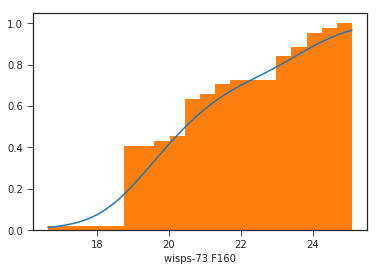

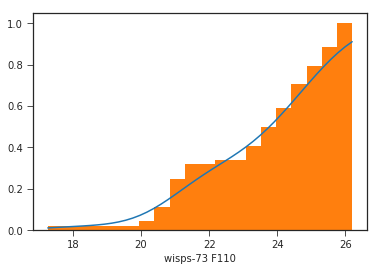

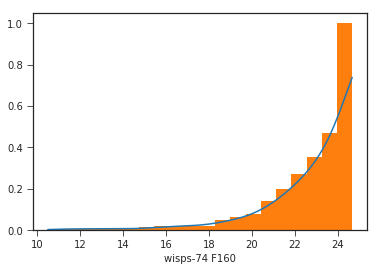

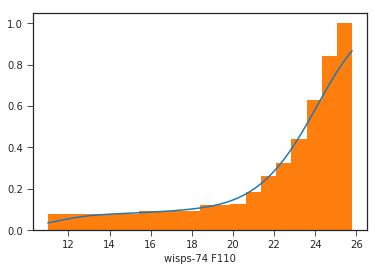

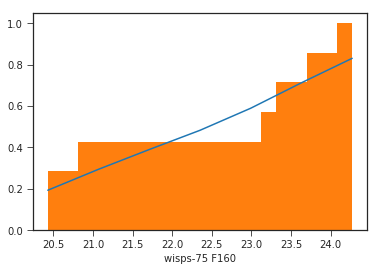

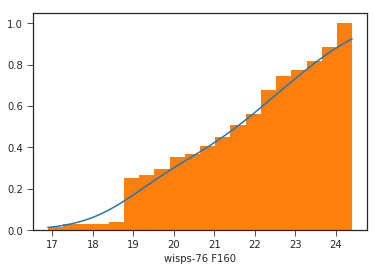

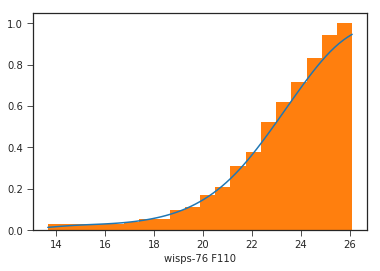

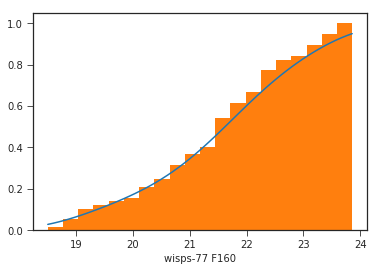

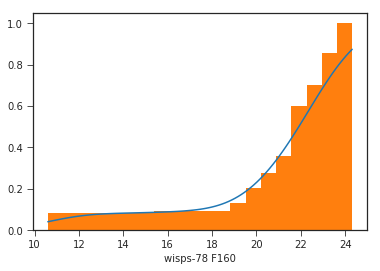

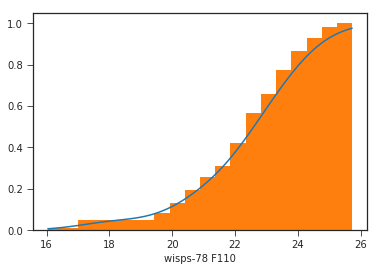

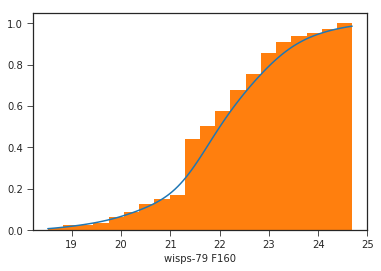

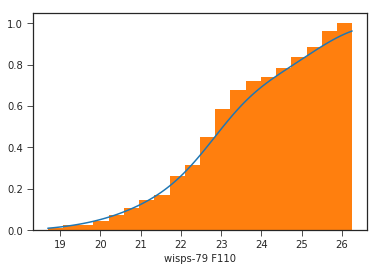

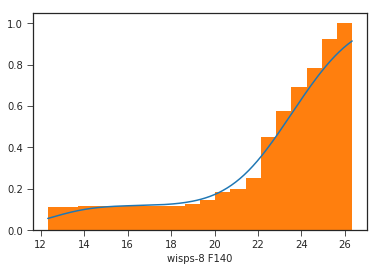

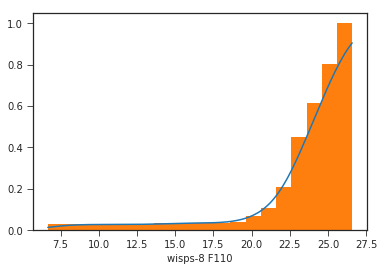

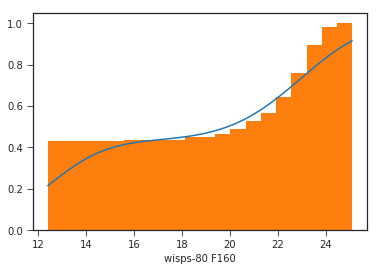

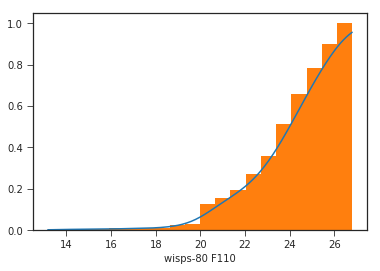

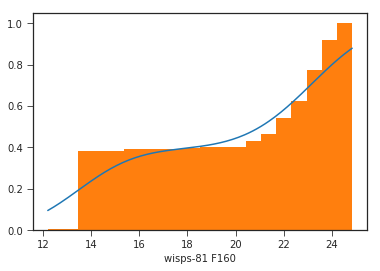

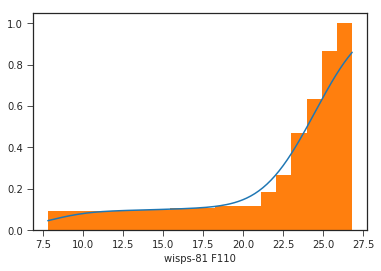

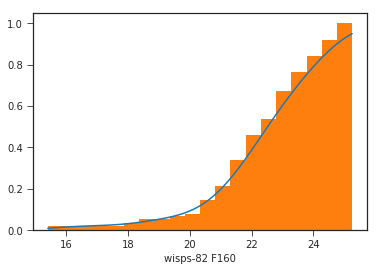

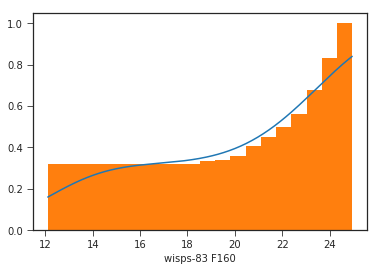

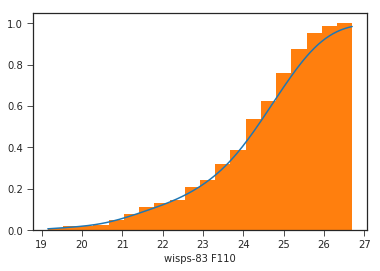

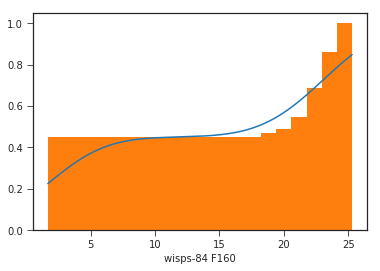

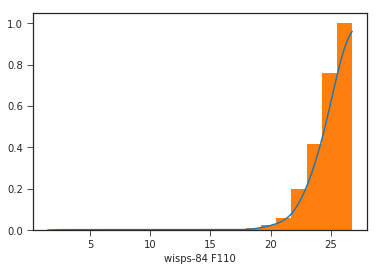

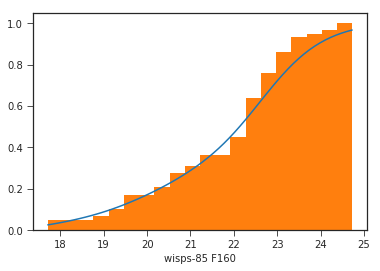

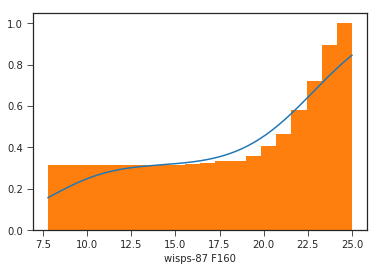

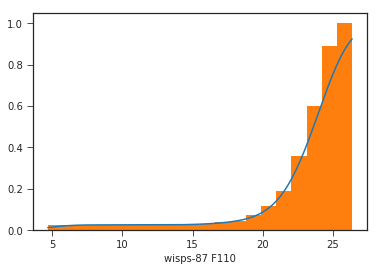

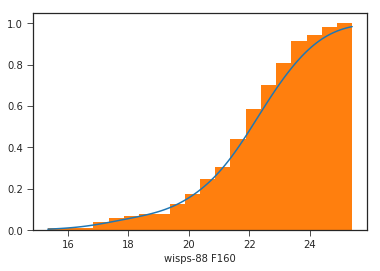

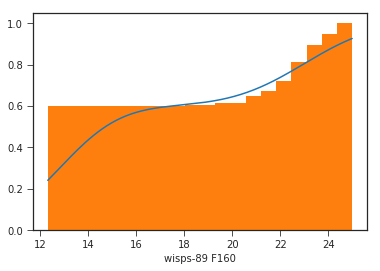

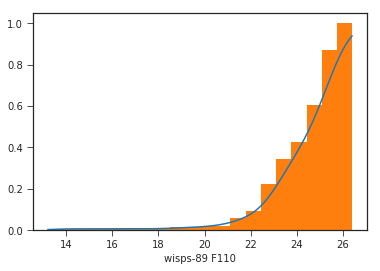

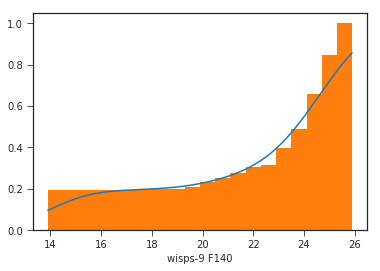

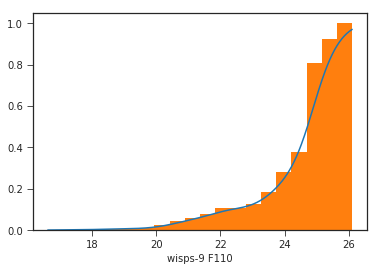

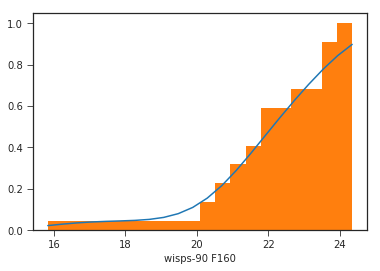

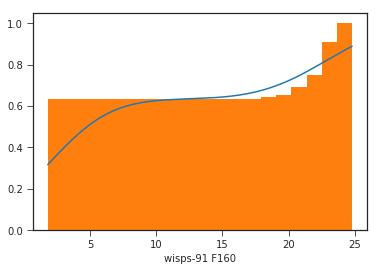

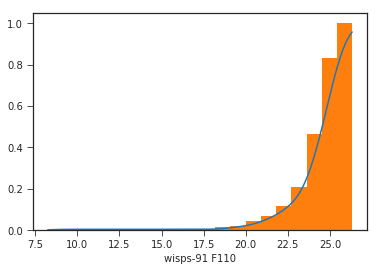

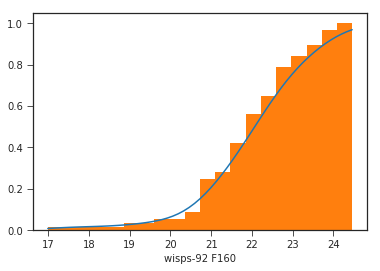

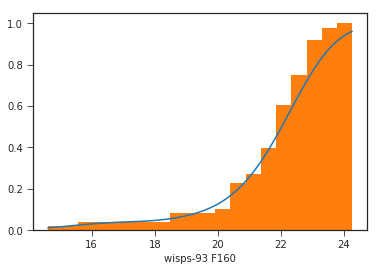

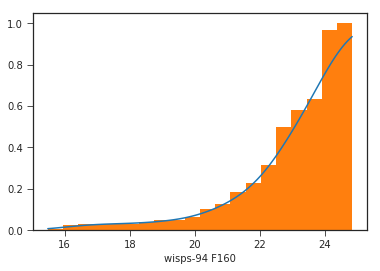

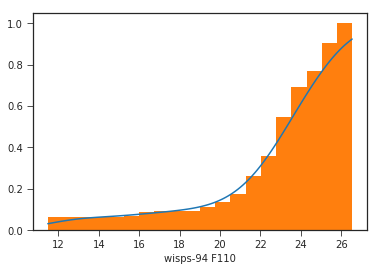

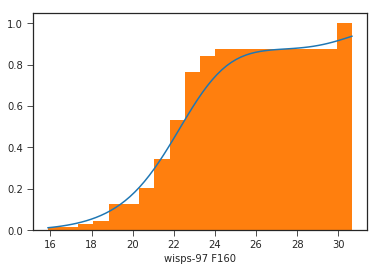

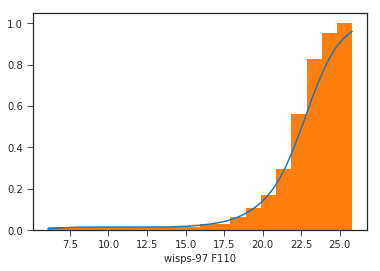

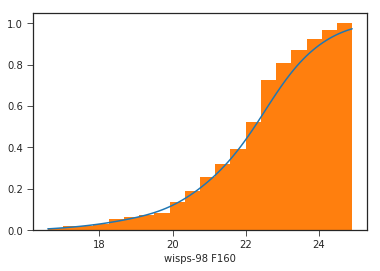

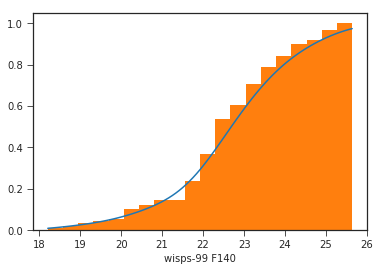

In [9]:
grouped = data_with_cut.groupby('pointing')
for name, group in grouped:
    print (name)
    #print (group['F140'].apply(lambda x: x[0]))
    limit_f140mags_per_field.append(max_flux(group['F140'].apply(lambda x: x[0]).as_matrix(), plot=True, label=name+' F140'))
    limit_f160mags_per_field.append(max_flux(group['F160'].apply(lambda x: x[0]).as_matrix(), plot=True, label=name+' F160'))
    limit_f110mags_per_field.append(max_flux(group['F110'].apply(lambda x: x[0]).as_matrix(), plot=True, label=name+' F110'))
    field_names.append(name.lower())

In [10]:
df=dict()
df['POINTING']=field_names
df['MIN_F140']=np.array(limit_f140mags_per_field)[:,0]
df['MAX_F140']=np.array(limit_f140mags_per_field)[:,1]
df['MIN_F110']=np.array(limit_f110mags_per_field)[:,0]
df['MAX_F110']=np.array(limit_f110mags_per_field)[:,1]
df['MIN_F160']=np.array(limit_f160mags_per_field)[:,0]
df['MAX_F160']=np.array(limit_f160mags_per_field)[:,1]

In [14]:
#len(df['POINTING']), len(grouped)
ndf=pd.DataFrame(df)

In [16]:
observing_info=pd.read_csv(wisps.OUTPUT_FILES+'/observation_log.csv')

In [15]:
ndf=ndf
ndf=ndf.reindex()
observing_info=observing_info.reindex()
ndf['POINTING']=ndf['POINTING'].apply(str)
observing_info['POINTING']=observing_info['POINTING'].apply(str)

In [17]:
allinfo=ndf.merge(observing_info, on='POINTING', how='inner').drop_duplicates().reindex()

In [19]:
allinfo=allinfo.replace('None', np.nan).drop(labels='Unnamed: 0', axis=1)

In [20]:
allinfo['AREA (arcmin^2)']=4.6
(allinfo['AREA (arcmin^2)'])[allinfo.POINTING.str.contains('wisp')]=3.3

In [21]:
allinfo.drop_duplicates(subset='POINTING')

POINTING  MIN_F140  MAX_F140  MIN_F110  MAX_F110  MIN_F160  MAX_F160  \
0      aegis-01      29.0      21.0       NaN       NaN      26.0      21.0   
1      aegis-02      27.0      21.0       NaN       NaN      27.0      21.0   
2      aegis-03      30.0      21.0       NaN       NaN      26.0      21.0   
3      aegis-04      26.0      21.0       NaN       NaN      26.0      20.0   
4      aegis-05      28.0      22.0       NaN       NaN      27.0      22.0   
5      aegis-06      27.0      21.0       NaN       NaN      26.0      21.0   
6      aegis-07      29.0      21.0       NaN       NaN      26.0      21.0   
7      aegis-08      26.0      21.0       NaN       NaN      26.0      21.0   
8      aegis-09      27.0      21.0       NaN       NaN      26.0      21.0   
9      aegis-10      26.0      21.0       NaN       NaN      26.0      21.0   
10     aegis-11      27.0      21.0       NaN       NaN      26.0      21.0   
11     aegis-12      26.0      21.0       NaN       NaN      26.0      21.0   
12     aegis-13      26.0      21.0       NaN       NaN      28.0      21.0   
13     aegis-14      27.0      21.0       NaN       NaN      26.0      21.0   
14     aegis-15      26.0      21.0       NaN       NaN      26.0      21.0   
15     aegis-18      30.0      21.0       NaN       NaN      26.0      20.0   
16     aegis-19      29.0      21.0       NaN       NaN      26.0      21.0   
17     aegis-21      26.0      21.0       NaN       NaN      26.0      21.0   
18     aegis-23      29.0      20.0       NaN       NaN      26.0      20.0   
19     aegis-24      26.0      21.0       NaN       NaN      26.0      21.0   
20     aegis-25      26.0      21.0       NaN       NaN      26.0      21.0   
21     aegis-26      28.0      21.0       NaN       NaN      26.0      21.0   
22     aegis-27      27.0      21.0       NaN       NaN      26.0      21.0   
23     aegis-28      27.0      21.0       NaN       NaN      26.0      21.0   
24    goodsn-11      30.0      20.0       NaN       NaN      26.0      20.0   
25   goodsn-111       NaN       NaN       NaN       NaN       NaN       NaN   
26   goodsn-114      26.0      22.0       NaN       NaN      26.0      22.0   
27    goodsn-12      26.0      21.0       NaN       NaN      26.0      21.0   
29   goodsn-123      26.0      20.0       NaN       NaN      26.0      20.0   
30    goodsn-13      26.0      21.0       NaN       NaN      26.0      20.0   
..          ...       ...       ...       ...       ...       ...       ...   
499    wisps-68       NaN       NaN      27.0      20.0       NaN       NaN   
501     wisps-7      26.0      20.0      26.0      19.0       NaN       NaN   
503    wisps-70      26.0      21.0       NaN       NaN       NaN       NaN   
504    wisps-72      25.0      19.0      26.0       5.0       NaN       NaN   
506    wisps-73       NaN       NaN      26.0      20.0      25.0      18.0   
508    wisps-74       NaN       NaN      26.0      18.0      25.0      20.0   
510    wisps-75       NaN       NaN       NaN       NaN       NaN       NaN   
511    wisps-76       NaN       NaN      26.0      19.0      24.0      18.0   
513    wisps-77       NaN       NaN       NaN       NaN      24.0      19.0   
514    wisps-78       NaN       NaN      26.0      20.0      24.0      17.0   
516    wisps-79       NaN       NaN      26.0      21.0      25.0      20.0   
518     wisps-8      26.0      14.0      27.0      21.0       NaN       NaN   
520    wisps-80       NaN       NaN      27.0      21.0       NaN       NaN   
522    wisps-81       NaN       NaN      27.0      15.0      25.0      12.0   
524    wisps-82       NaN       NaN       NaN       NaN      25.0      20.0   
526    wisps-83       NaN       NaN      27.0      22.0       NaN       NaN   
528    wisps-84       NaN       NaN      27.0      22.0       NaN       NaN   
530    wisps-85       NaN       NaN       NaN       NaN      25.0      19.0   
531    wisps-87       NaN       NaN      26.0      20.0  

In [23]:
allinfo.drop_duplicates(subset='POINTING').to_latex(wisps.OUTPUT_FILES+'/observation_log_with_mag.tex', index=False, na_rep=' ')
allinfo.drop_duplicates(subset='POINTING').to_csv(wisps.OUTPUT_FILES+'/observation_log_with_mag.csv')

In [ ]:
allinfo

In [ ]:
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

In [ ]:
f